In [1]:
# Libraries for data loading and manipulation
import os, cv2, json, random, subprocess, zipfile
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm
from matplotlib.path import Path
import pyarrow as pa

# Libraries for ROI consolidation
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from itertools import combinations
from shapely import make_valid
import shutil

# Libraries for visualization
import matplotlib.pyplot as plt
import tifffile as tf
from PIL import Image, ImageDraw

In [2]:
def subsetTranscriptsByPolygons(transcripts, df_polygons, output_root, slide_id, qv_thresh=20):
    """
    Subset transcripts based on polygon regions, filtering by qv threshold and saving each subset
    as a parquet file in the appropriate directory.

    Parameters:
    - transcripts: pandas DataFrame with transcript data including 'x_location', 'y_location', 'feature_name', and 'qv'
    - df_polygons: DataFrame containing polygon coordinates and metadata (with 'X', 'Y', 'slice', 'region' columns)
    - output_root: Root directory where subset data will be saved
    - slide_id: Identifier for the current slide
    - qv_thresh: Quality value threshold for filtering transcripts (default = 20)

    Returns:
    - Dictionary mapping (slice, region) tuples to the paths of saved parquet files
    """
    
    # Filter transcripts by qv threshold
    transcripts = transcripts[transcripts['qv'] > qv_thresh]
    
    # Initialize dictionary to store results
    saved_paths = {}
    
    # Group polygons by slice and region
    for (slice_id, region_id), group_df in tqdm(df_polygons.groupby(['slice', 'region']), 
                                               desc=f"Processing regions for slide {slide_id}"):
        # Create output directory
        output_dir = os.path.join(output_root, f"{slide_id}_{slice_id}_region{region_id}")
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Create polygon path from coordinates
        polygon_coords = list(zip(group_df['X'], group_df['Y']))
        polygon_path = Path(polygon_coords)
        
        
        # Calculate bounding box for initial filtering
        min_x = group_df['X'].min()
        max_x = group_df['X'].max()
        min_y = group_df['Y'].min()
        max_y = group_df['Y'].max()
        
        # First filter by bounding box for efficiency
        potential_transcripts = transcripts[
            (transcripts['x_location'] >= min_x) &
            (transcripts['x_location'] <= max_x) &
            (transcripts['y_location'] >= min_y) &
            (transcripts['y_location'] <= max_y)
        ]
        
        # Then filter by actual polygon shape
        points = list(zip(potential_transcripts['x_location'], 
                         potential_transcripts['y_location']))
        mask = polygon_path.contains_points(points)
        subset_transcripts = potential_transcripts[mask]
        
        # Save filtered transcripts as parquet
        output_path = os.path.join(output_dir, 'transcripts.parquet')
        pq.write_table(pa.Table.from_pandas(subset_transcripts), output_path)
        
        # Store the path
        saved_paths[(slice_id, region_id)] = output_path
        
        # Print summary statistics
        print(f"\nSubset statistics for {slide_id}_{slice_id}_region{region_id}:")
        print(f"Total transcripts in region: {len(subset_transcripts)}")
        print(f"Unique genes in region: {subset_transcripts['feature_name'].nunique()}")
        print(f"Saved to: {output_path}\n")
    
    return saved_paths

def create_valid_polygon(coords):
    """
    Creates a valid polygon from coordinates, attempting to fix any topology issues.
    
    Parameters:
    - coords: List of (x,y) coordinate tuples
    
    Returns:
    - Shapely Polygon object
    """
    try:
        poly = Polygon(coords)
        if not poly.is_valid:
            poly = make_valid(poly)
        return poly
    except Exception as e:
        print(f"Error creating polygon: {e}")
        return None
    
from shapely.geometry import GeometryCollection, Polygon, MultiPolygon

def create_valid_polygon(coords):
    """
    Creates a valid polygon from coordinates, attempting to fix any topology issues.
    
    Parameters:
    - coords: List of (x, y) coordinate tuples
    
    Returns:
    - A valid Shapely Polygon or MultiPolygon object, or None if unable to create.
    """
    try:
        poly = Polygon(coords)
        if not poly.is_valid:
            poly = make_valid(poly)
        
        # Check if make_valid returns a GeometryCollection
        if isinstance(poly, GeometryCollection):
            # Extract valid polygons from the GeometryCollection
            poly = [p for p in poly.geoms if isinstance(p, (Polygon, MultiPolygon))]
            
            # Merge polygons if there are multiple, or take the first valid one
            if len(poly) > 1:
                poly = unary_union(poly)
            elif len(poly) == 1:
                poly = poly[0]
            else:
                return None  # No valid polygon found in the collection
        
        return poly
    except Exception as e:
        print(f"Error creating polygon: {e}")
        return None

def consolidate_overlapping_regions(df, visualize=True):
    """
    Consolidates overlapping polygon regions within each slice and renumbers disjoint regions.
    
    Parameters:
    - df: DataFrame with columns X, Y, slide, slice, region
    - visualize: Boolean to control visualization output
    
    Returns:
    - DataFrame with consolidated regions and new region numbering
    """
    # Create copy to avoid modifying original
    df_new = df.copy()
    
    # Process each slide and slice combination
    for (slide_id, slice_id), group_df in df.groupby(['slide', 'slice']):
        print(f"\nProcessing {slide_id} {slice_id}")
        
        # Convert regions to shapely polygons with validation
        polygons = {}
        for region_id, region_df in group_df.groupby('region'):
            coords = list(zip(region_df['X'], region_df['Y']))
            poly = create_valid_polygon(coords)
            if poly is not None:
                if isinstance(poly, MultiPolygon):
                    # Take the largest polygon if we got a MultiPolygon
                    poly = max(poly.geoms, key=lambda p: p.area)
                polygons[region_id] = poly
            else:
                print(f"Skipping invalid region {region_id}")
        
        if not polygons:
            print(f"No valid polygons found for {slide_id} {slice_id}")
            continue
        
        # Find overlapping regions
        overlaps = []
        for (r1, p1), (r2, p2) in combinations(polygons.items(), 2):
            try:
                if p1.intersects(p2) and p1.intersection(p2).area > 0:
                    overlaps.append({r1, r2})
            except Exception as e:
                print(f"Error checking overlap between regions {r1} and {r2}: {e}")
        
        # Merge overlap sets that share regions
        merged_sets = []
        for overlap in overlaps:
            added = False
            for merged_set in merged_sets:
                if not merged_set.isdisjoint(overlap):
                    merged_set.update(overlap)
                    added = True
                    break
            if not added:
                merged_sets.append(overlap)
        
        # Create consolidated polygons
        consolidated = {}
        used_regions = set()
        
        # Handle overlapping regions
        for i, region_set in enumerate(merged_sets):
            try:
                used_regions.update(region_set)
                region_polys = [polygons[r] for r in region_set]
                
                if visualize:
                    # Plot original overlapping regions
                    plt.figure(figsize=(10, 10))
                    for j, poly in enumerate(region_polys):
                        x, y = poly.exterior.xy
                        plt.plot(x, y, label=f'Original Region {list(region_set)[j]}')
                    plt.title(f'Overlapping Regions in {slide_id} {slice_id}')
                    plt.legend()
                    plt.axis('equal')
                    plt.show()
                
                # Merge polygons with error handling
                merged_poly = region_polys[0]
                for poly in region_polys[1:]:
                    try:
                        merged_poly = merged_poly.union(poly)
                    except Exception as e:
                        print(f"Error during union operation: {e}")
                        merged_poly = make_valid(merged_poly.union(poly))
                
                consolidated[i] = merged_poly
                
                if visualize:
                    # Plot consolidated region
                    plt.figure(figsize=(10, 10))
                    if isinstance(merged_poly, Polygon):
                        x, y = merged_poly.exterior.xy
                        plt.plot(x, y, 'r-', label='Consolidated Region')
                    elif isinstance(merged_poly, MultiPolygon):
                        for poly in merged_poly.geoms:
                            x, y = poly.exterior.xy
                            plt.plot(x, y, 'r-', label='Consolidated Region')
                    plt.title(f'Consolidated Region in {slide_id} {slice_id}')
                    plt.legend()
                    plt.axis('equal')
                    plt.show()
                    
            except Exception as e:
                print(f"Error processing region set {region_set}: {e}")
                continue
        
        # Add non-overlapping regions
        for region_id, poly in polygons.items():
            if region_id not in used_regions:
                consolidated[len(consolidated)] = poly
        
        # Create new coordinates for consolidated regions
        new_coords = []
        for new_region_id, poly in consolidated.items():
            try:
                if isinstance(poly, Polygon):
                    x, y = poly.exterior.xy
                    coords = pd.DataFrame({
                        'X': x[:-1],  # Remove last point (same as first)
                        'Y': y[:-1],
                        'slide': slide_id,
                        'slice': slice_id,
                        'region': new_region_id
                    })
                    new_coords.append(coords)
                elif isinstance(poly, MultiPolygon):
                    for p in poly.geoms:
                        x, y = p.exterior.xy
                        coords = pd.DataFrame({
                            'X': x[:-1],
                            'Y': y[:-1],
                            'slide': slide_id,
                            'slice': slice_id,
                            'region': new_region_id
                        })
                        new_coords.append(coords)
            except Exception as e:
                print(f"Error extracting coordinates for region {new_region_id}: {e}")
                continue
        
        # Replace original coordinates for this slide/slice
        mask = (df_new['slide'] == slide_id) & (df_new['slice'] == slice_id)
        df_new = df_new[~mask]
        if new_coords:
            df_new = pd.concat([df_new] + new_coords, ignore_index=True)
    
    return df_new



def get_parquet_size_mb(directory, filename='transcripts.parquet'):
    """
    Get size of parquet file in MB
    """
    parquet_path = os.path.join(directory, filename)
    try:
        # Get size in bytes and convert to MB
        size_mb = os.path.getsize(parquet_path) / (1024 * 1024)
        return round(size_mb, 2)
    except Exception as e:
        print(f"Error getting size for {parquet_path}: {e}")
        return None

def visualize_rois_on_image(df, slide_id, xen_root, pix_size=0.2125, scaling_factor=0.005):
    """
    Visualizes ROIs from a given slide overlaid on the corresponding microscopy image.
    
    Parameters:
    - df: DataFrame with columns X, Y, slide, slice, region
    - slide_id: ID of the slide to visualize
    - xen_root: Root directory containing the microscopy images
    - pix_size: Pixel size for coordinate conversion
    - scaling_factor: Factor to scale down the image for visualization
    """
    # Filter for the specified slide
    slide_df = df[df['slide'] == slide_id]
    
    if slide_df.empty:
        print(f"No data found for slide {slide_id}")
        return
    
    # Load and scale the image
    try:
        dapi = tf.imread(os.path.join(xen_root, 'morphology_focus.ome.tif'), series=0, level=0)
        print(f"Original image shape: {dapi.shape}")
        
        # Scale down the image
        scaled_dapi = cv2.resize(dapi, (0, 0), fx=scaling_factor, fy=scaling_factor)
        print(f"Scaled image shape: {scaled_dapi.shape}")
        
        # Create figure
        plt.figure(figsize=(20, 20))
        
        # Display the scaled image
        plt.imshow(scaled_dapi, cmap='gray')
        
        # Get unique slices for color mapping
        unique_slices = slide_df['slice'].unique()
        n_slices = len(unique_slices)
        
        # Create colors for each slice
        colors = [plt.cm.tab20(i/n_slices) for i in range(n_slices)]
        color_map = dict(zip(unique_slices, colors))
        
        # Plot each region with coordinates adjusted for scaling and pixel size
        for slice_id in unique_slices:
            slice_data = slide_df[slide_df['slice'] == slice_id]
            color = color_map[slice_id]
            
            for region_id, region_df in slice_data.groupby('region'):
                # Convert coordinates to image space and apply scaling
                x_coords = (region_df['X'] / pix_size) * scaling_factor
                y_coords = (region_df['Y'] / pix_size) * scaling_factor
                
                plt.plot(x_coords, y_coords, '-', 
                        color=color,
                        linewidth=3,
                        label=f'{slice_id} Region {region_id}')
        
        # Customize the plot
        plt.title(f'ROIs overlaid on microscopy image - Slide {slide_id}')
        plt.axis('equal')
        
        # Create legend with unique entries
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), 
                  bbox_to_anchor=(1.05, 1), 
                  loc='upper left',
                  borderaxespad=0.)
        
        # Adjust layout to prevent legend cutoff
        plt.tight_layout()
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"Error processing slide {slide_id}: {e}")

def visualize_individual_rois(df, slide_id, xen_root, pix_size=0.2125, scaling_factor=0.005):
    """
    Creates individual zoomed visualizations for each ROI in a slide.
    
    Parameters:
    - df: DataFrame with columns X, Y, slide, slice, region
    - slide_id: ID of the slide to visualize
    - xen_root: Root directory containing the microscopy images
    - pix_size: Pixel size for coordinate conversion
    - scaling_factor: Factor to scale down the image for visualization
    """
    # Filter for the specified slide
    slide_df = df[df['slide'] == slide_id]
    
    if slide_df.empty:
        print(f"No data found for slide {slide_id}")
        return
    
    # Load and scale the image
    try:
        dapi = tf.imread(os.path.join(xen_root, 'morphology_focus.ome.tif'), series=0, level=0)
        scaled_dapi = cv2.resize(dapi, (0, 0), fx=scaling_factor, fy=scaling_factor)
        
        # Process each slice and region
        for slice_id in slide_df['slice'].unique():
            slice_data = slide_df[slide_df['slice'] == slice_id]
            
            for region_id, region_df in slice_data.groupby('region'):
                # Convert coordinates to image space and apply scaling
                x_coords = (region_df['X'] / pix_size) * scaling_factor
                y_coords = (region_df['Y'] / pix_size) * scaling_factor
                
                # Calculate bounding box with padding
                min_x = int(max(0, x_coords.min() - 50))
                max_x = int(min(scaled_dapi.shape[1], x_coords.max() + 50))
                min_y = int(max(0, y_coords.min() - 50))
                max_y = int(min(scaled_dapi.shape[0], y_coords.max() + 50))
                
                # Create figure for this ROI
                plt.figure(figsize=(10, 10))
                
                # Display cropped image
                plt.imshow(scaled_dapi[min_y:max_y, min_x:max_x], cmap='gray')
                
                # Plot ROI
                plt.plot(x_coords - min_x, y_coords - min_y, 'r-', 
                        linewidth=3,
                        label=f'{slice_id} Region {region_id}')
                
                plt.title(f'ROI Detail - Slide {slide_id}, {slice_id} Region {region_id}')
                plt.legend()
                plt.axis('equal')
                plt.tight_layout()
                plt.show()
                plt.close()
                
    except Exception as e:
        print(f"Error processing slide {slide_id}: {e}")

run2_slide18336_coordinates.csv has shape (4571, 5)
run1_slide18429_coordinates2.csv has shape (1509, 5)
run1_slide18429_coordinates3.csv has shape (396, 5)
run1_slide18429_coordinates.csv has shape (4475, 5)
run1_slide18432_coordinates.csv has shape (4405, 5)
run2_slide18521_coordinates.csv has shape (2924, 5)
run3_slide18624_coordinates.csv has shape (4000, 5)
run3_slide22826_coordinates.csv has shape (4103, 5)
run4_slide18300_coordinates.csv has shape (2099, 5)
run4_slide22825_coordinates.csv has shape (2552, 5)
run1_slide18429_coordinates4.csv has shape (1668, 5)

Processing 18300 R4.13

Processing 18300 R4.14

Processing 18300 R5.01

Processing 18300 R5.02

Processing 18300 R5.03

Processing 18300 R5.04

Processing 18300 R5.06

Processing 18300 R5.07

Processing 18300 R5.16

Processing 18300 R5.17

Processing 18336 R2.01

Processing 18336 R2.02

Processing 18336 R2.03

Processing 18336 R2.04

Processing 18336 R2.05

Processing 18336 R2.06

Processing 18336 R2.07

Processing 18429 

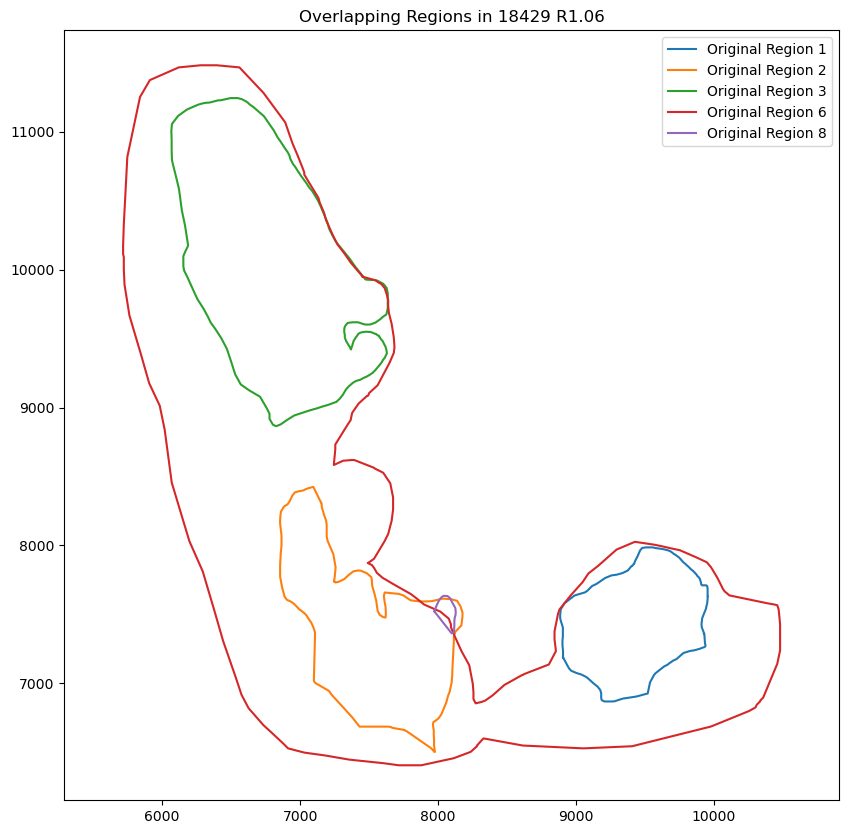

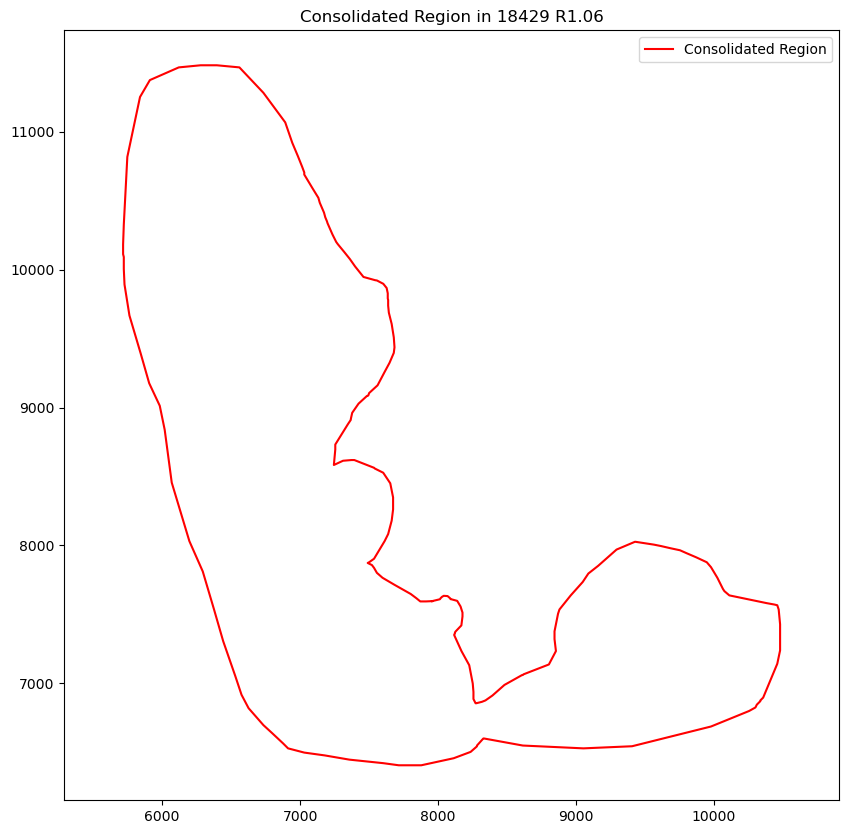

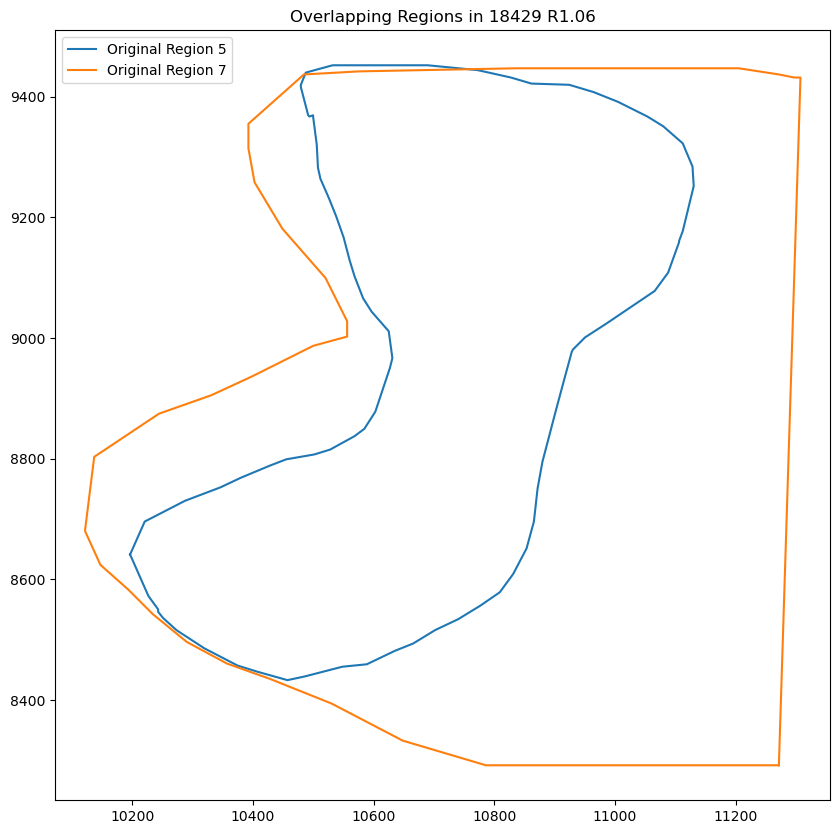

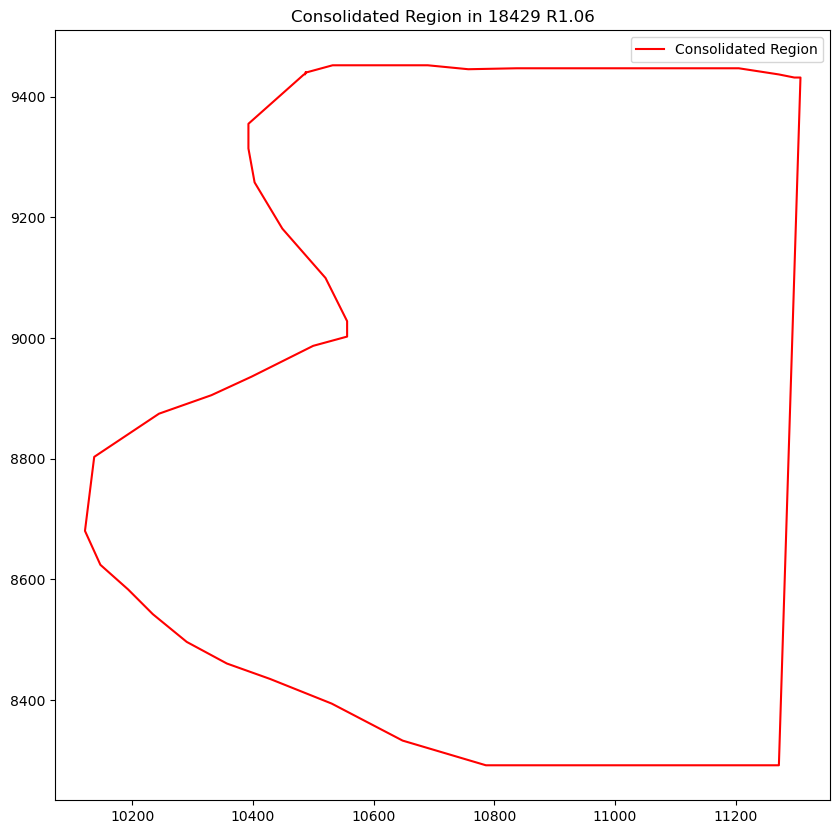


Processing 18429 R1.07

Processing 18429 R1.08


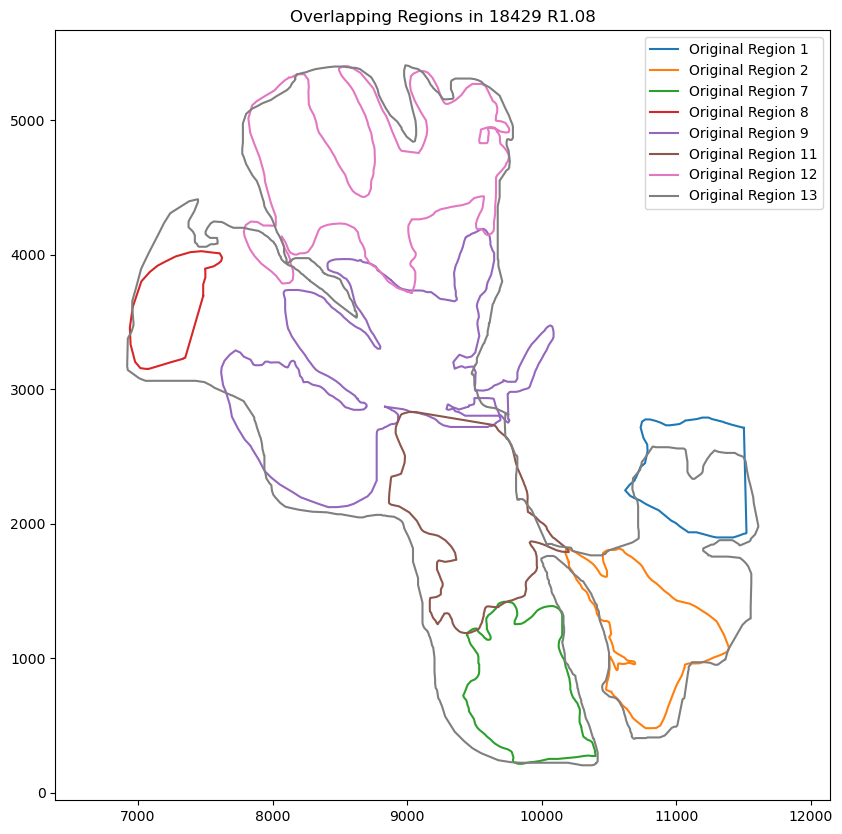

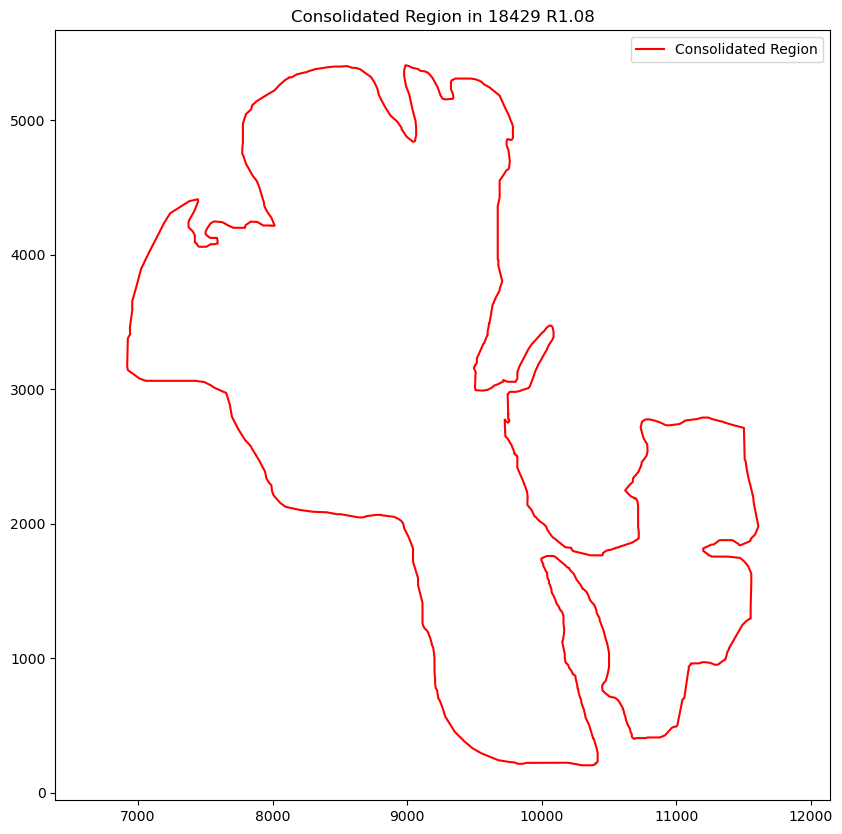

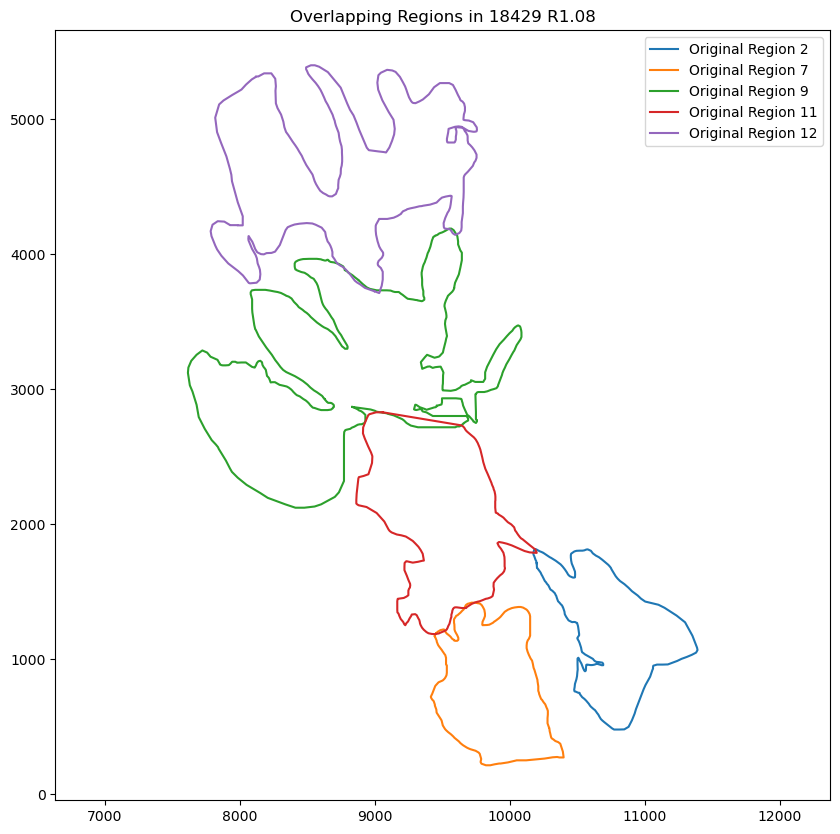

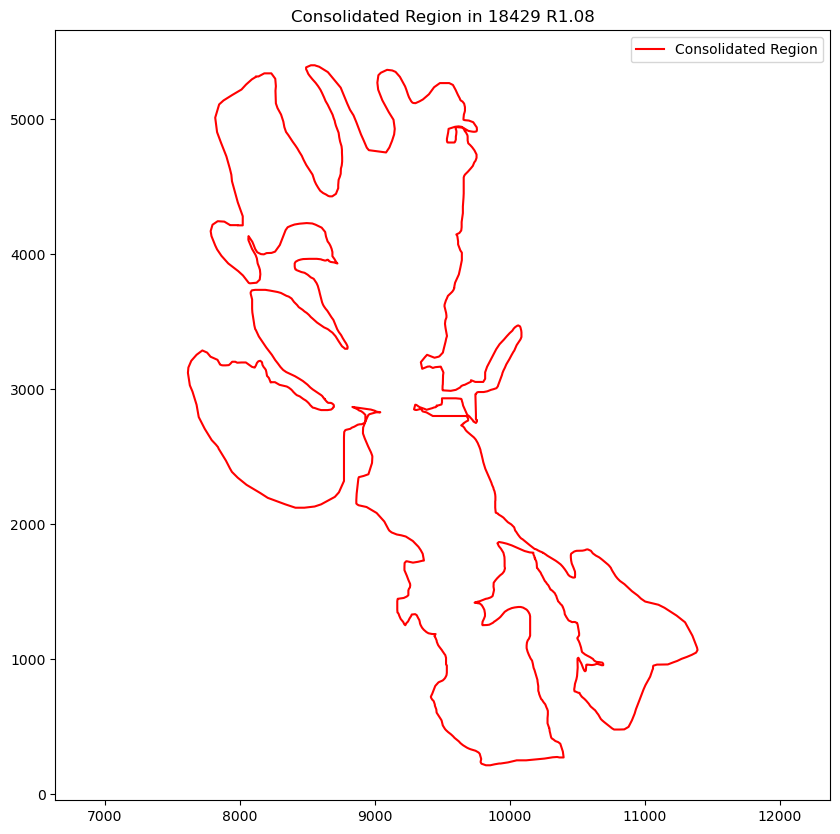

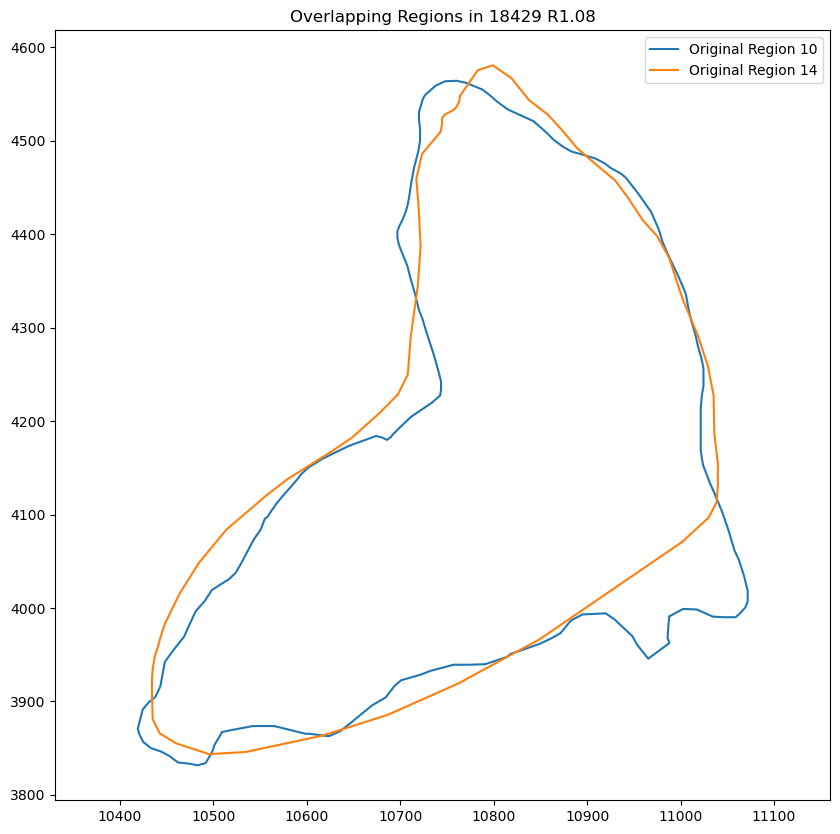

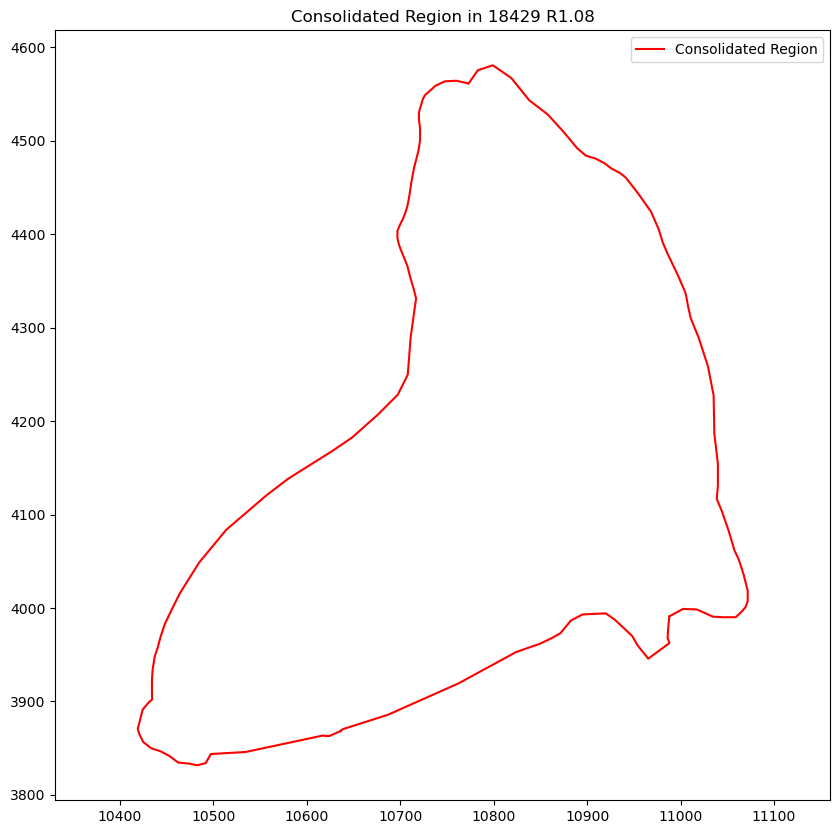


Processing 18432 R1.09

Processing 18432 R1.10


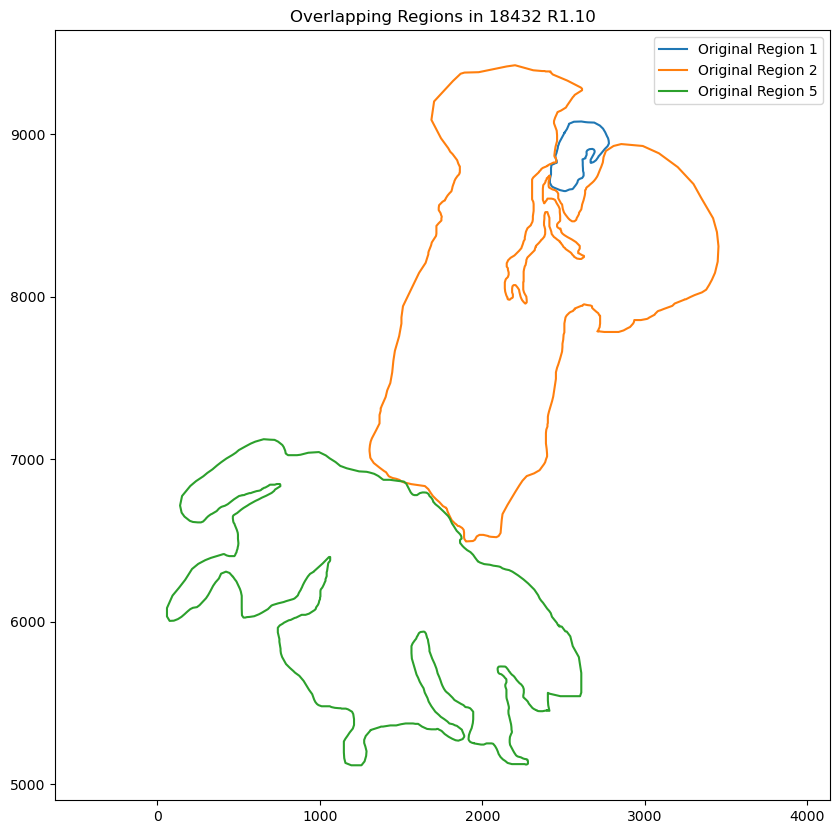

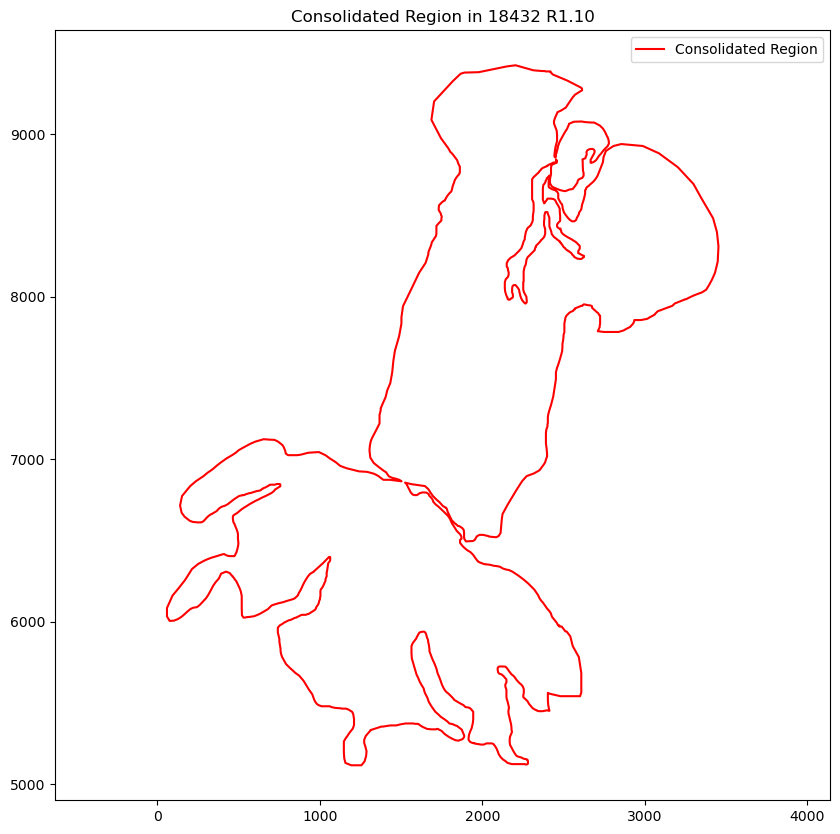


Processing 18432 R1.11

Processing 18432 R1.12

Processing 18521 R2.09

Processing 18521 R2.10

Processing 18521 R2.11

Processing 18521 R2.12

Processing 18521 R2.13

Processing 18521 R2.14

Processing 18521 R2.15

Processing 18521 R2.16

Processing 18521 R2.17

Processing 18624 R3.03

Processing 18624 R3.04

Processing 18624 R3.05


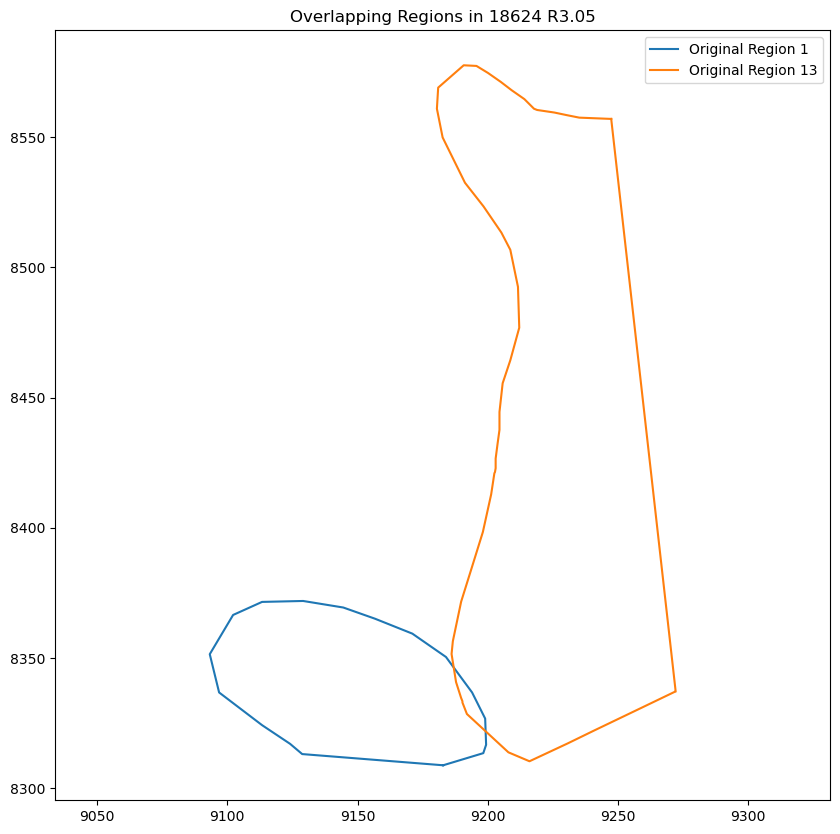

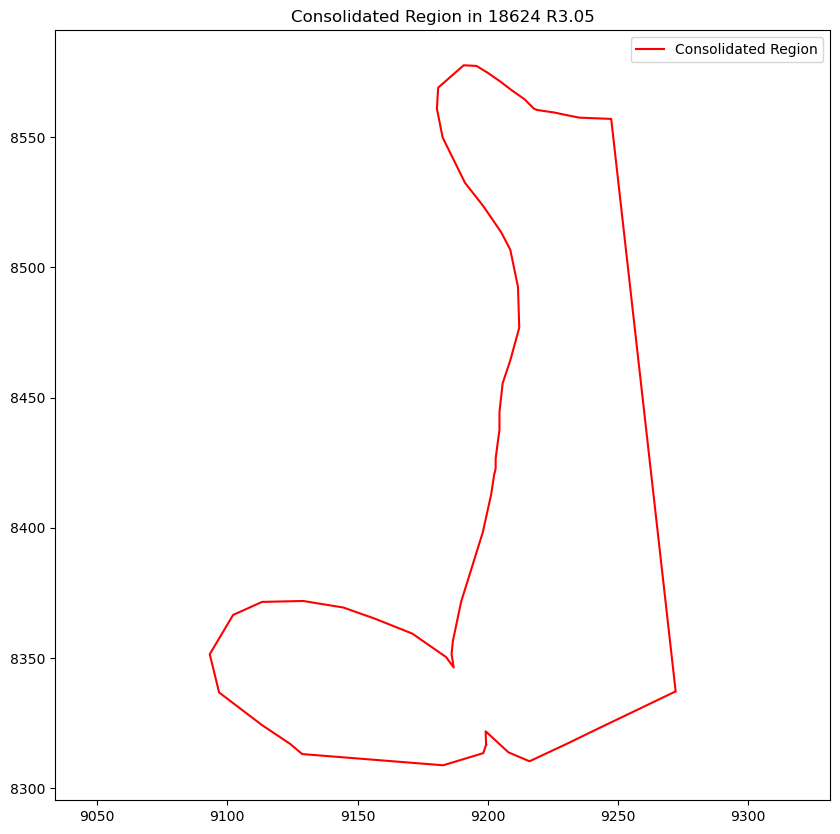

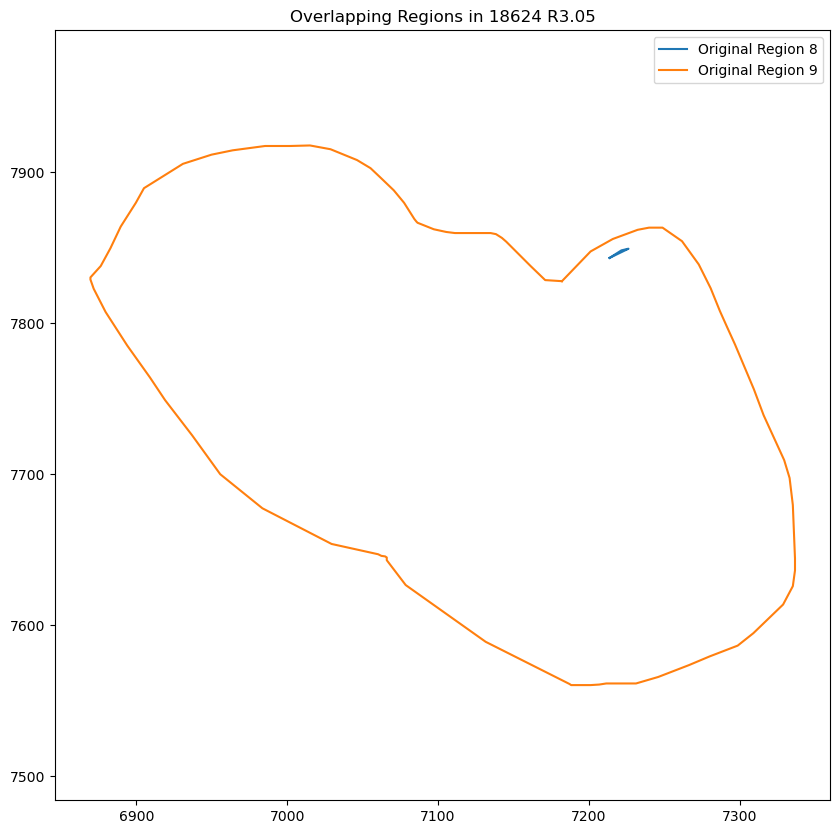

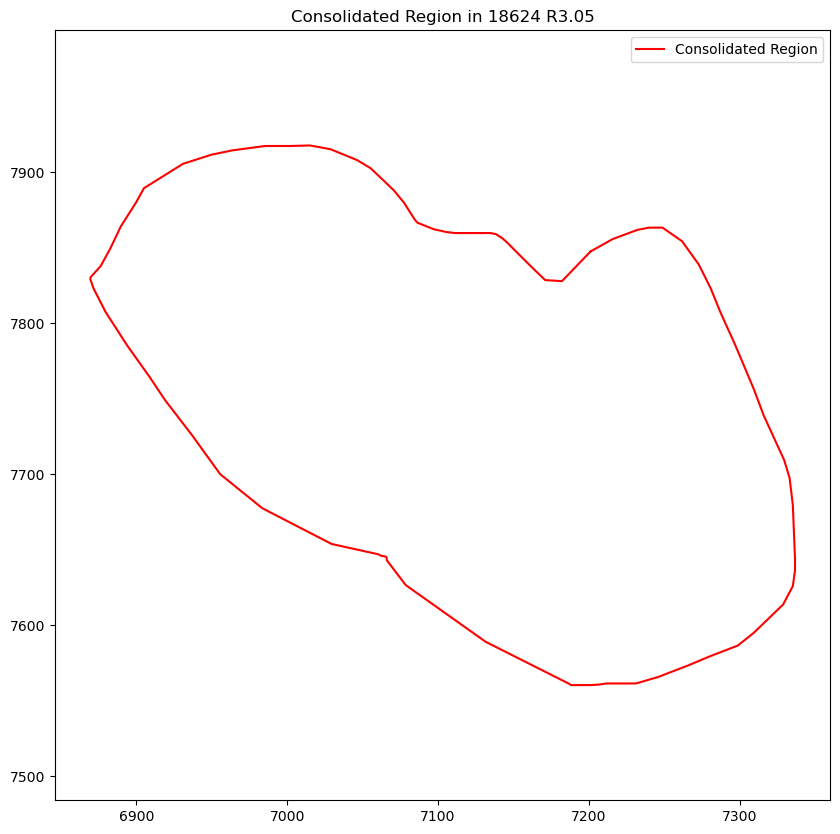


Processing 18624 R3.06

Processing 18624 R3.07

Processing 18624 R3.08


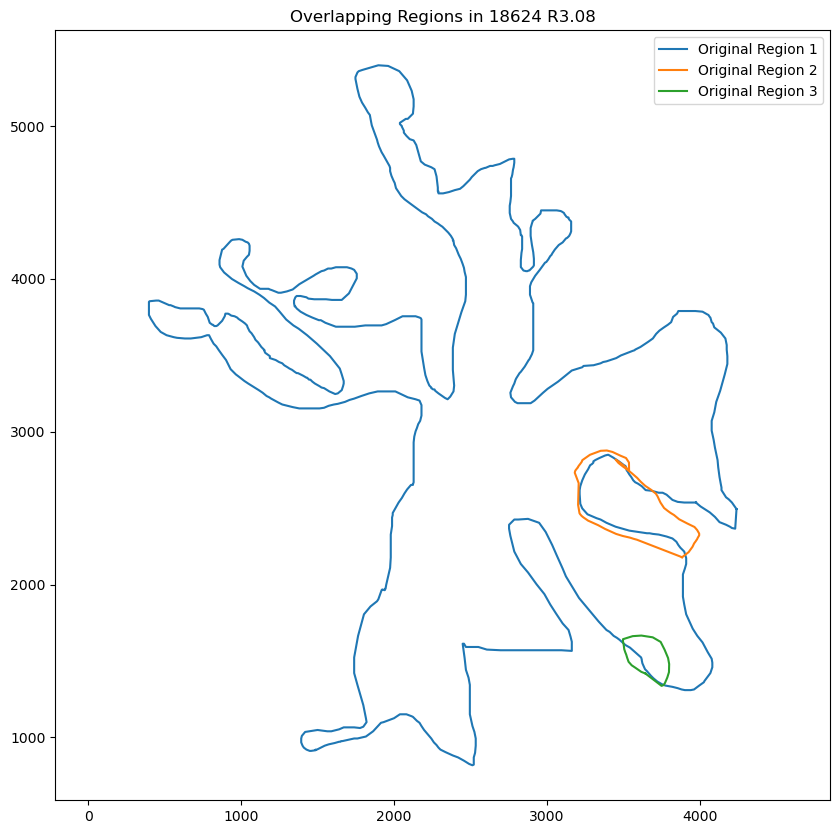

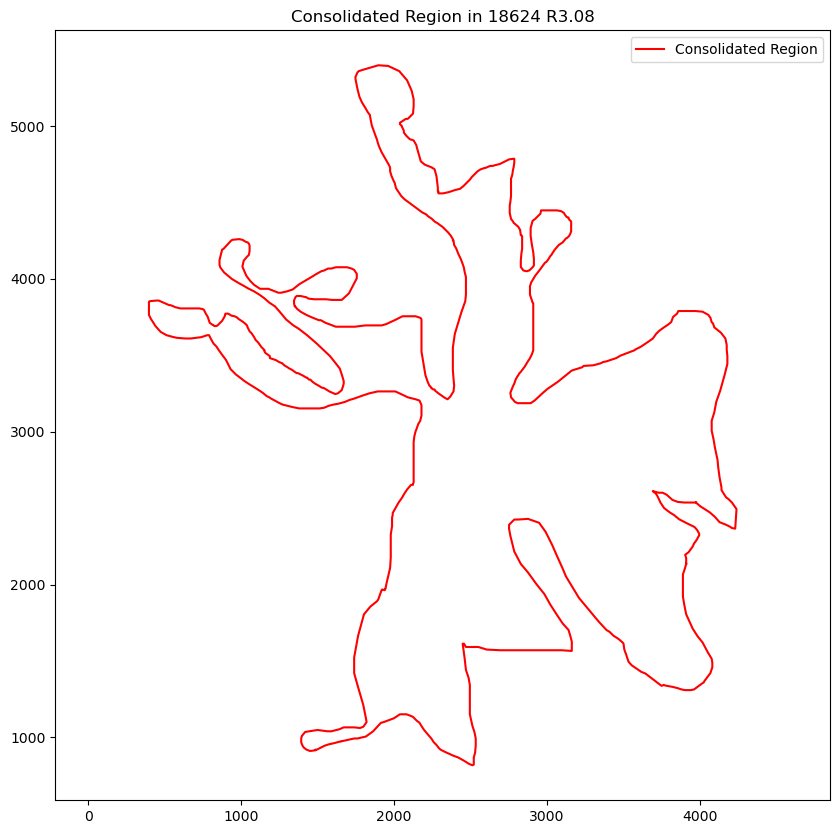


Processing 22825 R3.09


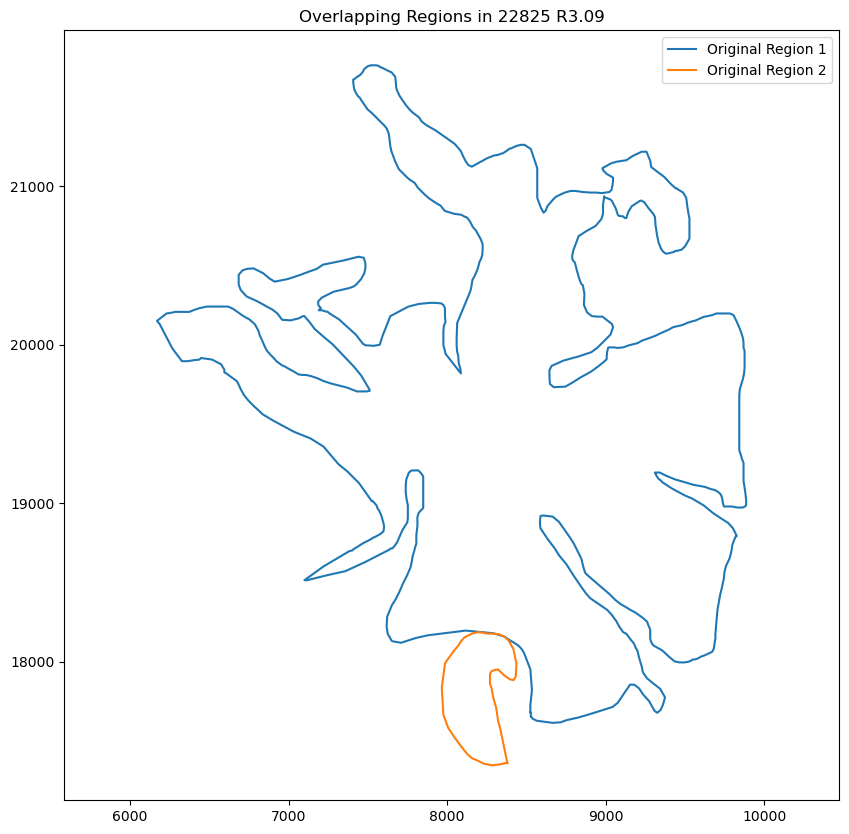

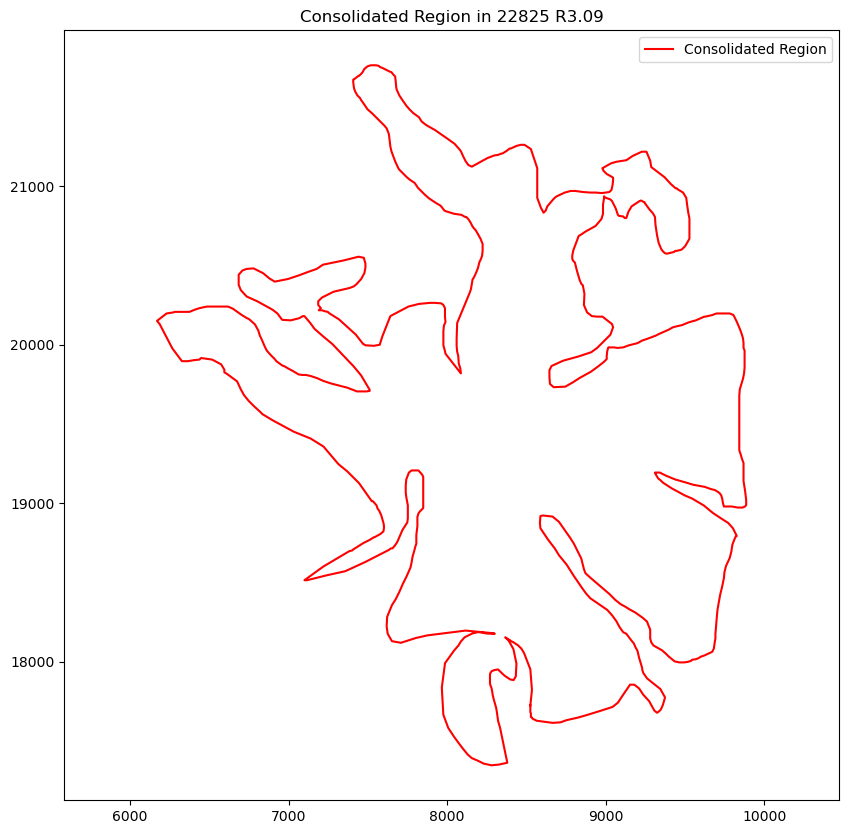


Processing 22825 R3.10


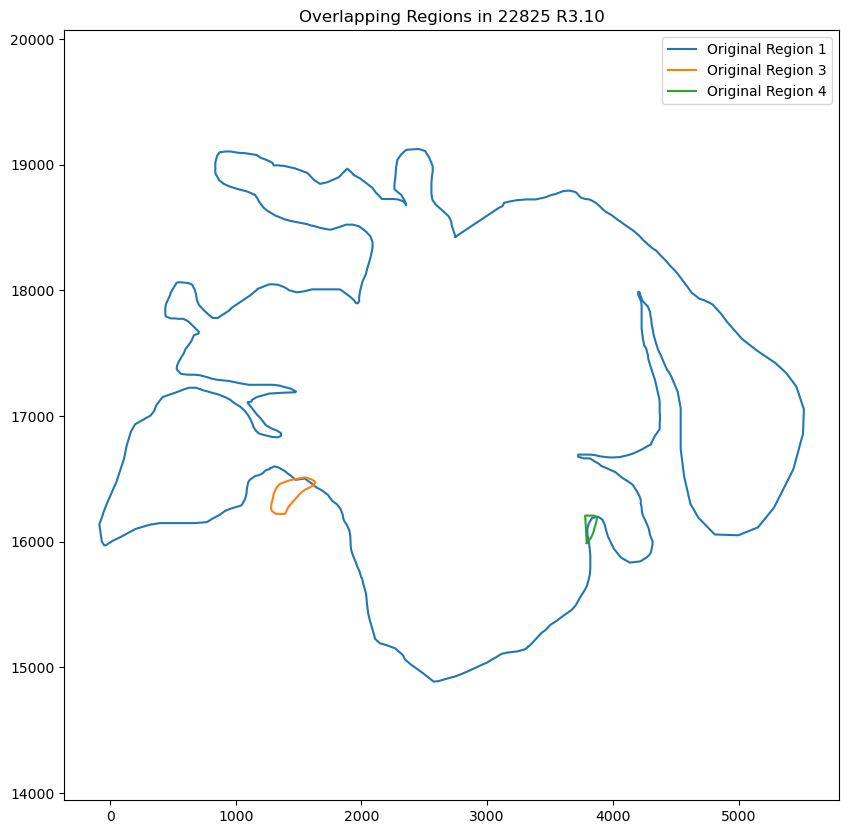

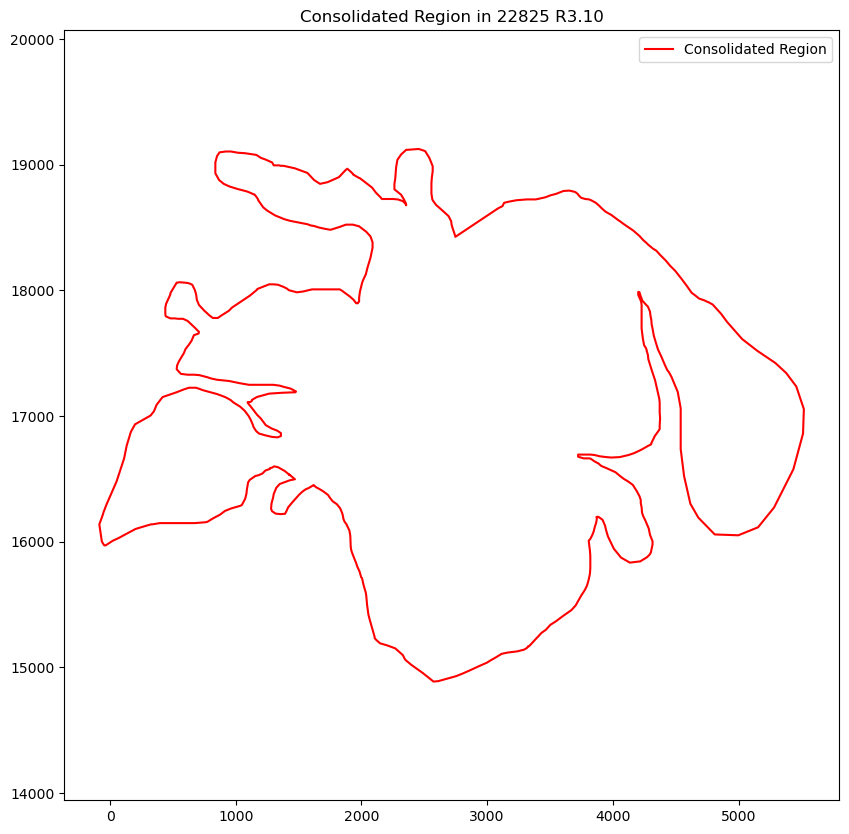


Processing 22825 R3.13

Processing 22825 R3.14

Processing 22825 R4.01

Processing 22825 R4.02

Processing 22825 R4.03

Processing 22825 R4.04

Processing 22825 R5.15

Processing 22826 R4.05

Processing 22826 R4.06

Processing 22826 R4.07

Processing 22826 R4.08

Processing 22826 R4.09

Processing 22826 R4.10

Processing 22826 R4.11

Processing 22826 R4.12
32702 raw nodes found, consolidation reduces this to 30634, a reduction of 6.3%


In [3]:
# Load static paths
root = '/media/sam/New Volume/Xenium_Data'
output_root = '/media/sam/Data2/baysor_rbpms_consolidated'
os.makedirs(output_root, exist_ok=True) # Make sure output path exists
xen_roots = ['output-XETG00230__0018429__Region_1__20240105__233208',
             'output-XETG00230__0018432__Region_2__20240105__233208',
             'BudoffRun2_Slide 3_4/BudoffRun2_Slide 3_4/output-XETG00230__0018336__Region_1__20240124__002923',
             'BudoffRun2_Slide 3_4/BudoffRun2_Slide 3_4/output-XETG00230__0018521__Region_1__20240124__002923',
             'BudoffRun3_Slide 5_6/BudoffRun3_Slide 5_6/output-XETG00230__0018624__Region_1__20240127__000149',
             'BudoffRun3_Slide 5_6/BudoffRun3_Slide 5_6/output-XETG00230__0022826__Region_1__20240127__000149',
             'BudoffRun4_Slide 7_8/BudoffRun4_Slide 7_8/output-XETG00230__0018300__Region_1__20240206__235339',
             'BudoffRun4_Slide 7_8/BudoffRun4_Slide 7_8/output-XETG00230__0022825__Region_1__20240206__235339']
coords_root = '/media/sam/Data2/xenium_rbpms_coordinates'

# Extract slide_ids
slides = [xen_root[-33:-28] for xen_root in xen_roots]

# Load all coordinates and merge into a single dataframe with columns X, Y, slide, slice, region
coords_paths = os.listdir(coords_root)
dfs = []
for coord_path in coords_paths:
    df_i = pd.read_csv(os.path.join(coords_root,coord_path),skiprows=2)
    df_i['slide'] = coord_path[10:15]
    # Use regex to separate 'slice' and 'region'
    df_i[['slice', 'region']] = df_i['Selection'].str.extract(r'(?i)(R\d\.\d{2})(?:_region(\d{1,2}))?')
    # Fill NaN values in 'region' with 0 and convert to integer
    df_i['region'] = df_i['region'].fillna(0).astype(int)
    df_i = df_i.drop(columns=['Selection'])
    dfs.append(df_i)
    print(f'{coord_path} has shape {df_i.shape}')
    
# Concatenate all DataFrames in dfs into one DataFrame
df = pd.concat(dfs, ignore_index=True)

# Consolidate regions
df_consolidated = consolidate_overlapping_regions(df)

print(f'{df.shape[0]} raw nodes found, consolidation reduces this to {df_consolidated.shape[0]}, a reduction of {round((df.shape[0]-df_consolidated.shape[0])/df.shape[0],3)*100}%')

Original image shape: (112158, 54055)
Scaled image shape: (561, 270)


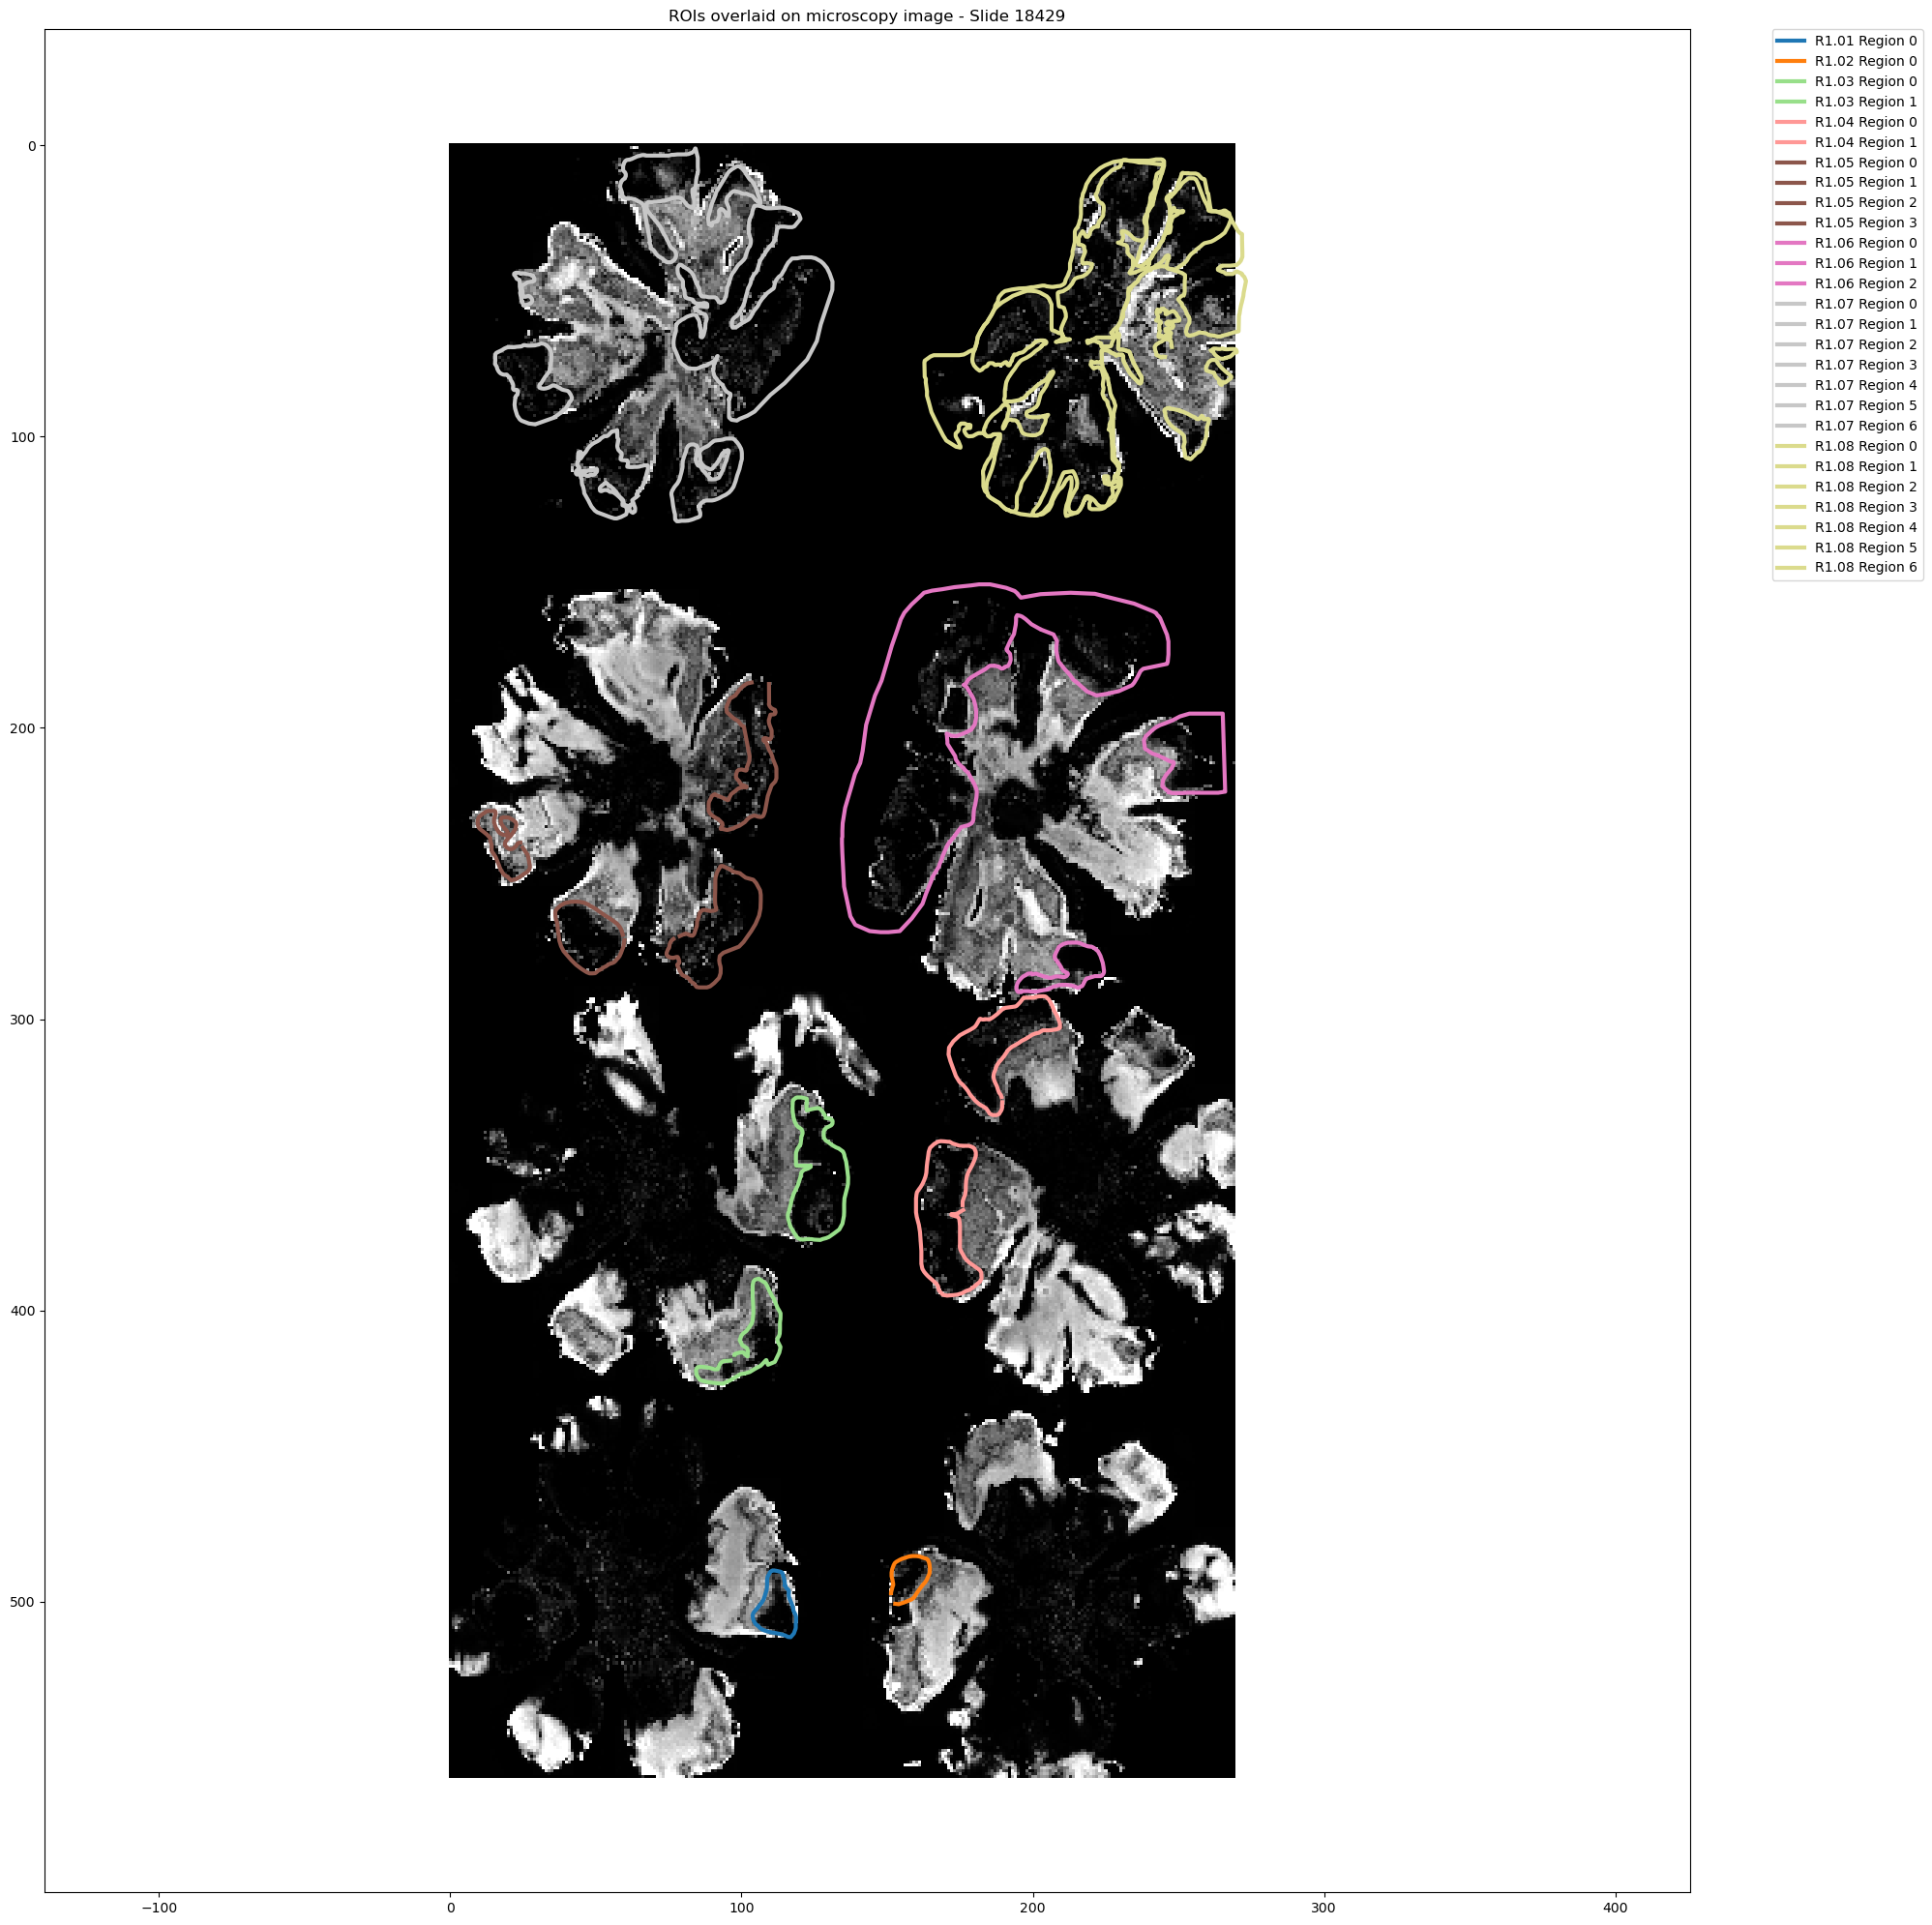

Original image shape: (47628, 51129)
Scaled image shape: (238, 256)


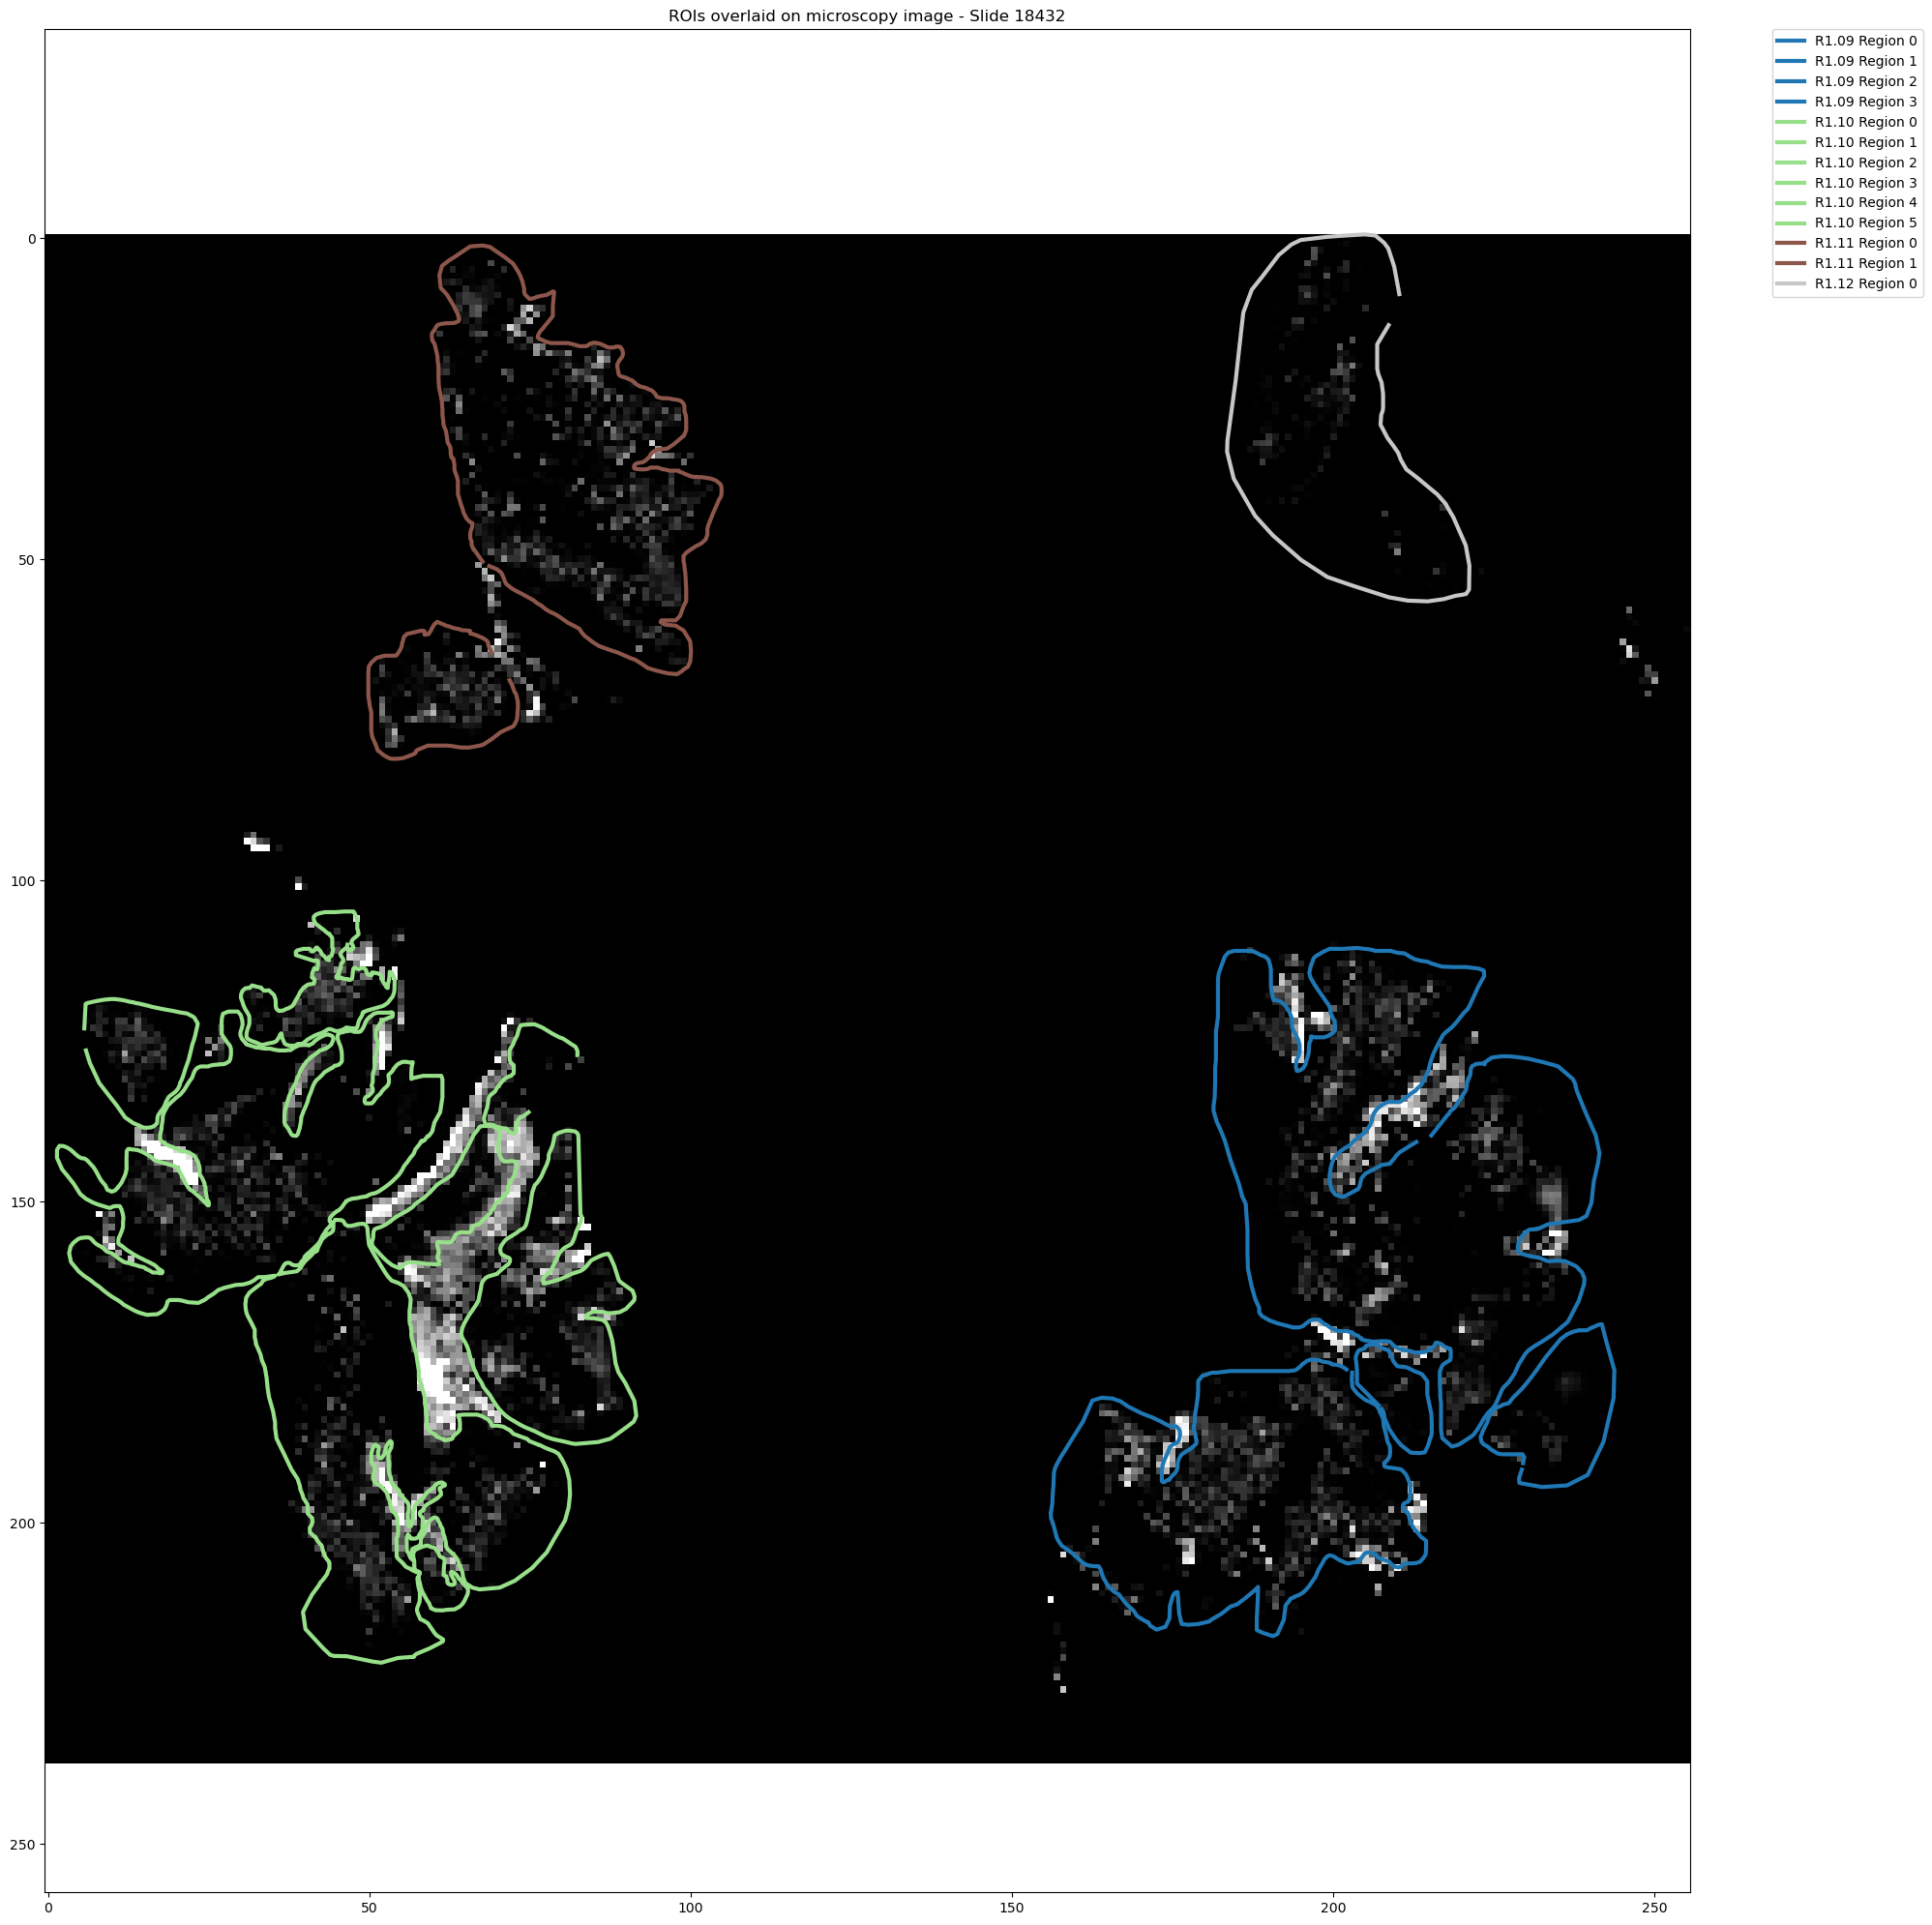

Original image shape: (112148, 54031)
Scaled image shape: (561, 270)


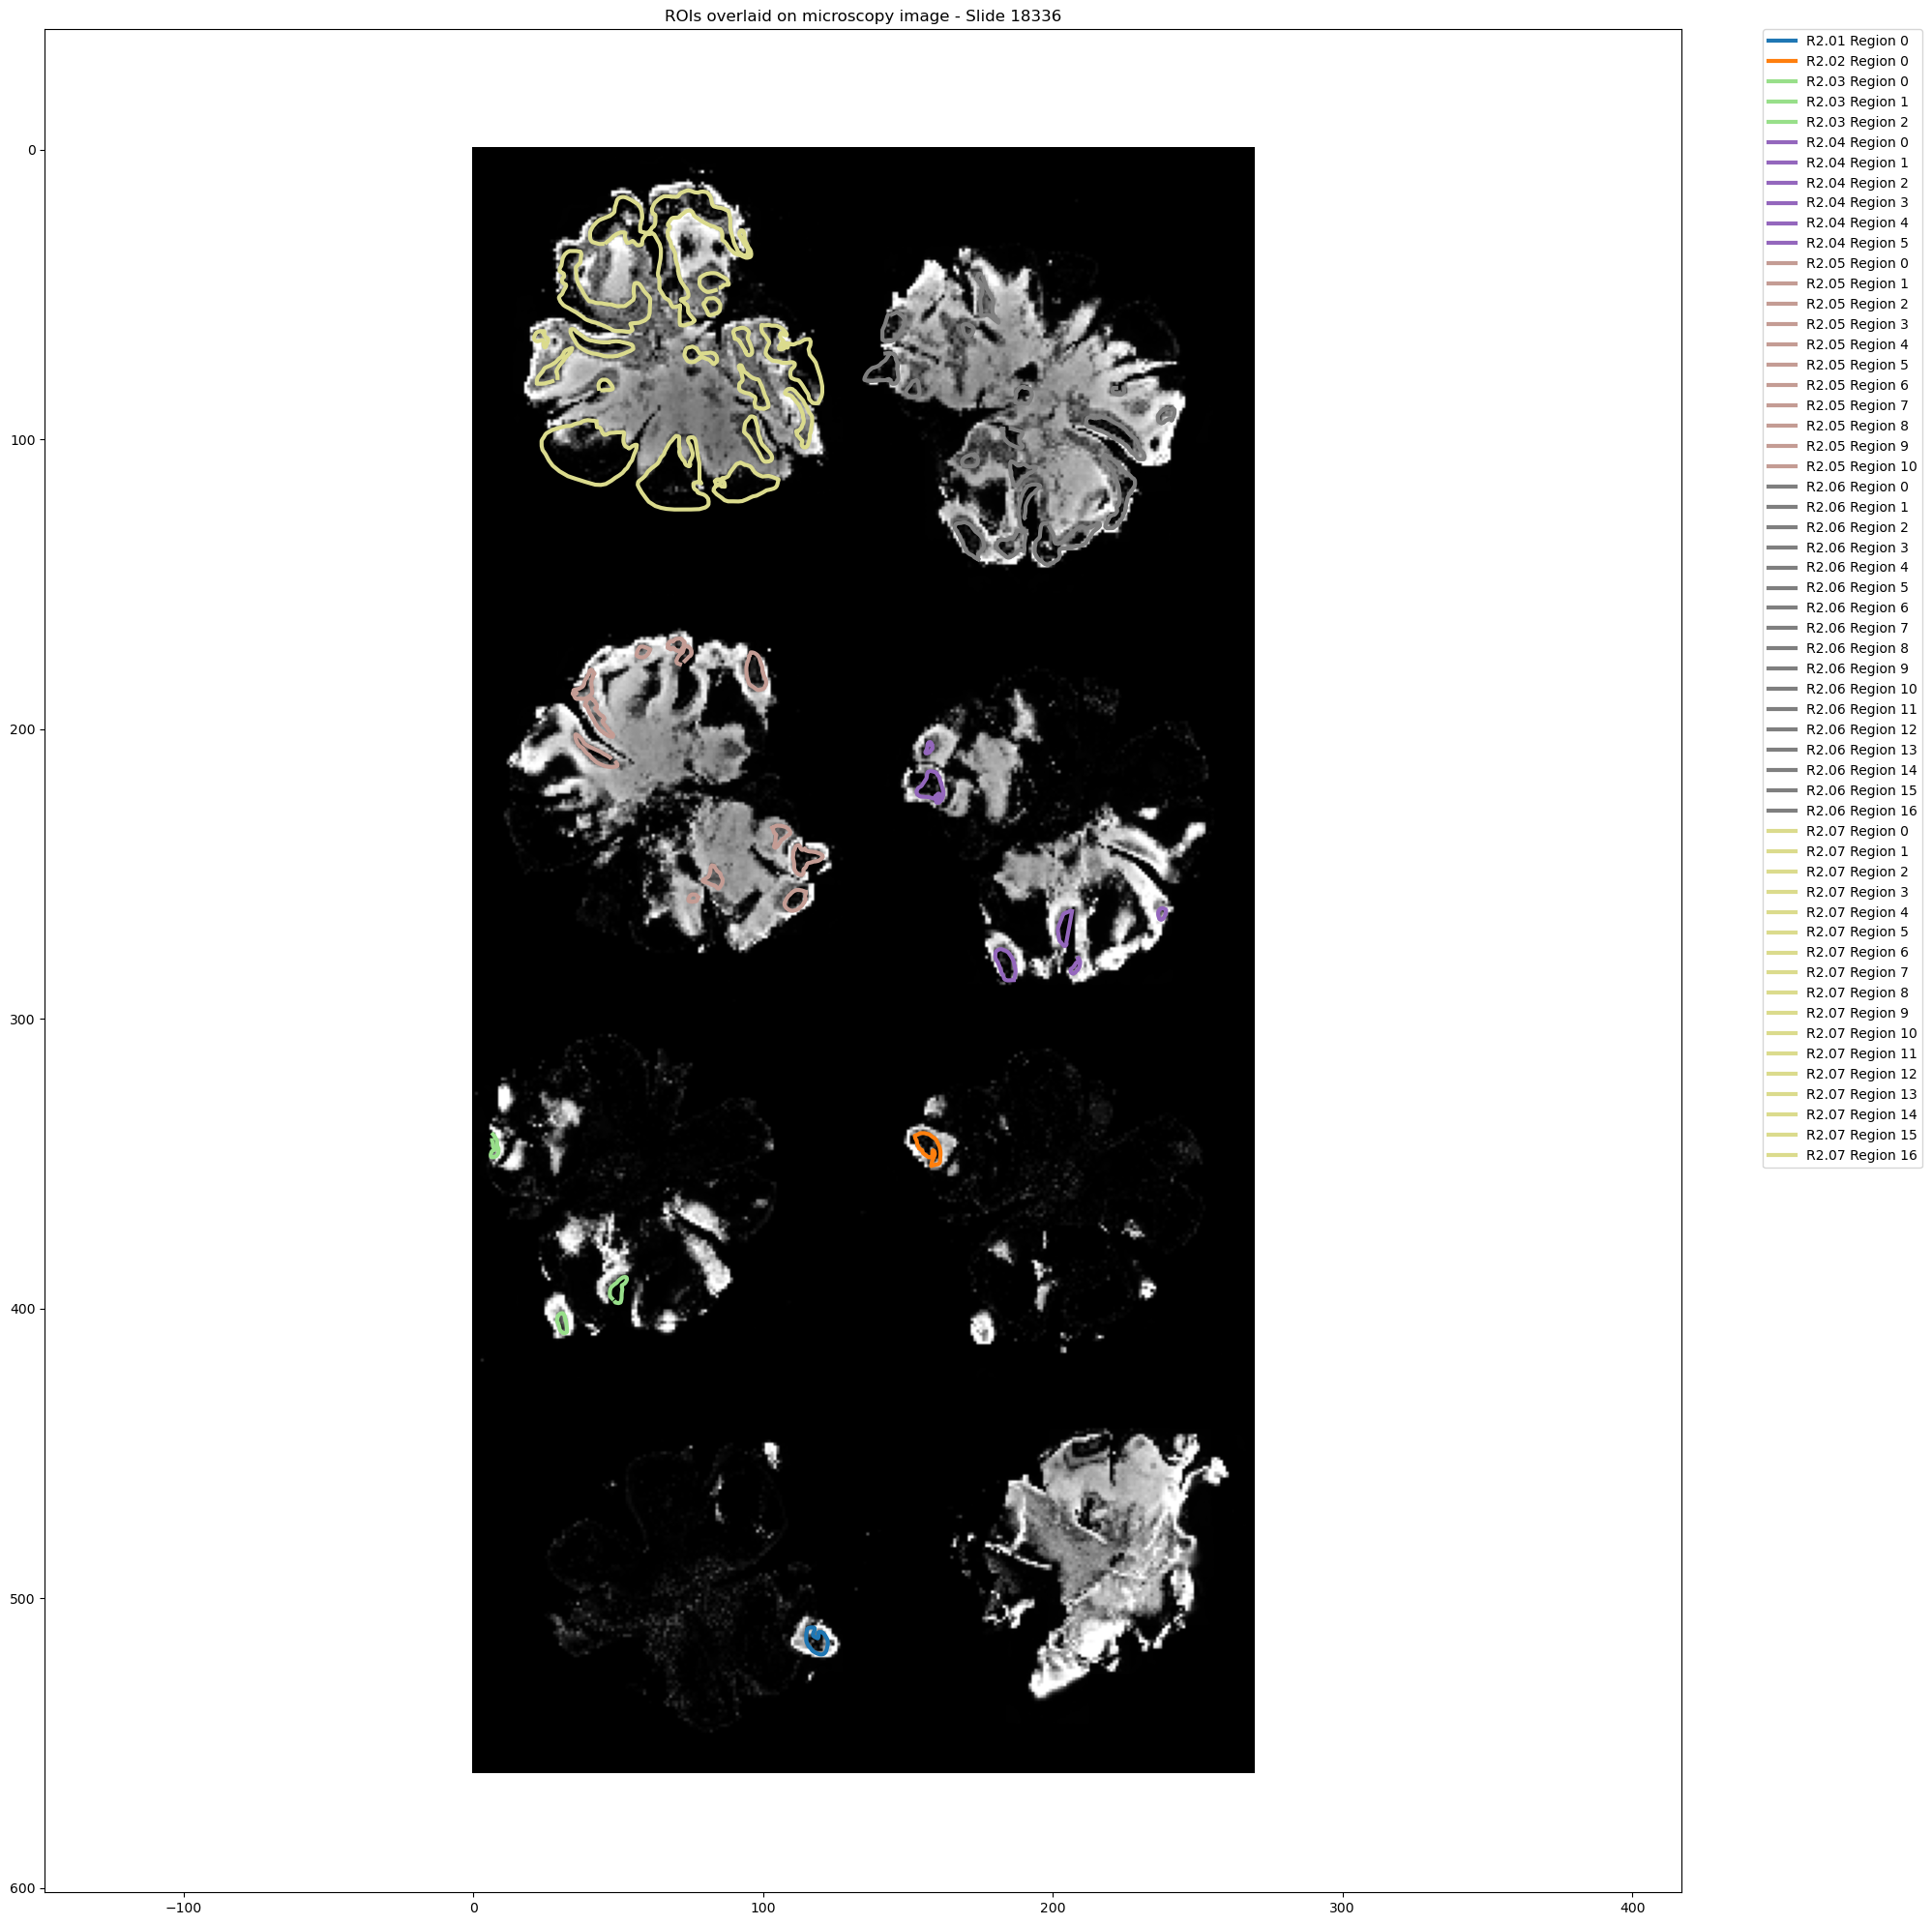

Original image shape: (112193, 54055)
Scaled image shape: (561, 270)


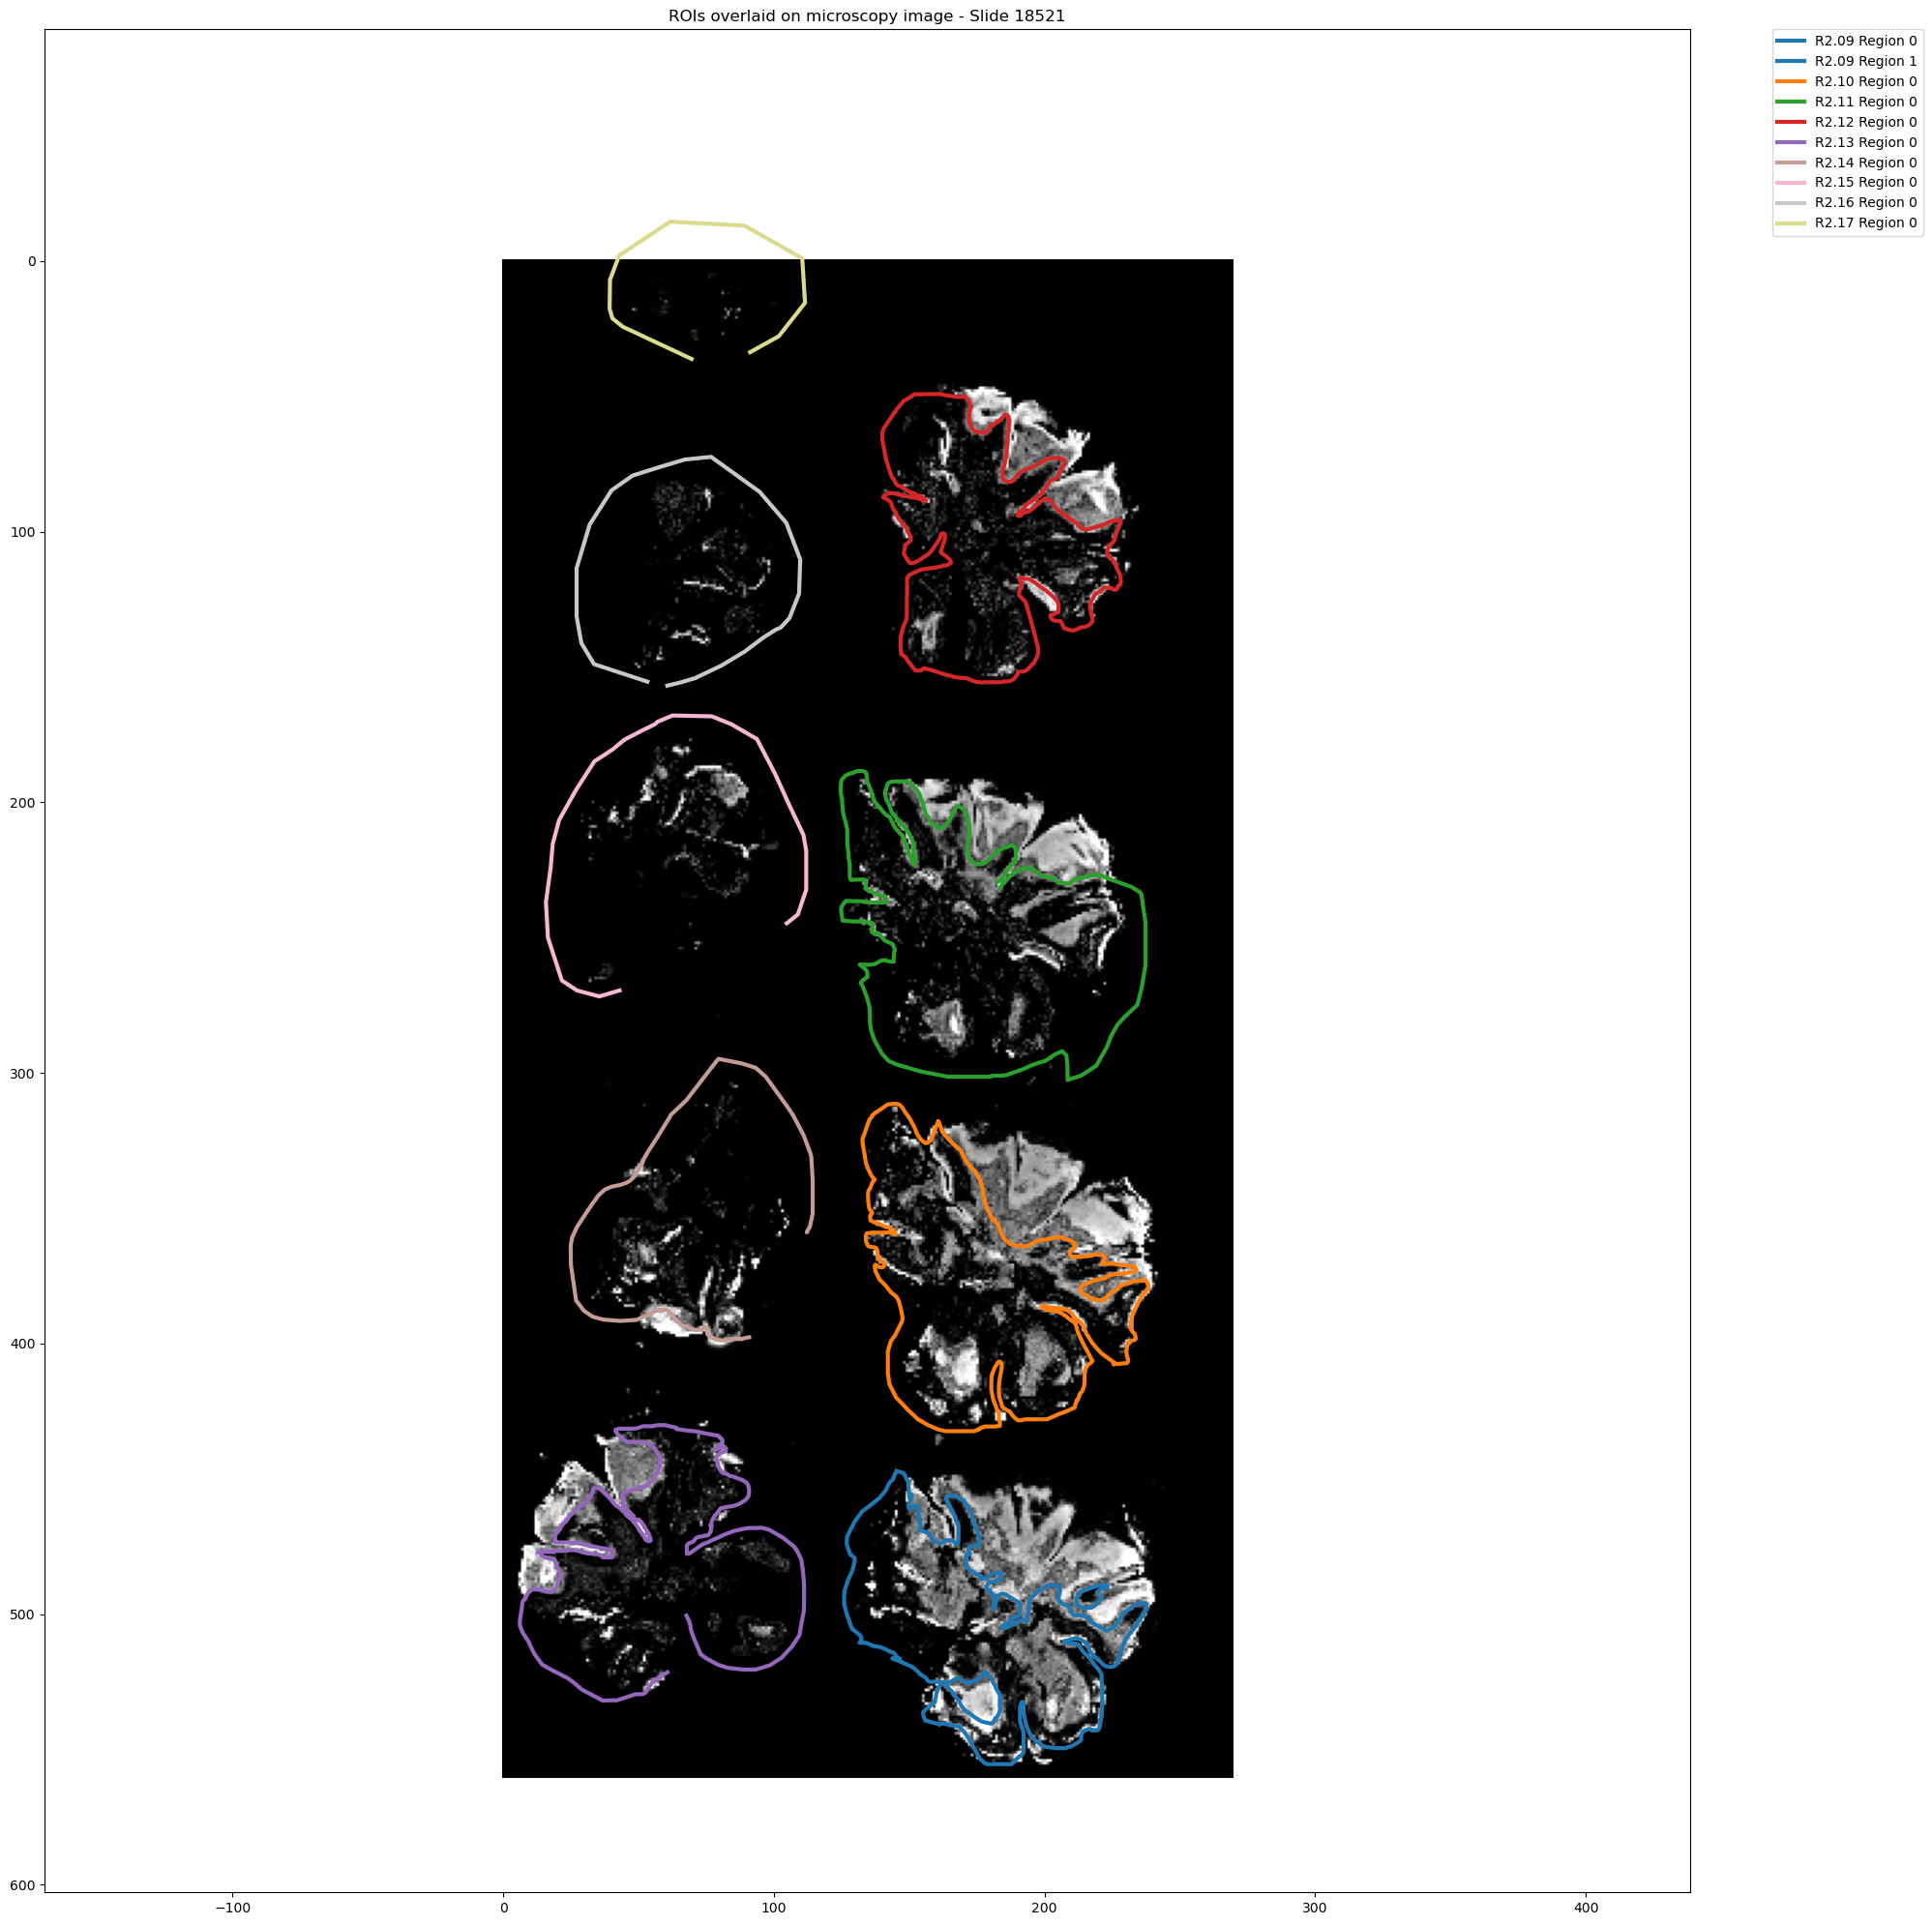

Original image shape: (101956, 48377)
Scaled image shape: (510, 242)


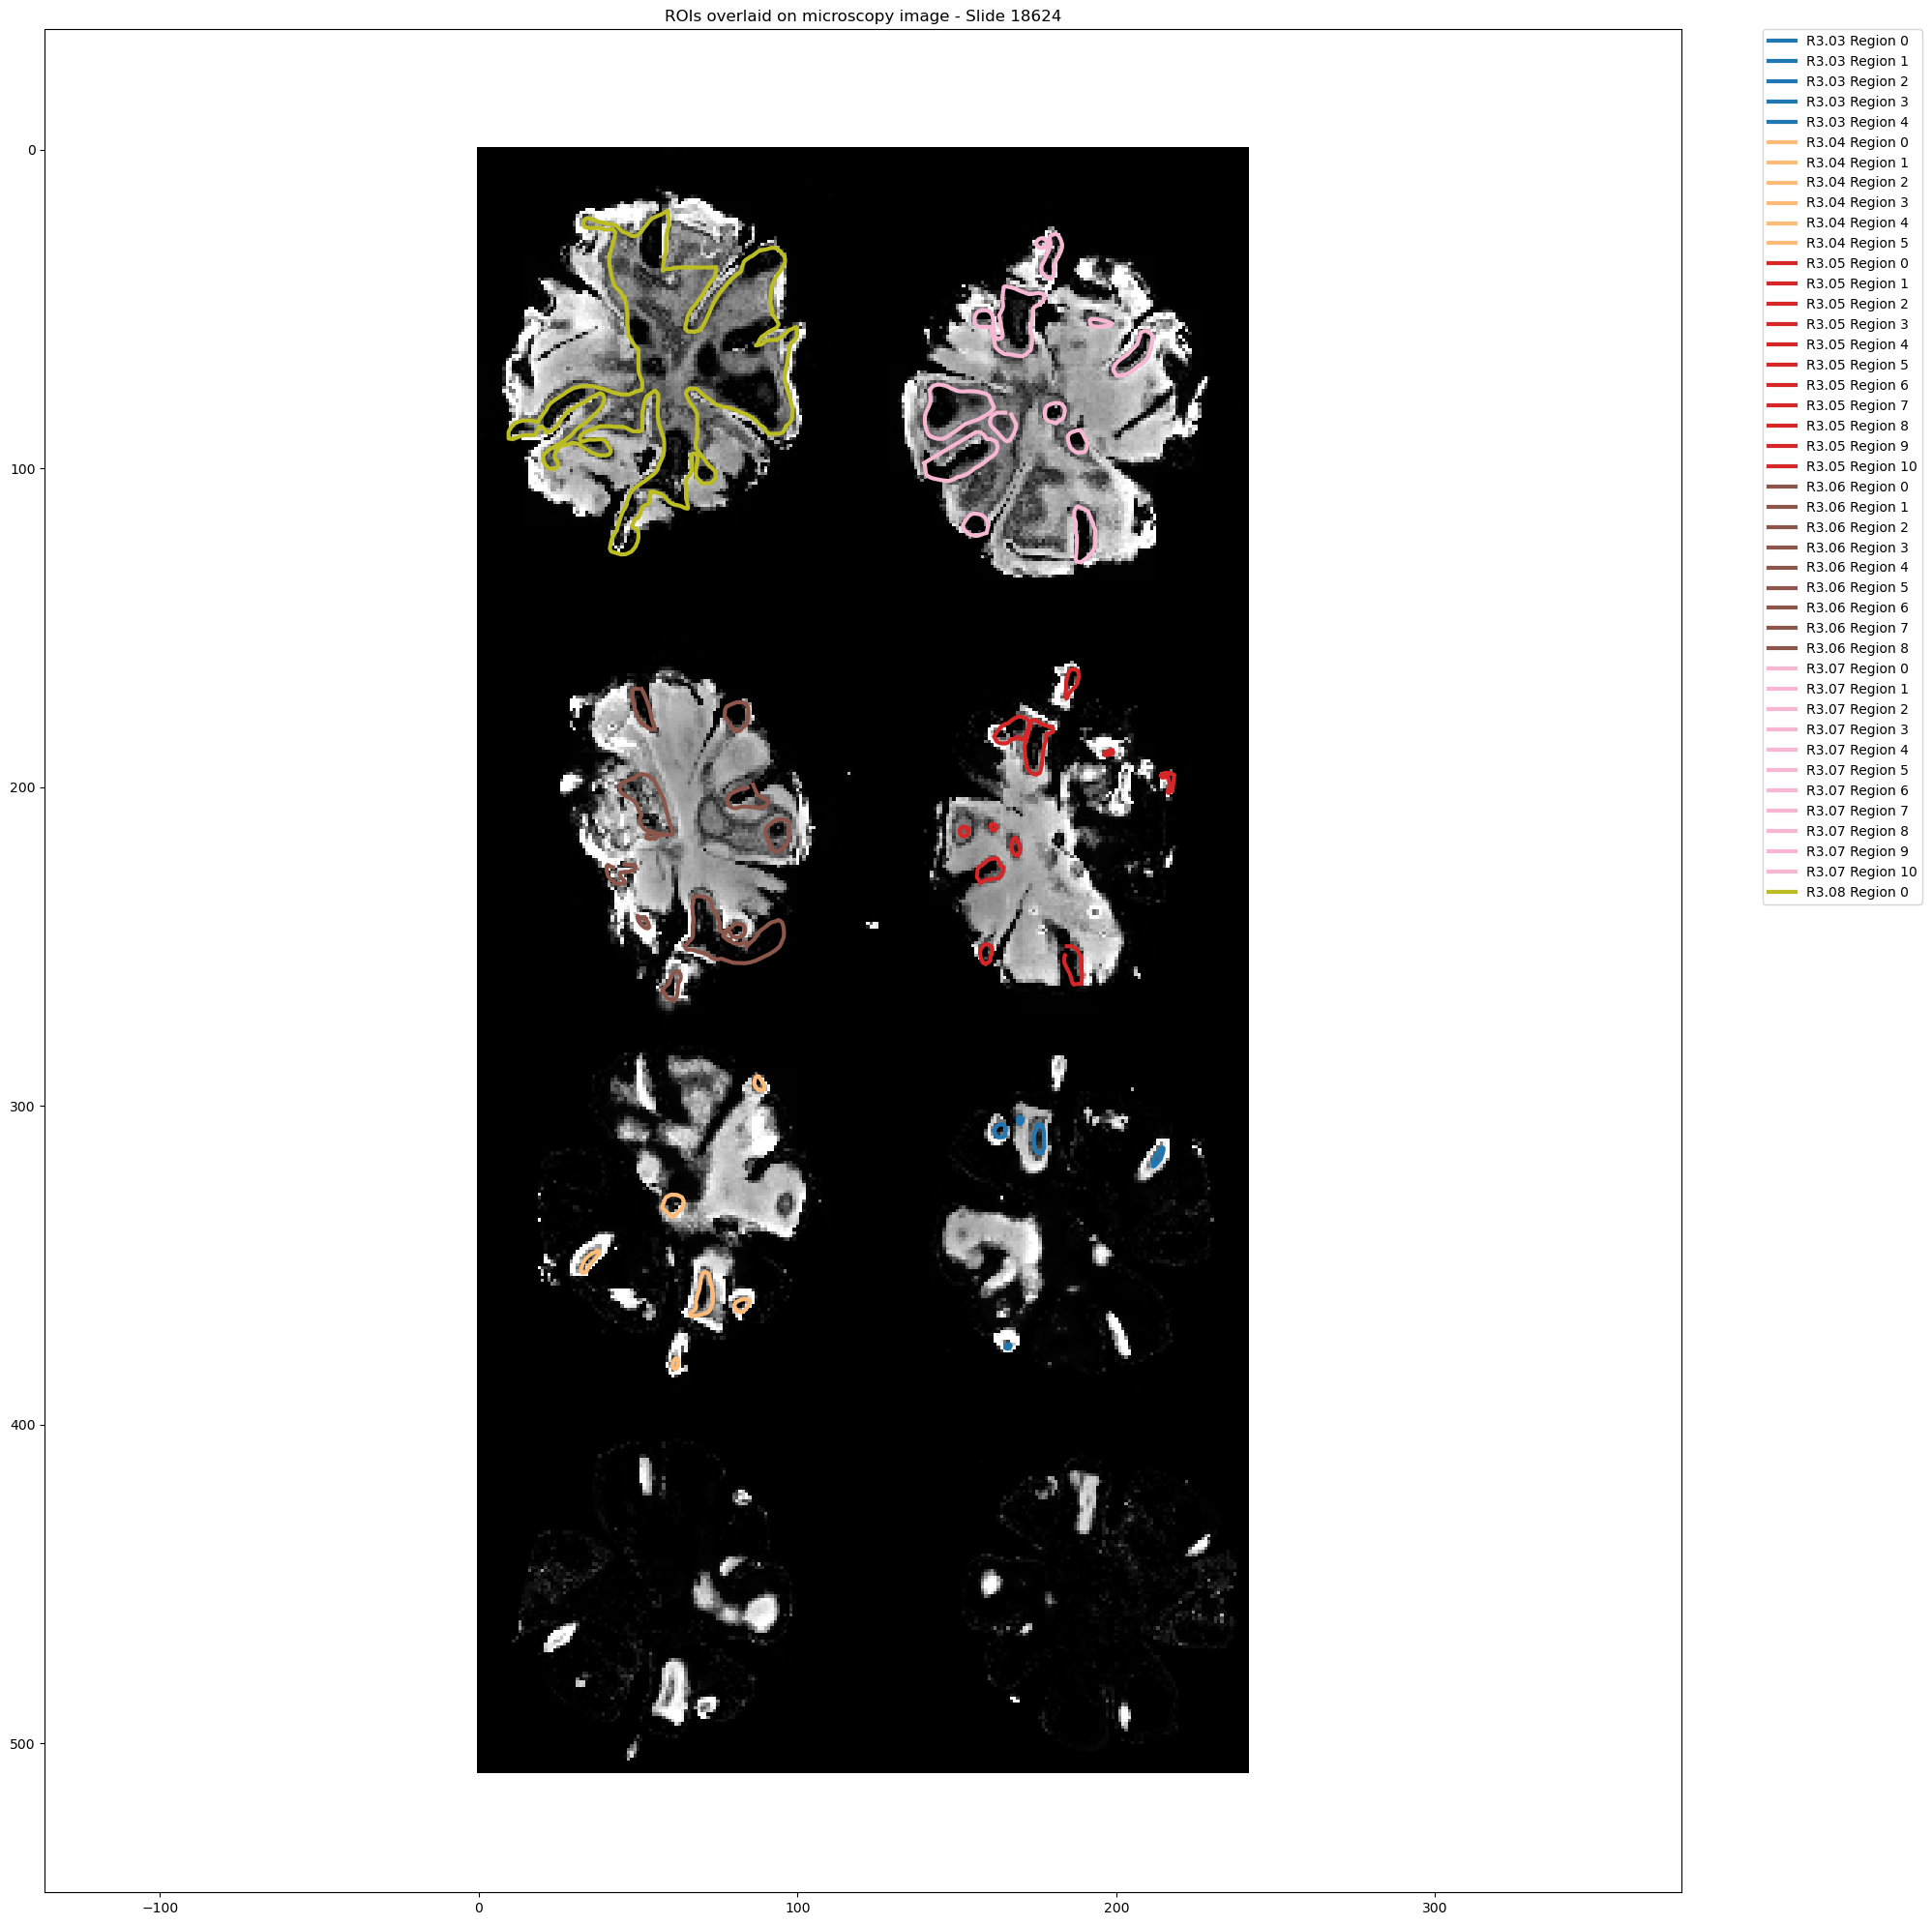

Original image shape: (108768, 51189)
Scaled image shape: (544, 256)


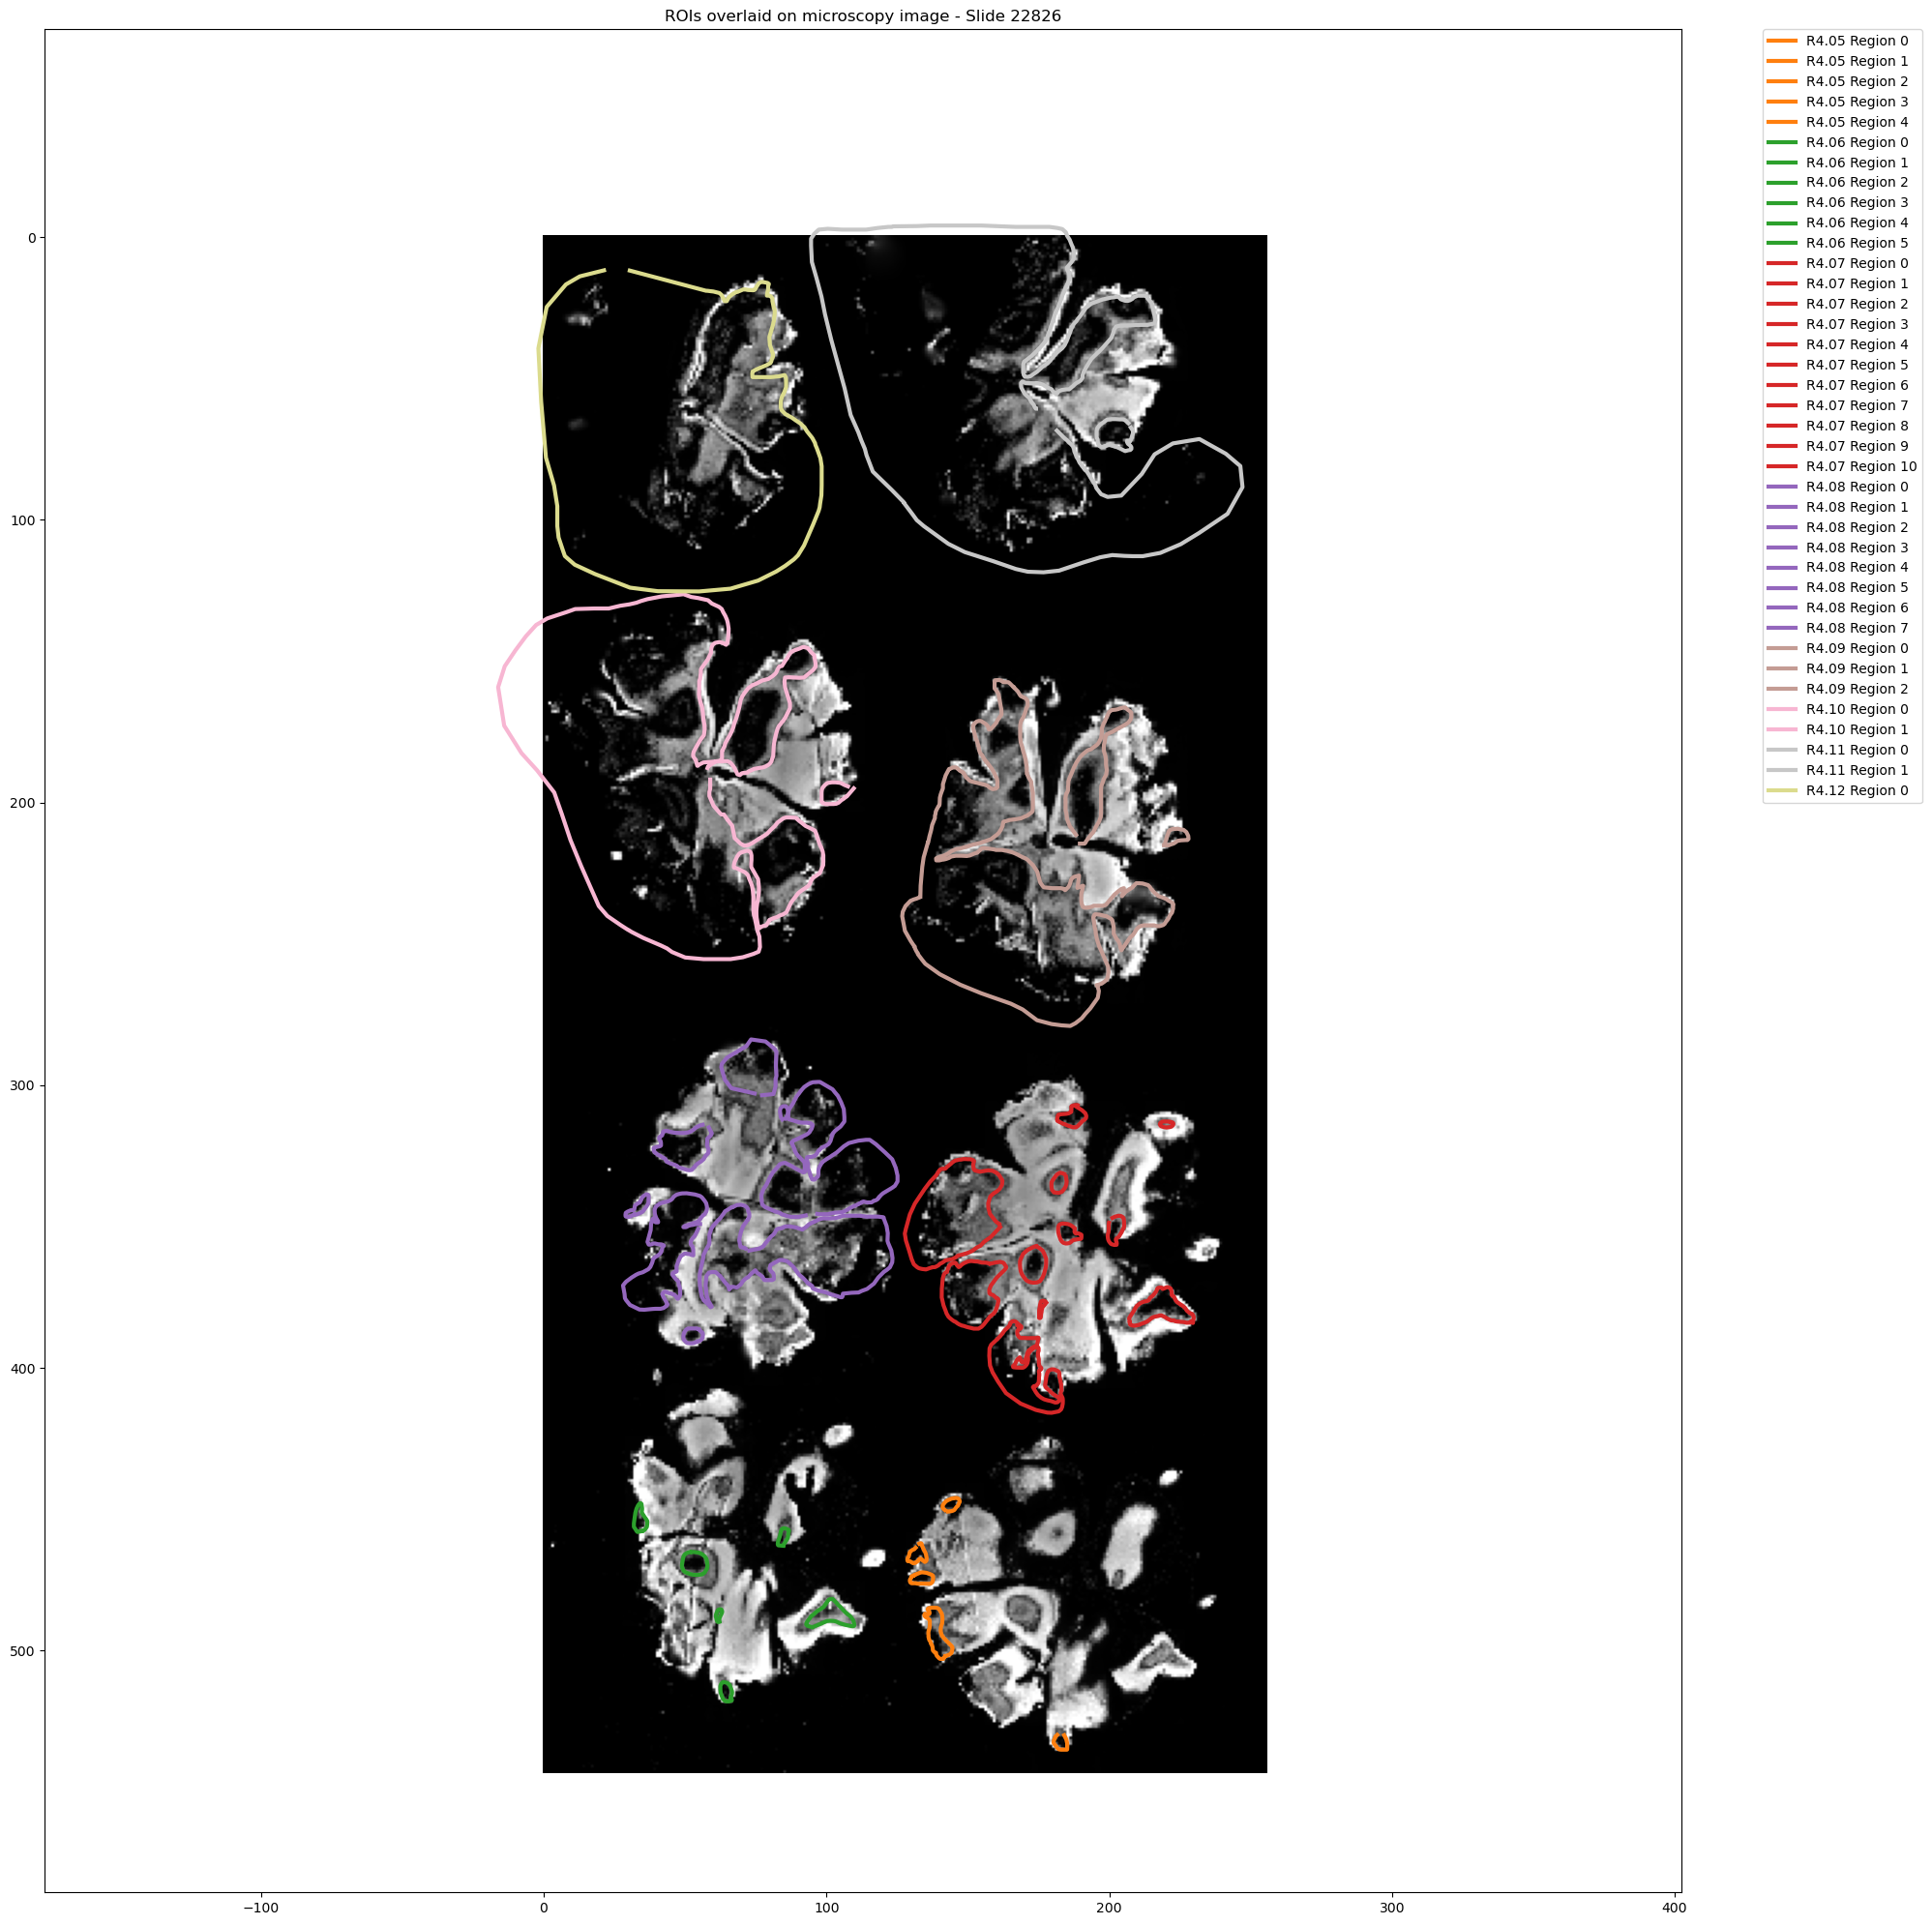

Original image shape: (105360, 51169)
Scaled image shape: (527, 256)


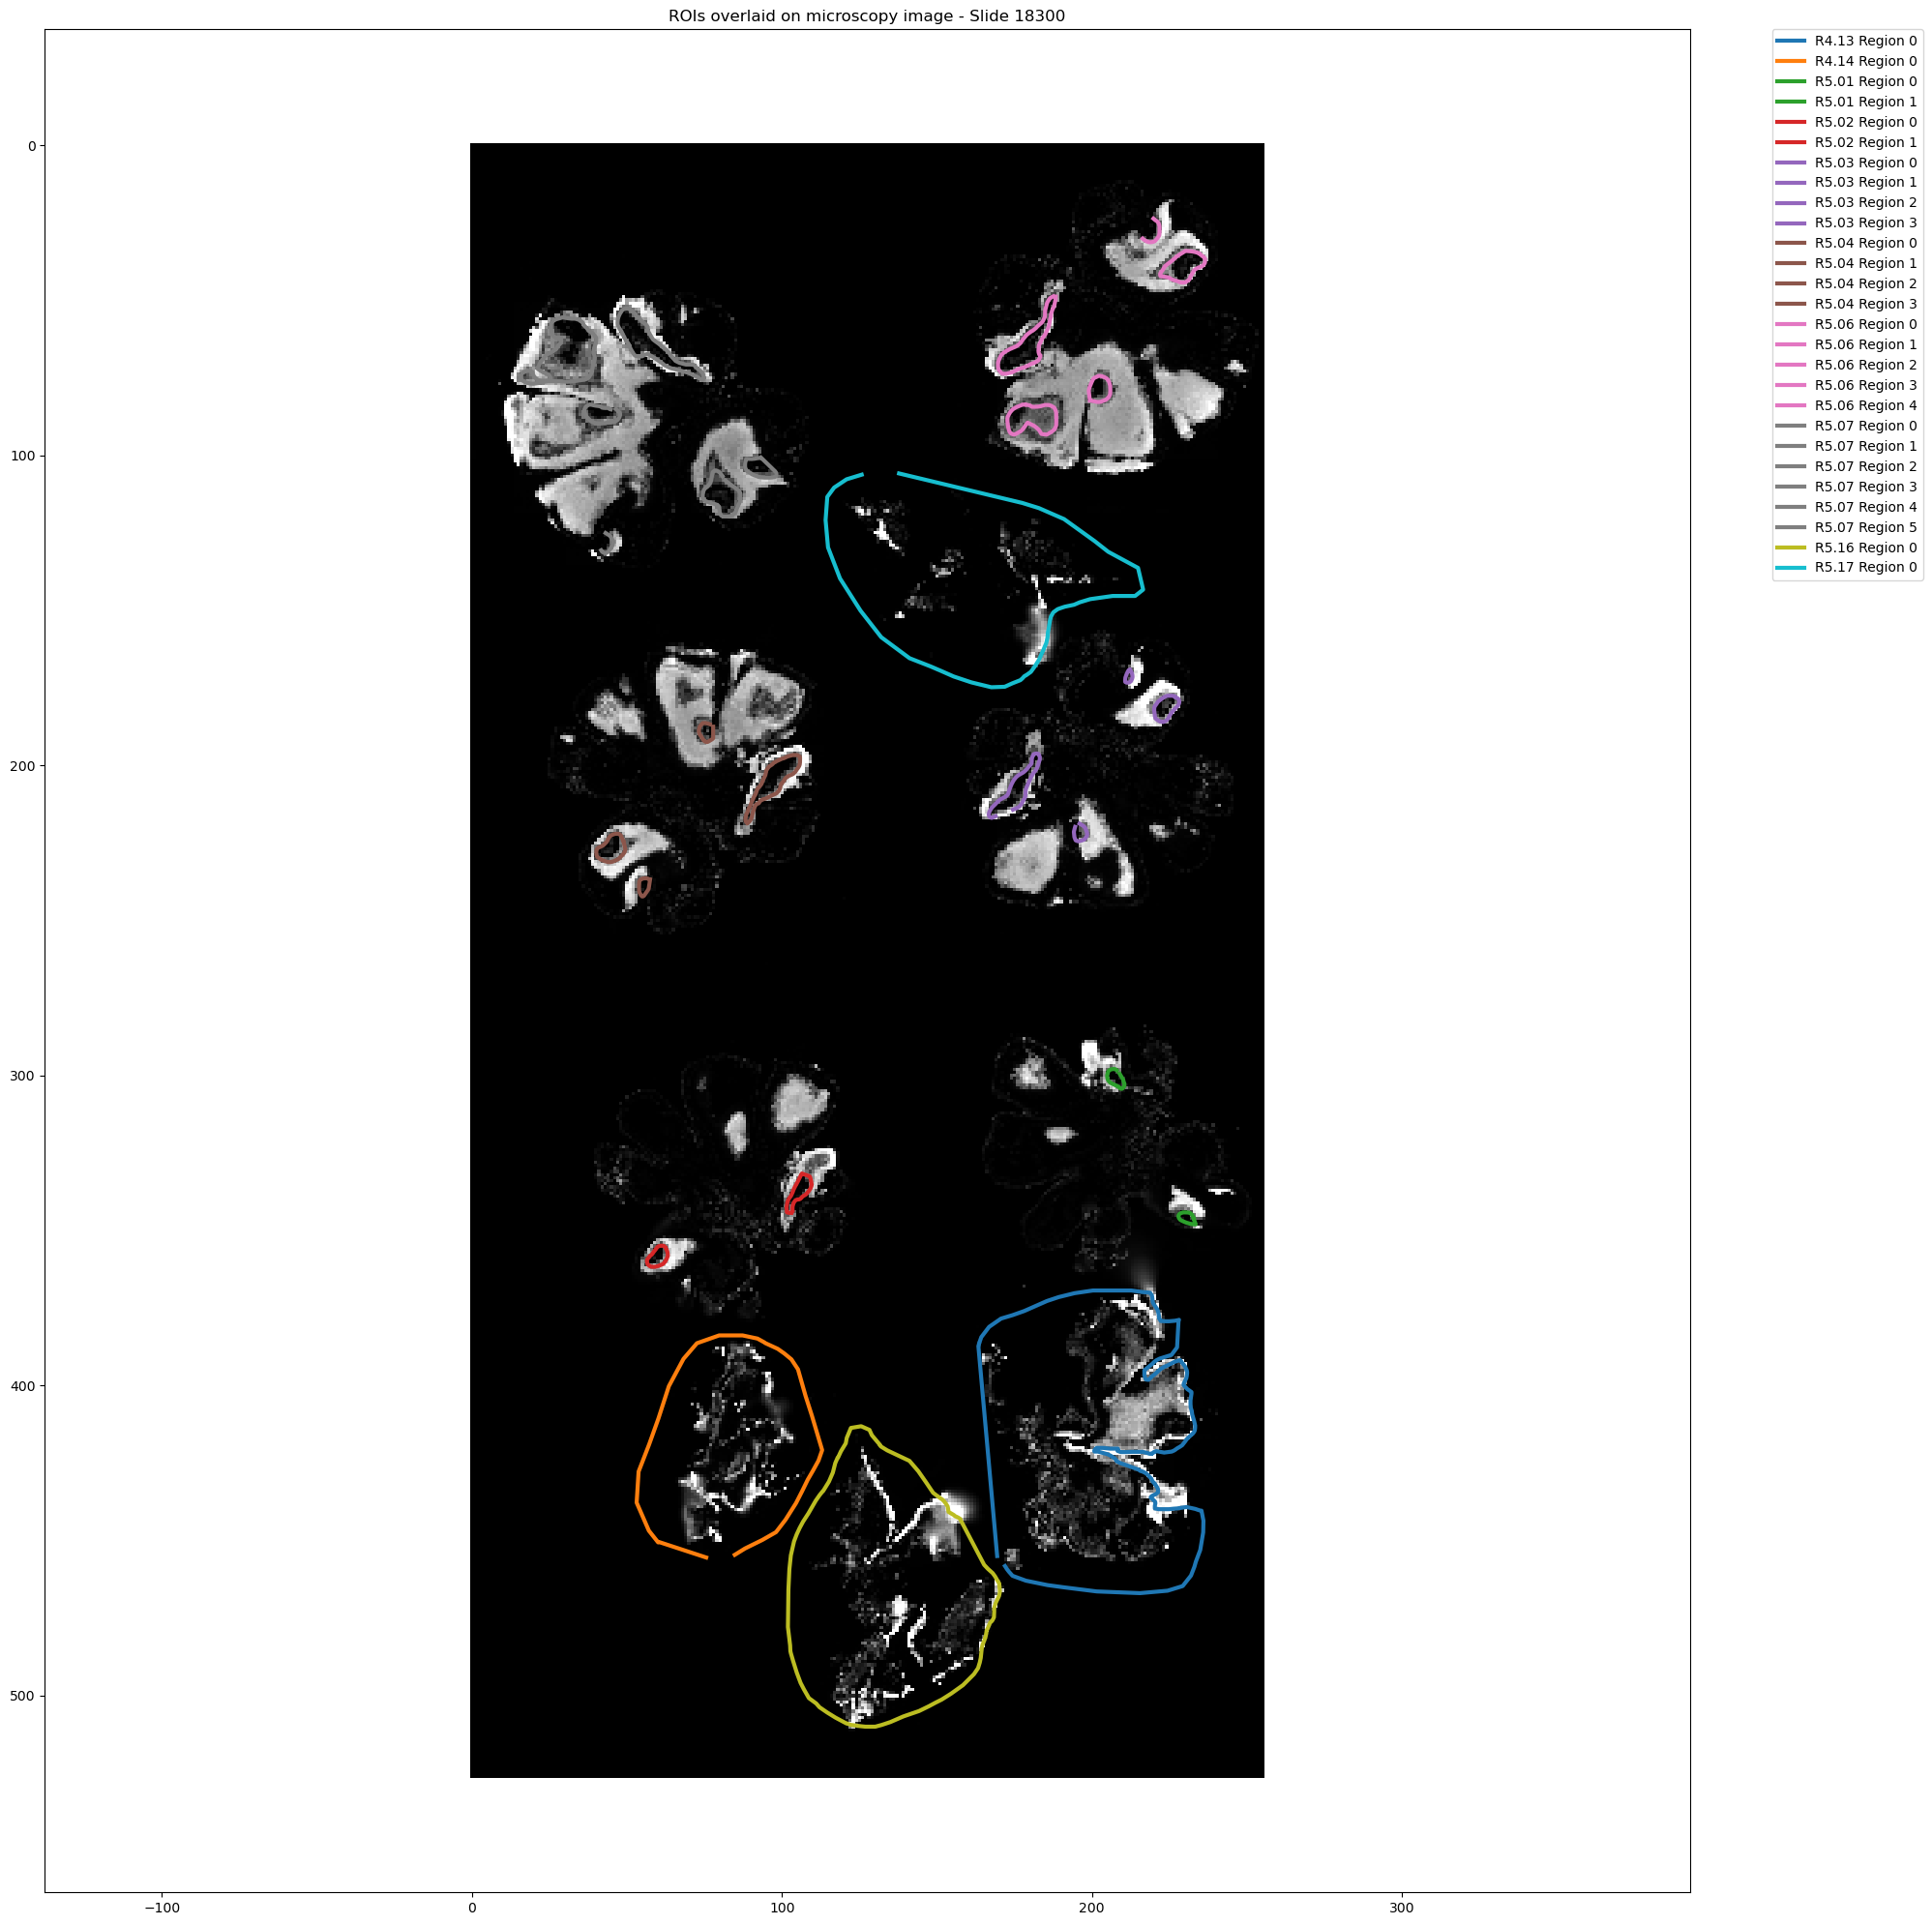

Original image shape: (105330, 54026)
Scaled image shape: (527, 270)


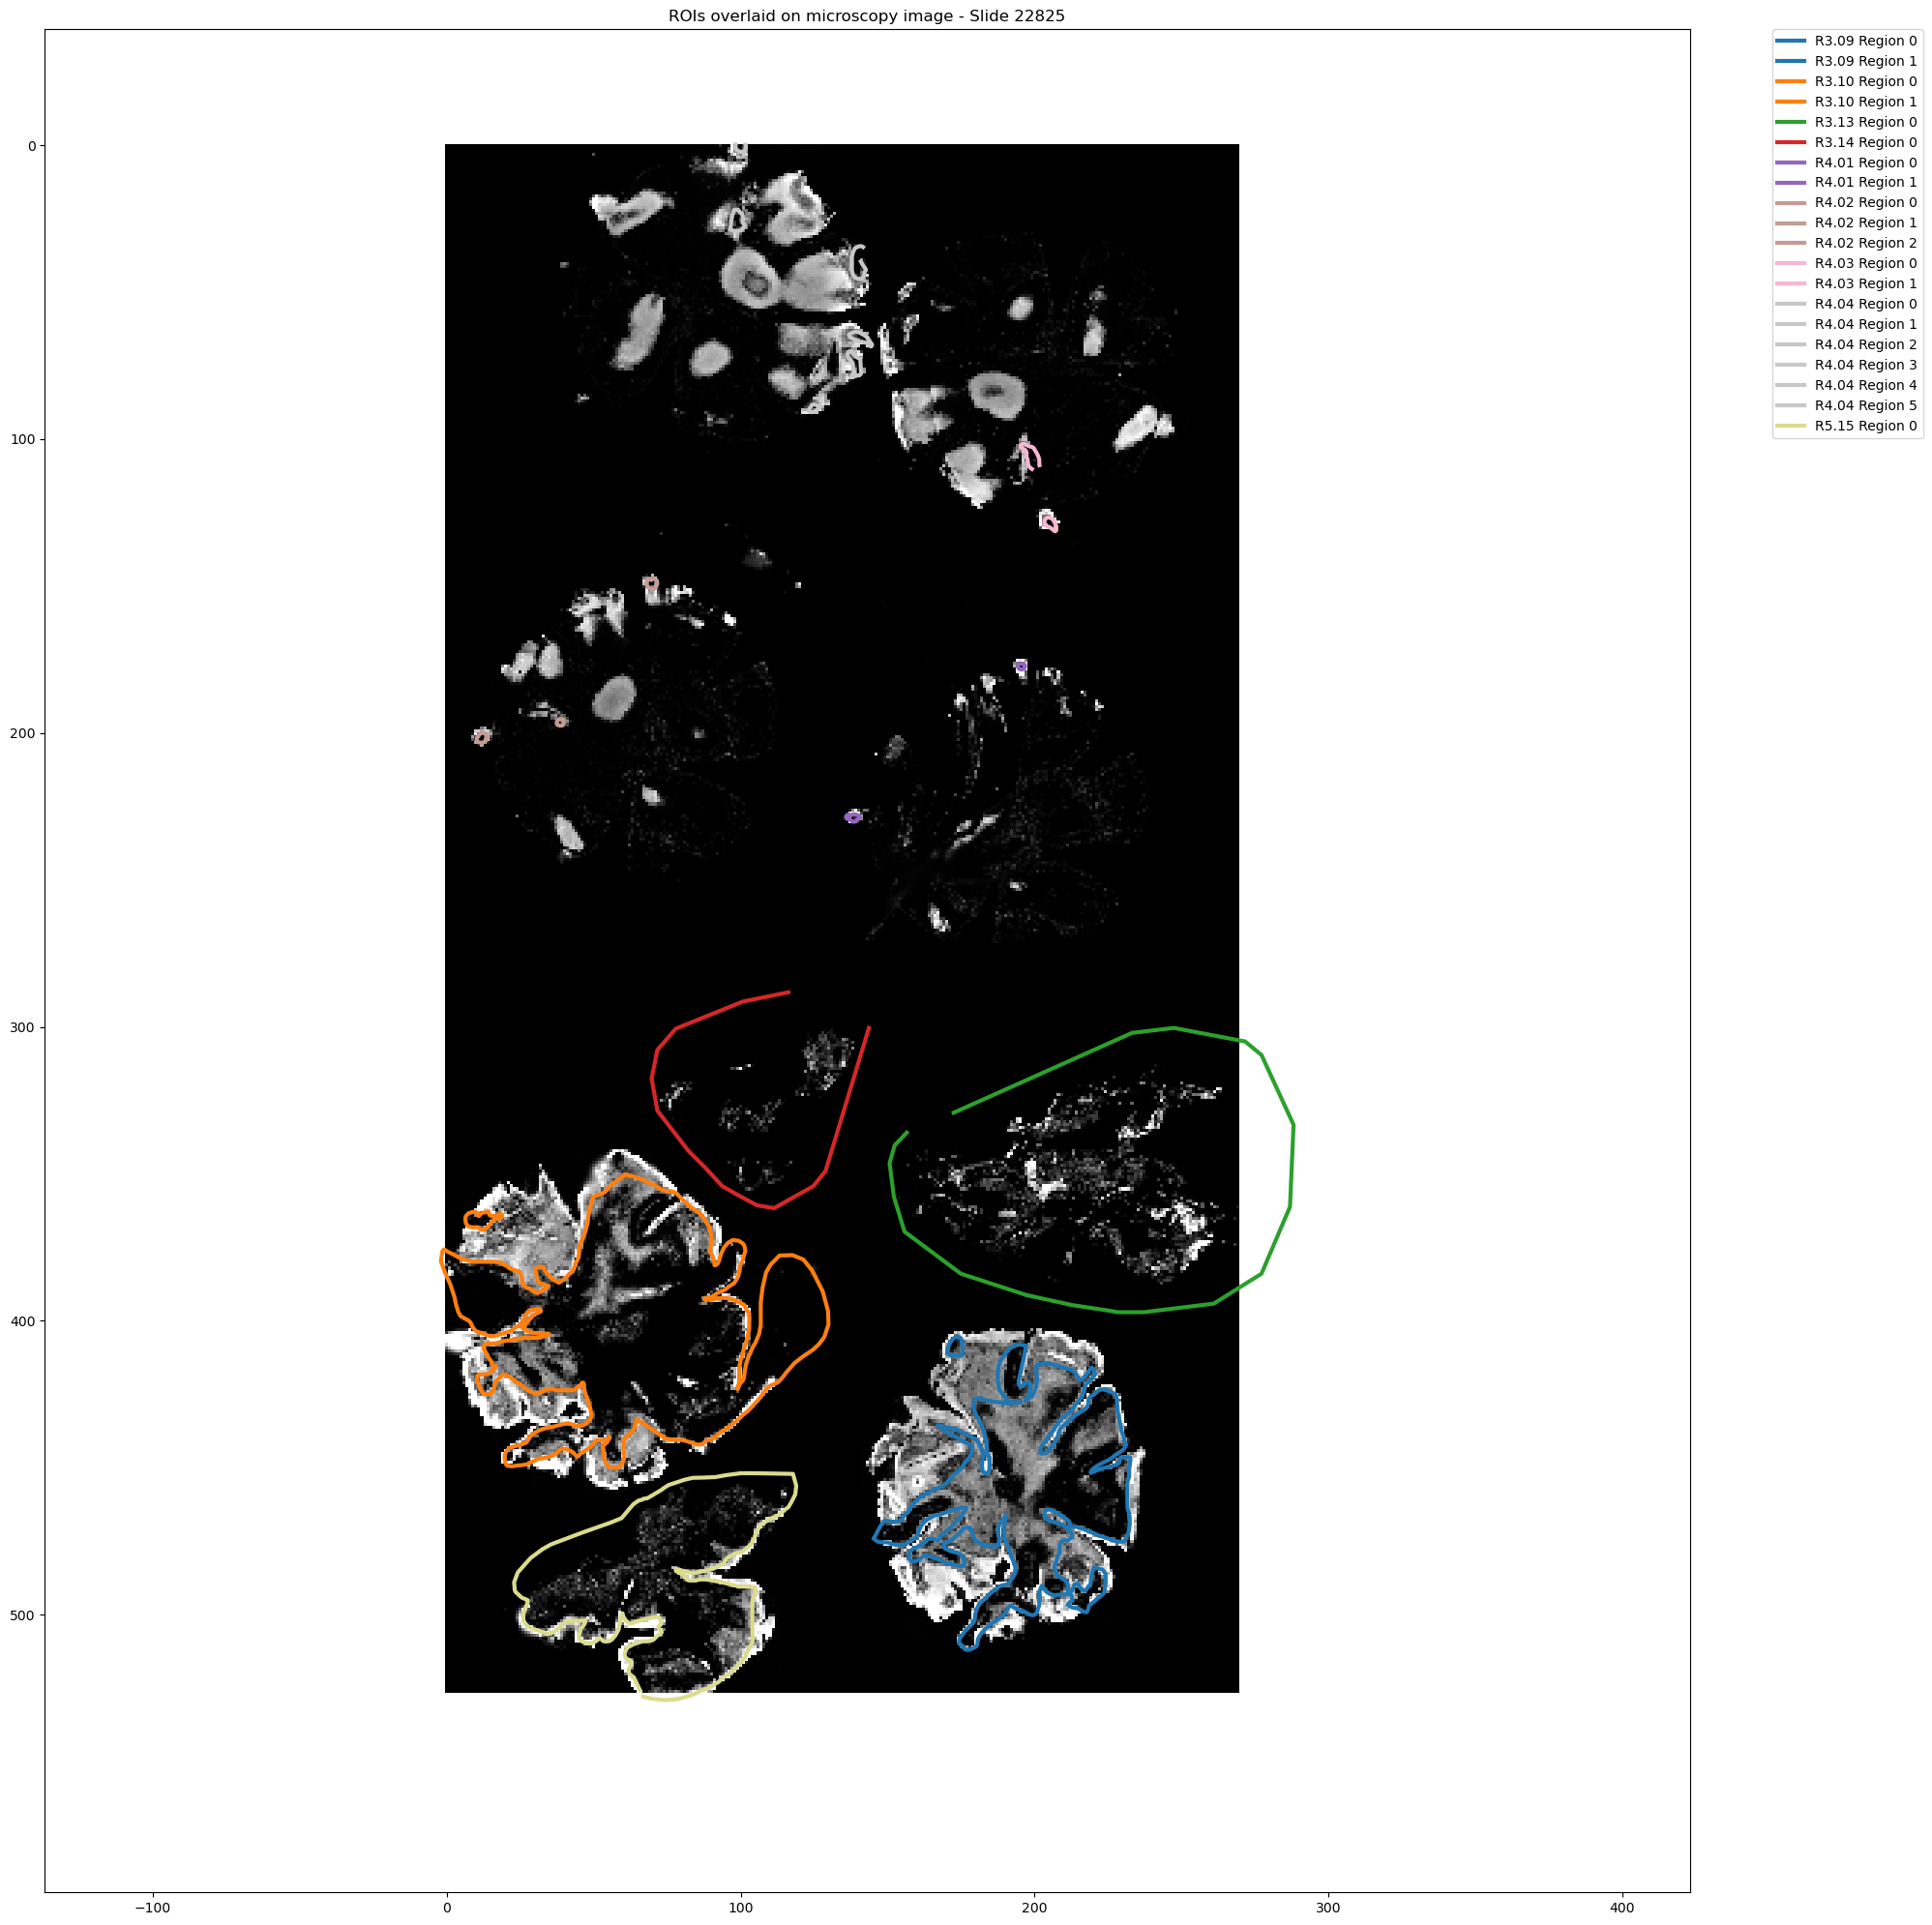

In [4]:
for i, slide in enumerate(slides):
    xen_root= os.path.join(root,xen_roots[i])

    visualize_rois_on_image(df_consolidated, slide_id=slide, xen_root=xen_root)

In [5]:
df = df_consolidated

for slide_id, xen_root in zip(slides, xen_roots):
    # combine root with paths
    xen_root = os.path.join(root,xen_root)
    # Create outputs
    output_root_i = os.path.join(output_root, slide_id)
    os.makedirs(output_root_i, exist_ok=True)
    
    # Find coordinates
    df_i = df[df['slide'] == str(slide_id)]
    if df_i.shape[0]>0:

        # load raw data
        # load transcripts
        transcript_path = os.path.join(xen_root, 'transcripts.parquet')
        print(f'Loading transcripts for {slide_id}')
        transcripts = pq.read_table(transcript_path).to_pandas()

        # Remove irrelevant features
        transcripts = transcripts[
            ~transcripts['feature_name'].str.startswith(('NegControl'))
        ]

        # Process and save subsets
        saved_paths = subsetTranscriptsByPolygons(
            transcripts=transcripts,
            df_polygons=df_i,
            output_root=output_root_i,
            slide_id=slide_id
        )

Loading transcripts for 18429


Processing regions for slide 18429:   4%|▎       | 1/27 [00:01<00:46,  1.80s/it]


Subset statistics for 18429_R1.01_region0:
Total transcripts in region: 1076628
Unique genes in region: 421
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.01_region0/transcripts.parquet



Processing regions for slide 18429:   7%|▌       | 2/27 [00:03<00:36,  1.48s/it]


Subset statistics for 18429_R1.02_region0:
Total transcripts in region: 636707
Unique genes in region: 396
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.02_region0/transcripts.parquet



Processing regions for slide 18429:  11%|▉       | 3/27 [00:06<00:52,  2.19s/it]


Subset statistics for 18429_R1.03_region0:
Total transcripts in region: 2187152
Unique genes in region: 446
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.03_region0/transcripts.parquet



Processing regions for slide 18429:  15%|█▏      | 4/27 [00:09<01:02,  2.74s/it]


Subset statistics for 18429_R1.03_region1:
Total transcripts in region: 2187414
Unique genes in region: 460
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.03_region1/transcripts.parquet



Processing regions for slide 18429:  19%|█▍      | 5/27 [00:12<01:04,  2.92s/it]


Subset statistics for 18429_R1.04_region0:
Total transcripts in region: 1943646
Unique genes in region: 451
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.04_region0/transcripts.parquet



Processing regions for slide 18429:  22%|█▊      | 6/27 [00:16<01:02,  3.00s/it]


Subset statistics for 18429_R1.04_region1:
Total transcripts in region: 2319601
Unique genes in region: 453
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.04_region1/transcripts.parquet



Processing regions for slide 18429:  26%|██      | 7/27 [00:18<00:54,  2.72s/it]


Subset statistics for 18429_R1.05_region0:
Total transcripts in region: 1671716
Unique genes in region: 436
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region0/transcripts.parquet



Processing regions for slide 18429:  30%|██▎     | 8/27 [00:20<00:51,  2.72s/it]


Subset statistics for 18429_R1.05_region1:
Total transcripts in region: 1814135
Unique genes in region: 444
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region1/transcripts.parquet



Processing regions for slide 18429:  33%|██▋     | 9/27 [00:24<00:53,  2.97s/it]


Subset statistics for 18429_R1.05_region2:
Total transcripts in region: 1955299
Unique genes in region: 440
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region2/transcripts.parquet



Processing regions for slide 18429:  37%|██▌    | 10/27 [00:26<00:46,  2.71s/it]


Subset statistics for 18429_R1.05_region3:
Total transcripts in region: 1370906
Unique genes in region: 431
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region3/transcripts.parquet



Processing regions for slide 18429:  41%|██▊    | 11/27 [00:46<02:05,  7.87s/it]


Subset statistics for 18429_R1.06_region0:
Total transcripts in region: 9308055
Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.06_region0/transcripts.parquet



Processing regions for slide 18429:  44%|███    | 12/27 [00:48<01:34,  6.33s/it]


Subset statistics for 18429_R1.06_region1:
Total transcripts in region: 1807943
Unique genes in region: 436
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.06_region1/transcripts.parquet



Processing regions for slide 18429:  48%|███▎   | 13/27 [00:51<01:10,  5.07s/it]


Subset statistics for 18429_R1.06_region2:
Total transcripts in region: 1076206
Unique genes in region: 429
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.06_region2/transcripts.parquet



Processing regions for slide 18429:  52%|███▋   | 14/27 [01:06<01:45,  8.10s/it]


Subset statistics for 18429_R1.07_region0:
Total transcripts in region: 5824092
Unique genes in region: 476
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region0/transcripts.parquet



Processing regions for slide 18429:  56%|███▉   | 15/27 [01:08<01:16,  6.38s/it]


Subset statistics for 18429_R1.07_region1:
Total transcripts in region: 1280550
Unique genes in region: 438
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region1/transcripts.parquet



Processing regions for slide 18429:  59%|████▏  | 16/27 [01:11<00:58,  5.30s/it]


Subset statistics for 18429_R1.07_region2:
Total transcripts in region: 1226332
Unique genes in region: 404
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region2/transcripts.parquet



Processing regions for slide 18429:  63%|████▍  | 17/27 [01:13<00:44,  4.47s/it]


Subset statistics for 18429_R1.07_region3:
Total transcripts in region: 1336935
Unique genes in region: 406
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region3/transcripts.parquet



Processing regions for slide 18429:  67%|████▋  | 18/27 [01:14<00:30,  3.43s/it]


Subset statistics for 18429_R1.07_region4:
Total transcripts in region: 169653
Unique genes in region: 331
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region4/transcripts.parquet



Processing regions for slide 18429:  70%|████▉  | 19/27 [01:19<00:29,  3.74s/it]


Subset statistics for 18429_R1.07_region5:
Total transcripts in region: 2195839
Unique genes in region: 450
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region5/transcripts.parquet



Processing regions for slide 18429:  74%|█████▏ | 20/27 [01:21<00:22,  3.28s/it]


Subset statistics for 18429_R1.07_region6:
Total transcripts in region: 771525
Unique genes in region: 395
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region6/transcripts.parquet


Subset statistics for 18429_R1.08_region0:
Total transcripts in region: 17796609


Processing regions for slide 18429:  78%|█████▍ | 21/27 [02:12<01:45, 17.62s/it]

Unique genes in region: 479
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region0/transcripts.parquet


Subset statistics for 18429_R1.08_region1:
Total transcripts in region: 12560042


Processing regions for slide 18429:  81%|█████▋ | 22/27 [03:27<02:53, 34.78s/it]

Unique genes in region: 479
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region1/transcripts.parquet



Processing regions for slide 18429:  85%|█████▉ | 23/27 [03:29<01:40, 25.04s/it]


Subset statistics for 18429_R1.08_region2:
Total transcripts in region: 923146
Unique genes in region: 410
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region2/transcripts.parquet



Processing regions for slide 18429:  89%|██████▏| 24/27 [03:31<00:53, 17.89s/it]


Subset statistics for 18429_R1.08_region3:
Total transcripts in region: 299632
Unique genes in region: 348
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region3/transcripts.parquet



Processing regions for slide 18429:  93%|██████▍| 25/27 [03:31<00:25, 12.77s/it]


Subset statistics for 18429_R1.08_region4:
Total transcripts in region: 116041
Unique genes in region: 331
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region4/transcripts.parquet



Processing regions for slide 18429:  96%|██████▋| 26/27 [03:32<00:09,  9.22s/it]


Subset statistics for 18429_R1.08_region5:
Total transcripts in region: 195985
Unique genes in region: 325
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region5/transcripts.parquet



Processing regions for slide 18429: 100%|███████| 27/27 [03:33<00:00,  7.91s/it]


Subset statistics for 18429_R1.08_region6:
Total transcripts in region: 14197
Unique genes in region: 285
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region6/transcripts.parquet



Loading transcripts for 18432


Processing regions for slide 18432:   8%|▌       | 1/13 [00:09<01:56,  9.67s/it]


Subset statistics for 18432_R1.09_region0:
Total transcripts in region: 6054122
Unique genes in region: 479
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.09_region0/transcripts.parquet



Processing regions for slide 18432:  15%|█▏      | 2/13 [00:10<00:48,  4.38s/it]


Subset statistics for 18432_R1.09_region1:
Total transcripts in region: 268603
Unique genes in region: 353
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.09_region1/transcripts.parquet



Processing regions for slide 18432:  23%|█▊      | 3/13 [00:10<00:25,  2.57s/it]


Subset statistics for 18432_R1.09_region2:
Total transcripts in region: 168350
Unique genes in region: 319
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.09_region2/transcripts.parquet



Processing regions for slide 18432:  31%|██▍     | 4/13 [00:15<00:31,  3.48s/it]


Subset statistics for 18432_R1.09_region3:
Total transcripts in region: 4114187
Unique genes in region: 478
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.09_region3/transcripts.parquet



Processing regions for slide 18432:  38%|███     | 5/13 [00:54<02:08, 16.10s/it]


Subset statistics for 18432_R1.10_region0:
Total transcripts in region: 6994463
Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.10_region0/transcripts.parquet



Processing regions for slide 18432:  46%|███▋    | 6/13 [00:56<01:19, 11.35s/it]


Subset statistics for 18432_R1.10_region1:
Total transcripts in region: 844188
Unique genes in region: 393
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.10_region1/transcripts.parquet



Processing regions for slide 18432:  54%|████▎   | 7/13 [00:56<00:47,  7.84s/it]


Subset statistics for 18432_R1.10_region2:
Total transcripts in region: 247566
Unique genes in region: 340
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.10_region2/transcripts.parquet



Processing regions for slide 18432:  62%|████▉   | 8/13 [00:58<00:28,  5.78s/it]


Subset statistics for 18432_R1.10_region3:
Total transcripts in region: 719926
Unique genes in region: 421
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.10_region3/transcripts.parquet



Processing regions for slide 18432:  69%|█████▌  | 9/13 [00:58<00:16,  4.20s/it]


Subset statistics for 18432_R1.10_region4:
Total transcripts in region: 693992
Unique genes in region: 420
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.10_region4/transcripts.parquet



Processing regions for slide 18432:  77%|█████▍ | 10/13 [01:01<00:11,  3.76s/it]


Subset statistics for 18432_R1.10_region5:
Total transcripts in region: 1726391
Unique genes in region: 434
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.10_region5/transcripts.parquet



Processing regions for slide 18432:  85%|█████▉ | 11/13 [01:07<00:08,  4.33s/it]


Subset statistics for 18432_R1.11_region0:
Total transcripts in region: 4768550
Unique genes in region: 476
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.11_region0/transcripts.parquet



Processing regions for slide 18432:  92%|██████▍| 12/13 [01:08<00:03,  3.35s/it]


Subset statistics for 18432_R1.11_region1:
Total transcripts in region: 1103754
Unique genes in region: 427
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.11_region1/transcripts.parquet



Processing regions for slide 18432: 100%|███████| 13/13 [01:09<00:00,  5.34s/it]


Subset statistics for 18432_R1.12_region0:
Total transcripts in region: 1028323
Unique genes in region: 403
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18432/18432_R1.12_region0/transcripts.parquet

Loading transcripts for 18336



Processing regions for slide 18336:   2%|▏       | 1/56 [00:00<00:41,  1.32it/s]


Subset statistics for 18336_R2.01_region0:
Total transcripts in region: 237847
Unique genes in region: 345
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.01_region0/transcripts.parquet



Processing regions for slide 18336:   4%|▎       | 2/56 [00:01<00:41,  1.30it/s]


Subset statistics for 18336_R2.02_region0:
Total transcripts in region: 248273
Unique genes in region: 352
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.02_region0/transcripts.parquet



Processing regions for slide 18336:   5%|▍       | 3/56 [00:02<00:36,  1.44it/s]


Subset statistics for 18336_R2.03_region0:
Total transcripts in region: 134408
Unique genes in region: 319
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.03_region0/transcripts.parquet



Processing regions for slide 18336:   7%|▌       | 4/56 [00:02<00:32,  1.58it/s]


Subset statistics for 18336_R2.03_region1:
Total transcripts in region: 60763
Unique genes in region: 313
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.03_region1/transcripts.parquet



Processing regions for slide 18336:   9%|▋       | 5/56 [00:03<00:30,  1.68it/s]


Subset statistics for 18336_R2.03_region2:
Total transcripts in region: 66949
Unique genes in region: 314
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.03_region2/transcripts.parquet



Processing regions for slide 18336:  11%|▊       | 6/56 [00:03<00:32,  1.55it/s]


Subset statistics for 18336_R2.04_region0:
Total transcripts in region: 267677
Unique genes in region: 352
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region0/transcripts.parquet



Processing regions for slide 18336:  12%|█       | 7/56 [00:04<00:30,  1.62it/s]


Subset statistics for 18336_R2.04_region1:
Total transcripts in region: 108969
Unique genes in region: 319
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region1/transcripts.parquet



Processing regions for slide 18336:  14%|█▏      | 8/56 [00:05<00:31,  1.53it/s]


Subset statistics for 18336_R2.04_region2:
Total transcripts in region: 214813
Unique genes in region: 351
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region2/transcripts.parquet



Processing regions for slide 18336:  16%|█▎      | 9/56 [00:05<00:27,  1.68it/s]


Subset statistics for 18336_R2.04_region3:
Total transcripts in region: 24864
Unique genes in region: 304
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region3/transcripts.parquet



Processing regions for slide 18336:  18%|█▎     | 10/56 [00:06<00:26,  1.76it/s]


Subset statistics for 18336_R2.04_region4:
Total transcripts in region: 74728
Unique genes in region: 315
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region4/transcripts.parquet



Processing regions for slide 18336:  20%|█▍     | 11/56 [00:06<00:24,  1.85it/s]


Subset statistics for 18336_R2.04_region5:
Total transcripts in region: 23938
Unique genes in region: 298
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region5/transcripts.parquet



Processing regions for slide 18336:  21%|█▌     | 12/56 [00:07<00:25,  1.76it/s]


Subset statistics for 18336_R2.05_region0:
Total transcripts in region: 182322
Unique genes in region: 336
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region0/transcripts.parquet



Processing regions for slide 18336:  23%|█▋     | 13/56 [00:08<00:26,  1.61it/s]


Subset statistics for 18336_R2.05_region1:
Total transcripts in region: 227858
Unique genes in region: 343
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region1/transcripts.parquet



Processing regions for slide 18336:  25%|█▊     | 14/56 [00:08<00:26,  1.60it/s]


Subset statistics for 18336_R2.05_region2:
Total transcripts in region: 165768
Unique genes in region: 357
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region2/transcripts.parquet



Processing regions for slide 18336:  27%|█▉     | 15/56 [00:09<00:24,  1.66it/s]


Subset statistics for 18336_R2.05_region3:
Total transcripts in region: 94876
Unique genes in region: 336
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region3/transcripts.parquet



Processing regions for slide 18336:  29%|██     | 16/56 [00:09<00:25,  1.55it/s]


Subset statistics for 18336_R2.05_region4:
Total transcripts in region: 317051
Unique genes in region: 361
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region4/transcripts.parquet



Processing regions for slide 18336:  30%|██▏    | 17/56 [00:10<00:25,  1.51it/s]


Subset statistics for 18336_R2.05_region5:
Total transcripts in region: 155580
Unique genes in region: 350
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region5/transcripts.parquet



Processing regions for slide 18336:  32%|██▎    | 18/56 [00:11<00:23,  1.60it/s]


Subset statistics for 18336_R2.05_region6:
Total transcripts in region: 93168
Unique genes in region: 314
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region6/transcripts.parquet



Processing regions for slide 18336:  34%|██▍    | 19/56 [00:11<00:23,  1.56it/s]


Subset statistics for 18336_R2.05_region7:
Total transcripts in region: 189702
Unique genes in region: 321
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region7/transcripts.parquet



Processing regions for slide 18336:  36%|██▌    | 20/56 [00:12<00:23,  1.52it/s]


Subset statistics for 18336_R2.05_region8:
Total transcripts in region: 203026
Unique genes in region: 333
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region8/transcripts.parquet



Processing regions for slide 18336:  38%|██▋    | 21/56 [00:13<00:24,  1.45it/s]


Subset statistics for 18336_R2.05_region9:
Total transcripts in region: 257877
Unique genes in region: 350
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region9/transcripts.parquet



Processing regions for slide 18336:  39%|██▊    | 22/56 [00:13<00:21,  1.61it/s]


Subset statistics for 18336_R2.05_region10:
Total transcripts in region: 17882
Unique genes in region: 269
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.05_region10/transcripts.parquet



Processing regions for slide 18336:  41%|██▉    | 23/56 [00:14<00:21,  1.51it/s]


Subset statistics for 18336_R2.06_region0:
Total transcripts in region: 295314
Unique genes in region: 371
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region0/transcripts.parquet



Processing regions for slide 18336:  43%|███    | 24/56 [00:15<00:20,  1.56it/s]


Subset statistics for 18336_R2.06_region1:
Total transcripts in region: 119106
Unique genes in region: 319
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region1/transcripts.parquet



Processing regions for slide 18336:  45%|███▏   | 25/56 [00:16<00:25,  1.24it/s]


Subset statistics for 18336_R2.06_region2:
Total transcripts in region: 714386
Unique genes in region: 424
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region2/transcripts.parquet



Processing regions for slide 18336:  46%|███▎   | 26/56 [00:17<00:28,  1.06it/s]


Subset statistics for 18336_R2.06_region3:
Total transcripts in region: 548979
Unique genes in region: 373
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region3/transcripts.parquet



Processing regions for slide 18336:  48%|███▍   | 27/56 [00:18<00:28,  1.02it/s]


Subset statistics for 18336_R2.06_region4:
Total transcripts in region: 466709
Unique genes in region: 367
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region4/transcripts.parquet



Processing regions for slide 18336:  50%|███▌   | 28/56 [00:19<00:23,  1.17it/s]


Subset statistics for 18336_R2.06_region5:
Total transcripts in region: 112641
Unique genes in region: 314
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region5/transcripts.parquet



Processing regions for slide 18336:  52%|███▋   | 29/56 [00:19<00:20,  1.35it/s]


Subset statistics for 18336_R2.06_region6:
Total transcripts in region: 35810
Unique genes in region: 302
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region6/transcripts.parquet



Processing regions for slide 18336:  54%|███▊   | 30/56 [00:20<00:20,  1.29it/s]


Subset statistics for 18336_R2.06_region7:
Total transcripts in region: 367153
Unique genes in region: 368
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region7/transcripts.parquet



Processing regions for slide 18336:  55%|███▉   | 31/56 [00:21<00:19,  1.31it/s]


Subset statistics for 18336_R2.06_region8:
Total transcripts in region: 279031
Unique genes in region: 338
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region8/transcripts.parquet



Processing regions for slide 18336:  57%|████   | 32/56 [00:21<00:17,  1.37it/s]


Subset statistics for 18336_R2.06_region9:
Total transcripts in region: 188600
Unique genes in region: 329
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region9/transcripts.parquet



Processing regions for slide 18336:  59%|████▏  | 33/56 [00:22<00:15,  1.49it/s]


Subset statistics for 18336_R2.06_region10:
Total transcripts in region: 95153
Unique genes in region: 315
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region10/transcripts.parquet



Processing regions for slide 18336:  61%|████▎  | 34/56 [00:23<00:13,  1.60it/s]


Subset statistics for 18336_R2.06_region11:
Total transcripts in region: 83702
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region11/transcripts.parquet



Processing regions for slide 18336:  62%|████▍  | 35/56 [00:23<00:12,  1.69it/s]


Subset statistics for 18336_R2.06_region12:
Total transcripts in region: 72259
Unique genes in region: 317
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region12/transcripts.parquet



Processing regions for slide 18336:  64%|████▌  | 36/56 [00:24<00:11,  1.74it/s]


Subset statistics for 18336_R2.06_region13:
Total transcripts in region: 103629
Unique genes in region: 341
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region13/transcripts.parquet



Processing regions for slide 18336:  66%|████▋  | 37/56 [00:24<00:11,  1.69it/s]


Subset statistics for 18336_R2.06_region14:
Total transcripts in region: 142331
Unique genes in region: 332
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region14/transcripts.parquet



Processing regions for slide 18336:  68%|████▊  | 38/56 [00:25<00:10,  1.75it/s]


Subset statistics for 18336_R2.06_region15:
Total transcripts in region: 107095
Unique genes in region: 326
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region15/transcripts.parquet



Processing regions for slide 18336:  70%|████▉  | 39/56 [00:25<00:10,  1.61it/s]


Subset statistics for 18336_R2.06_region16:
Total transcripts in region: 285089
Unique genes in region: 393
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.06_region16/transcripts.parquet



Processing regions for slide 18336:  71%|█████  | 40/56 [00:37<01:02,  3.92s/it]


Subset statistics for 18336_R2.07_region0:
Total transcripts in region: 3155799
Unique genes in region: 447
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region0/transcripts.parquet



Processing regions for slide 18336:  73%|█████▏ | 41/56 [00:41<00:57,  3.80s/it]


Subset statistics for 18336_R2.07_region1:
Total transcripts in region: 2037224
Unique genes in region: 426
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region1/transcripts.parquet



Processing regions for slide 18336:  75%|█████▎ | 42/56 [00:42<00:42,  3.00s/it]


Subset statistics for 18336_R2.07_region2:
Total transcripts in region: 460783
Unique genes in region: 340
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region2/transcripts.parquet



Processing regions for slide 18336:  77%|█████▍ | 43/56 [00:43<00:31,  2.39s/it]


Subset statistics for 18336_R2.07_region3:
Total transcripts in region: 422307
Unique genes in region: 361
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region3/transcripts.parquet



Processing regions for slide 18336:  79%|█████▌ | 44/56 [00:44<00:26,  2.20s/it]


Subset statistics for 18336_R2.07_region4:
Total transcripts in region: 1620337
Unique genes in region: 439
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region4/transcripts.parquet



Processing regions for slide 18336:  80%|█████▋ | 45/56 [00:46<00:21,  1.94s/it]


Subset statistics for 18336_R2.07_region5:
Total transcripts in region: 789010
Unique genes in region: 397
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region5/transcripts.parquet



Processing regions for slide 18336:  82%|█████▊ | 46/56 [00:47<00:16,  1.61s/it]


Subset statistics for 18336_R2.07_region6:
Total transcripts in region: 423149
Unique genes in region: 357
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region6/transcripts.parquet



Processing regions for slide 18336:  84%|█████▉ | 47/56 [00:47<00:12,  1.35s/it]


Subset statistics for 18336_R2.07_region7:
Total transcripts in region: 244662
Unique genes in region: 358
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region7/transcripts.parquet



Processing regions for slide 18336:  86%|██████ | 48/56 [00:48<00:09,  1.19s/it]


Subset statistics for 18336_R2.07_region8:
Total transcripts in region: 351991
Unique genes in region: 395
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region8/transcripts.parquet



Processing regions for slide 18336:  88%|██████▏| 49/56 [00:50<00:09,  1.37s/it]


Subset statistics for 18336_R2.07_region9:
Total transcripts in region: 1000952
Unique genes in region: 421
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region9/transcripts.parquet



Processing regions for slide 18336:  89%|██████▎| 50/56 [00:51<00:07,  1.21s/it]


Subset statistics for 18336_R2.07_region10:
Total transcripts in region: 289597
Unique genes in region: 363
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region10/transcripts.parquet



Processing regions for slide 18336:  91%|██████▍| 51/56 [00:52<00:05,  1.05s/it]


Subset statistics for 18336_R2.07_region11:
Total transcripts in region: 197231
Unique genes in region: 322
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region11/transcripts.parquet



Processing regions for slide 18336:  93%|██████▌| 52/56 [00:52<00:03,  1.10it/s]


Subset statistics for 18336_R2.07_region12:
Total transcripts in region: 124075
Unique genes in region: 323
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region12/transcripts.parquet



Processing regions for slide 18336:  95%|██████▋| 53/56 [00:53<00:02,  1.21it/s]


Subset statistics for 18336_R2.07_region13:
Total transcripts in region: 173234
Unique genes in region: 326
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region13/transcripts.parquet



Processing regions for slide 18336:  96%|██████▊| 54/56 [00:53<00:01,  1.26it/s]


Subset statistics for 18336_R2.07_region14:
Total transcripts in region: 288062
Unique genes in region: 341
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region14/transcripts.parquet



Processing regions for slide 18336:  98%|██████▉| 55/56 [00:54<00:00,  1.37it/s]


Subset statistics for 18336_R2.07_region15:
Total transcripts in region: 127040
Unique genes in region: 324
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region15/transcripts.parquet



Processing regions for slide 18336: 100%|███████| 56/56 [00:55<00:00,  1.02it/s]


Subset statistics for 18336_R2.07_region16:
Total transcripts in region: 46681
Unique genes in region: 306
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region16/transcripts.parquet

Loading transcripts for 18521



Processing regions for slide 18521:   0%|                | 0/10 [00:00<?, ?it/s]


Subset statistics for 18521_R2.09_region0:
Total transcripts in region: 24362521


Processing regions for slide 18521:  10%|▊       | 1/10 [00:50<07:32, 50.31s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.09_region0/transcripts.parquet



Processing regions for slide 18521:  20%|█▌      | 2/10 [00:51<02:53, 21.67s/it]


Subset statistics for 18521_R2.09_region1:
Total transcripts in region: 310060
Unique genes in region: 339
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.09_region1/transcripts.parquet


Subset statistics for 18521_R2.10_region0:
Total transcripts in region: 27346787


Processing regions for slide 18521:  30%|██▍     | 3/10 [01:36<03:44, 32.04s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.10_region0/transcripts.parquet


Subset statistics for 18521_R2.11_region0:
Total transcripts in region: 24676916


Processing regions for slide 18521:  40%|███▏    | 4/10 [02:10<03:17, 32.86s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.11_region0/transcripts.parquet


Subset statistics for 18521_R2.12_region0:
Total transcripts in region: 18987779


Processing regions for slide 18521:  50%|████    | 5/10 [02:47<02:52, 34.41s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.12_region0/transcripts.parquet


Subset statistics for 18521_R2.13_region0:
Total transcripts in region: 15050589


Processing regions for slide 18521:  60%|████▊   | 6/10 [03:14<02:07, 31.79s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.13_region0/transcripts.parquet



Processing regions for slide 18521:  70%|█████▌  | 7/10 [03:20<01:10, 23.52s/it]


Subset statistics for 18521_R2.14_region0:
Total transcripts in region: 7362557
Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.14_region0/transcripts.parquet



Processing regions for slide 18521:  80%|██████▍ | 8/10 [03:25<00:35, 17.59s/it]


Subset statistics for 18521_R2.15_region0:
Total transcripts in region: 6684237
Unique genes in region: 479
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.15_region0/transcripts.parquet



Processing regions for slide 18521:  90%|███████▏| 9/10 [03:29<00:13, 13.27s/it]


Subset statistics for 18521_R2.16_region0:
Total transcripts in region: 5057213
Unique genes in region: 478
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.16_region0/transcripts.parquet



Processing regions for slide 18521: 100%|███████| 10/10 [03:30<00:00, 21.04s/it]


Subset statistics for 18521_R2.17_region0:
Total transcripts in region: 376041
Unique genes in region: 400
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.17_region0/transcripts.parquet



Loading transcripts for 18624


Processing regions for slide 18624:   2%|▏       | 1/43 [00:00<00:17,  2.38it/s]


Subset statistics for 18624_R3.03_region0:
Total transcripts in region: 18050
Unique genes in region: 294
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.03_region0/transcripts.parquet



Processing regions for slide 18624:   5%|▎       | 2/43 [00:00<00:18,  2.19it/s]


Subset statistics for 18624_R3.03_region1:
Total transcripts in region: 76251
Unique genes in region: 342
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.03_region1/transcripts.parquet



Processing regions for slide 18624:   7%|▌       | 3/43 [00:01<00:17,  2.31it/s]


Subset statistics for 18624_R3.03_region2:
Total transcripts in region: 13125
Unique genes in region: 281
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.03_region2/transcripts.parquet



Processing regions for slide 18624:   9%|▋       | 4/43 [00:01<00:16,  2.30it/s]


Subset statistics for 18624_R3.03_region3:
Total transcripts in region: 69267
Unique genes in region: 315
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.03_region3/transcripts.parquet



Processing regions for slide 18624:  12%|▉       | 5/43 [00:02<00:18,  2.03it/s]


Subset statistics for 18624_R3.03_region4:
Total transcripts in region: 209436
Unique genes in region: 334
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.03_region4/transcripts.parquet



Processing regions for slide 18624:  14%|█       | 6/43 [00:02<00:17,  2.14it/s]


Subset statistics for 18624_R3.04_region0:
Total transcripts in region: 40626
Unique genes in region: 299
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.04_region0/transcripts.parquet



Processing regions for slide 18624:  16%|█▎      | 7/43 [00:03<00:20,  1.73it/s]


Subset statistics for 18624_R3.04_region1:
Total transcripts in region: 360753
Unique genes in region: 377
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.04_region1/transcripts.parquet



Processing regions for slide 18624:  19%|█▍      | 8/43 [00:04<00:18,  1.85it/s]


Subset statistics for 18624_R3.04_region2:
Total transcripts in region: 67217
Unique genes in region: 309
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.04_region2/transcripts.parquet



Processing regions for slide 18624:  21%|█▋      | 9/43 [00:04<00:18,  1.85it/s]


Subset statistics for 18624_R3.04_region3:
Total transcripts in region: 112407
Unique genes in region: 329
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.04_region3/transcripts.parquet



Processing regions for slide 18624:  23%|█▋     | 10/43 [00:04<00:16,  1.97it/s]


Subset statistics for 18624_R3.04_region4:
Total transcripts in region: 46726
Unique genes in region: 312
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.04_region4/transcripts.parquet



Processing regions for slide 18624:  26%|█▊     | 11/43 [00:05<00:16,  1.91it/s]


Subset statistics for 18624_R3.04_region5:
Total transcripts in region: 153779
Unique genes in region: 324
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.04_region5/transcripts.parquet



Processing regions for slide 18624:  28%|█▉     | 12/43 [00:05<00:15,  2.02it/s]


Subset statistics for 18624_R3.05_region0:
Total transcripts in region: 40724
Unique genes in region: 310
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region0/transcripts.parquet



Processing regions for slide 18624:  30%|██     | 13/43 [00:06<00:16,  1.83it/s]


Subset statistics for 18624_R3.05_region1:
Total transcripts in region: 270106
Unique genes in region: 378
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region1/transcripts.parquet



Processing regions for slide 18624:  33%|██▎    | 14/43 [00:07<00:15,  1.92it/s]


Subset statistics for 18624_R3.05_region2:
Total transcripts in region: 77871
Unique genes in region: 323
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region2/transcripts.parquet



Processing regions for slide 18624:  35%|██▍    | 15/43 [00:07<00:14,  1.95it/s]


Subset statistics for 18624_R3.05_region3:
Total transcripts in region: 116860
Unique genes in region: 348
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region3/transcripts.parquet



Processing regions for slide 18624:  37%|██▌    | 16/43 [00:08<00:13,  2.04it/s]


Subset statistics for 18624_R3.05_region4:
Total transcripts in region: 36962
Unique genes in region: 302
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region4/transcripts.parquet



Processing regions for slide 18624:  40%|██▊    | 17/43 [00:08<00:12,  2.15it/s]


Subset statistics for 18624_R3.05_region5:
Total transcripts in region: 36743
Unique genes in region: 302
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region5/transcripts.parquet



Processing regions for slide 18624:  42%|██▉    | 18/43 [00:08<00:11,  2.26it/s]


Subset statistics for 18624_R3.05_region6:
Total transcripts in region: 10415
Unique genes in region: 260
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region6/transcripts.parquet



Processing regions for slide 18624:  44%|███    | 19/43 [00:09<00:14,  1.71it/s]


Subset statistics for 18624_R3.05_region7:
Total transcripts in region: 510984
Unique genes in region: 362
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region7/transcripts.parquet



Processing regions for slide 18624:  47%|███▎   | 20/43 [00:10<00:12,  1.78it/s]


Subset statistics for 18624_R3.05_region8:
Total transcripts in region: 126416
Unique genes in region: 332
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region8/transcripts.parquet



Processing regions for slide 18624:  49%|███▍   | 21/43 [00:10<00:11,  1.94it/s]


Subset statistics for 18624_R3.05_region9:
Total transcripts in region: 10562
Unique genes in region: 272
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region9/transcripts.parquet



Processing regions for slide 18624:  51%|███▌   | 22/43 [00:11<00:11,  1.87it/s]


Subset statistics for 18624_R3.05_region10:
Total transcripts in region: 183334
Unique genes in region: 348
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.05_region10/transcripts.parquet



Processing regions for slide 18624:  53%|███▋   | 23/43 [00:11<00:10,  1.85it/s]


Subset statistics for 18624_R3.06_region0:
Total transcripts in region: 145139
Unique genes in region: 332
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region0/transcripts.parquet



Processing regions for slide 18624:  56%|███▉   | 24/43 [00:13<00:17,  1.10it/s]


Subset statistics for 18624_R3.06_region1:
Total transcripts in region: 946156
Unique genes in region: 429
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region1/transcripts.parquet



Processing regions for slide 18624:  58%|████   | 25/43 [00:14<00:13,  1.29it/s]


Subset statistics for 18624_R3.06_region2:
Total transcripts in region: 57467
Unique genes in region: 323
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region2/transcripts.parquet



Processing regions for slide 18624:  60%|████▏  | 26/43 [00:14<00:13,  1.27it/s]


Subset statistics for 18624_R3.06_region3:
Total transcripts in region: 522865
Unique genes in region: 430
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region3/transcripts.parquet



Processing regions for slide 18624:  63%|████▍  | 27/43 [00:15<00:12,  1.33it/s]


Subset statistics for 18624_R3.06_region4:
Total transcripts in region: 295364
Unique genes in region: 355
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region4/transcripts.parquet



Processing regions for slide 18624:  65%|████▌  | 28/43 [00:16<00:10,  1.45it/s]


Subset statistics for 18624_R3.06_region5:
Total transcripts in region: 157752
Unique genes in region: 352
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region5/transcripts.parquet



Processing regions for slide 18624:  67%|████▋  | 29/43 [00:16<00:09,  1.53it/s]


Subset statistics for 18624_R3.06_region6:
Total transcripts in region: 147318
Unique genes in region: 327
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region6/transcripts.parquet



Processing regions for slide 18624:  70%|████▉  | 30/43 [00:17<00:08,  1.57it/s]


Subset statistics for 18624_R3.06_region7:
Total transcripts in region: 187185
Unique genes in region: 339
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region7/transcripts.parquet



Processing regions for slide 18624:  72%|█████  | 31/43 [00:17<00:06,  1.74it/s]


Subset statistics for 18624_R3.06_region8:
Total transcripts in region: 38642
Unique genes in region: 304
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region8/transcripts.parquet



Processing regions for slide 18624:  74%|█████▏ | 32/43 [00:18<00:06,  1.66it/s]


Subset statistics for 18624_R3.07_region0:
Total transcripts in region: 272562
Unique genes in region: 348
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region0/transcripts.parquet



Processing regions for slide 18624:  77%|█████▎ | 33/43 [00:18<00:05,  1.77it/s]


Subset statistics for 18624_R3.07_region1:
Total transcripts in region: 99730
Unique genes in region: 324
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region1/transcripts.parquet



Processing regions for slide 18624:  79%|█████▌ | 34/43 [00:19<00:04,  1.84it/s]


Subset statistics for 18624_R3.07_region2:
Total transcripts in region: 130936
Unique genes in region: 323
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region2/transcripts.parquet



Processing regions for slide 18624:  81%|█████▋ | 35/43 [00:20<00:05,  1.35it/s]


Subset statistics for 18624_R3.07_region3:
Total transcripts in region: 982000
Unique genes in region: 423
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region3/transcripts.parquet



Processing regions for slide 18624:  84%|█████▊ | 36/43 [00:21<00:04,  1.41it/s]


Subset statistics for 18624_R3.07_region4:
Total transcripts in region: 237325
Unique genes in region: 355
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region4/transcripts.parquet



Processing regions for slide 18624:  86%|██████ | 37/43 [00:22<00:05,  1.02it/s]


Subset statistics for 18624_R3.07_region5:
Total transcripts in region: 1076245
Unique genes in region: 422
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region5/transcripts.parquet



Processing regions for slide 18624:  88%|██████▏| 38/43 [00:23<00:04,  1.20it/s]


Subset statistics for 18624_R3.07_region6:
Total transcripts in region: 95722
Unique genes in region: 318
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region6/transcripts.parquet



Processing regions for slide 18624:  91%|██████▎| 39/43 [00:24<00:03,  1.23it/s]


Subset statistics for 18624_R3.07_region7:
Total transcripts in region: 415450
Unique genes in region: 349
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region7/transcripts.parquet



Processing regions for slide 18624:  93%|██████▌| 40/43 [00:24<00:02,  1.23it/s]


Subset statistics for 18624_R3.07_region8:
Total transcripts in region: 320637
Unique genes in region: 352
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region8/transcripts.parquet



Processing regions for slide 18624:  95%|██████▋| 41/43 [00:25<00:01,  1.38it/s]


Subset statistics for 18624_R3.07_region9:
Total transcripts in region: 134778
Unique genes in region: 341
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region9/transcripts.parquet



Processing regions for slide 18624:  98%|██████▊| 42/43 [00:26<00:00,  1.28it/s]


Subset statistics for 18624_R3.07_region10:
Total transcripts in region: 483770
Unique genes in region: 377
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region10/transcripts.parquet


Subset statistics for 18624_R3.08_region0:
Total transcripts in region: 15334601


Processing regions for slide 18624: 100%|███████| 43/43 [01:09<00:00,  1.63s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.08_region0/transcripts.parquet



Loading transcripts for 22826


Processing regions for slide 22826:   3%|▏       | 1/39 [00:00<00:24,  1.55it/s]


Subset statistics for 22826_R4.05_region0:
Total transcripts in region: 113041
Unique genes in region: 332
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region0/transcripts.parquet



Processing regions for slide 22826:   5%|▍       | 2/39 [00:01<00:36,  1.03it/s]


Subset statistics for 22826_R4.05_region1:
Total transcripts in region: 583574
Unique genes in region: 387
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region1/transcripts.parquet



Processing regions for slide 22826:   8%|▌       | 3/39 [00:02<00:29,  1.21it/s]


Subset statistics for 22826_R4.05_region2:
Total transcripts in region: 99219
Unique genes in region: 314
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region2/transcripts.parquet



Processing regions for slide 22826:  10%|▊       | 4/39 [00:03<00:26,  1.33it/s]


Subset statistics for 22826_R4.05_region3:
Total transcripts in region: 58112
Unique genes in region: 304
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region3/transcripts.parquet



Processing regions for slide 22826:  13%|█       | 5/39 [00:03<00:23,  1.43it/s]


Subset statistics for 22826_R4.05_region4:
Total transcripts in region: 71602
Unique genes in region: 311
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region4/transcripts.parquet



Processing regions for slide 22826:  15%|█▏      | 6/39 [00:04<00:22,  1.45it/s]


Subset statistics for 22826_R4.06_region0:
Total transcripts in region: 125279
Unique genes in region: 315
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.06_region0/transcripts.parquet



Processing regions for slide 22826:  18%|█▍      | 7/39 [00:05<00:21,  1.51it/s]


Subset statistics for 22826_R4.06_region1:
Total transcripts in region: 92712
Unique genes in region: 322
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.06_region1/transcripts.parquet



Processing regions for slide 22826:  21%|█▋      | 8/39 [00:05<00:21,  1.42it/s]


Subset statistics for 22826_R4.06_region2:
Total transcripts in region: 282758
Unique genes in region: 345
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.06_region2/transcripts.parquet



Processing regions for slide 22826:  23%|█▊      | 9/39 [00:06<00:20,  1.48it/s]


Subset statistics for 22826_R4.06_region3:
Total transcripts in region: 73055
Unique genes in region: 358
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.06_region3/transcripts.parquet



Processing regions for slide 22826:  26%|█▊     | 10/39 [00:07<00:25,  1.13it/s]


Subset statistics for 22826_R4.06_region4:
Total transcripts in region: 893139
Unique genes in region: 407
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.06_region4/transcripts.parquet



Processing regions for slide 22826:  28%|█▉     | 11/39 [00:08<00:22,  1.26it/s]


Subset statistics for 22826_R4.06_region5:
Total transcripts in region: 27898
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.06_region5/transcripts.parquet



Processing regions for slide 22826:  31%|██▏    | 12/39 [00:09<00:27,  1.04s/it]


Subset statistics for 22826_R4.07_region0:
Total transcripts in region: 1016946
Unique genes in region: 403
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region0/transcripts.parquet



Processing regions for slide 22826:  33%|██▎    | 13/39 [00:10<00:25,  1.03it/s]


Subset statistics for 22826_R4.07_region1:
Total transcripts in region: 257403
Unique genes in region: 335
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region1/transcripts.parquet



Processing regions for slide 22826:  36%|██▌    | 14/39 [00:11<00:21,  1.15it/s]


Subset statistics for 22826_R4.07_region2:
Total transcripts in region: 87546
Unique genes in region: 302
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region2/transcripts.parquet



Processing regions for slide 22826:  38%|██▋    | 15/39 [00:12<00:19,  1.22it/s]


Subset statistics for 22826_R4.07_region3:
Total transcripts in region: 176917
Unique genes in region: 352
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region3/transcripts.parquet



Processing regions for slide 22826:  41%|██▊    | 16/39 [00:12<00:17,  1.30it/s]


Subset statistics for 22826_R4.07_region4:
Total transcripts in region: 122006
Unique genes in region: 344
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region4/transcripts.parquet



Processing regions for slide 22826:  44%|███    | 17/39 [00:13<00:16,  1.29it/s]


Subset statistics for 22826_R4.07_region5:
Total transcripts in region: 274127
Unique genes in region: 387
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region5/transcripts.parquet



Processing regions for slide 22826:  46%|███▏   | 18/39 [00:15<00:25,  1.20s/it]


Subset statistics for 22826_R4.07_region6:
Total transcripts in region: 1031802
Unique genes in region: 431
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region6/transcripts.parquet



Processing regions for slide 22826:  49%|███▍   | 19/39 [00:17<00:28,  1.41s/it]


Subset statistics for 22826_R4.07_region7:
Total transcripts in region: 1657315
Unique genes in region: 456
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region7/transcripts.parquet



Processing regions for slide 22826:  51%|███▌   | 20/39 [00:18<00:22,  1.17s/it]


Subset statistics for 22826_R4.07_region8:
Total transcripts in region: 11394
Unique genes in region: 299
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region8/transcripts.parquet



Processing regions for slide 22826:  54%|███▊   | 21/39 [00:21<00:31,  1.73s/it]


Subset statistics for 22826_R4.07_region9:
Total transcripts in region: 2911013
Unique genes in region: 472
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region9/transcripts.parquet



Processing regions for slide 22826:  56%|███▉   | 22/39 [00:22<00:24,  1.45s/it]


Subset statistics for 22826_R4.07_region10:
Total transcripts in region: 132509
Unique genes in region: 348
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.07_region10/transcripts.parquet



Processing regions for slide 22826:  59%|████▏  | 23/39 [00:22<00:19,  1.23s/it]


Subset statistics for 22826_R4.08_region0:
Total transcripts in region: 204973
Unique genes in region: 338
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region0/transcripts.parquet



Processing regions for slide 22826:  62%|████▎  | 24/39 [00:28<00:39,  2.60s/it]


Subset statistics for 22826_R4.08_region1:
Total transcripts in region: 4889155
Unique genes in region: 477
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region1/transcripts.parquet



Processing regions for slide 22826:  64%|████▍  | 25/39 [00:33<00:45,  3.28s/it]


Subset statistics for 22826_R4.08_region2:
Total transcripts in region: 3729917
Unique genes in region: 470
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region2/transcripts.parquet



Processing regions for slide 22826:  67%|████▋  | 26/39 [00:34<00:35,  2.72s/it]


Subset statistics for 22826_R4.08_region3:
Total transcripts in region: 1163537
Unique genes in region: 433
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region3/transcripts.parquet



Processing regions for slide 22826:  69%|████▊  | 27/39 [00:36<00:27,  2.30s/it]


Subset statistics for 22826_R4.08_region4:
Total transcripts in region: 948002
Unique genes in region: 399
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region4/transcripts.parquet



Processing regions for slide 22826:  72%|█████  | 28/39 [00:36<00:19,  1.82s/it]


Subset statistics for 22826_R4.08_region5:
Total transcripts in region: 119577
Unique genes in region: 314
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region5/transcripts.parquet



Processing regions for slide 22826:  74%|█████▏ | 29/39 [00:39<00:21,  2.15s/it]


Subset statistics for 22826_R4.08_region6:
Total transcripts in region: 1774109
Unique genes in region: 435
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region6/transcripts.parquet



Processing regions for slide 22826:  77%|█████▍ | 30/39 [00:40<00:15,  1.70s/it]


Subset statistics for 22826_R4.08_region7:
Total transcripts in region: 38561
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.08_region7/transcripts.parquet


Subset statistics for 22826_R4.09_region0:
Total transcripts in region: 14780917


Processing regions for slide 22826:  79%|█████▌ | 31/39 [01:08<01:15,  9.46s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.09_region0/transcripts.parquet



Processing regions for slide 22826:  82%|█████▋ | 32/39 [01:11<00:53,  7.71s/it]


Subset statistics for 22826_R4.09_region1:
Total transcripts in region: 2339555
Unique genes in region: 456
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.09_region1/transcripts.parquet



Processing regions for slide 22826:  85%|█████▉ | 33/39 [01:12<00:33,  5.61s/it]


Subset statistics for 22826_R4.09_region2:
Total transcripts in region: 117354
Unique genes in region: 319
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.09_region2/transcripts.parquet


Subset statistics for 22826_R4.10_region0:
Total transcripts in region: 23669369


Processing regions for slide 22826:  87%|██████ | 34/39 [01:42<01:04, 12.83s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.10_region0/transcripts.parquet



Processing regions for slide 22826:  90%|██████▎| 35/39 [01:43<00:37,  9.40s/it]


Subset statistics for 22826_R4.10_region1:
Total transcripts in region: 190589
Unique genes in region: 347
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.10_region1/transcripts.parquet


Subset statistics for 22826_R4.11_region0:
Total transcripts in region: 18641524


Processing regions for slide 22826:  92%|██████▍| 36/39 [02:06<00:40, 13.42s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.11_region0/transcripts.parquet



Processing regions for slide 22826:  95%|██████▋| 37/39 [02:07<00:19,  9.86s/it]


Subset statistics for 22826_R4.11_region1:
Total transcripts in region: 523835
Unique genes in region: 393
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.11_region1/transcripts.parquet


Subset statistics for 22826_R4.12_region0:
Total transcripts in region: 16303447


Processing regions for slide 22826:  97%|██████▊| 38/39 [02:21<00:03,  3.73s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.12_region0/transcripts.parquet

Loading transcripts for 18300



Processing regions for slide 18300:   0%|                | 0/27 [00:00<?, ?it/s]


Subset statistics for 18300_R4.13_region0:
Total transcripts in region: 15917871


Processing regions for slide 18300:   4%|▎       | 1/27 [00:15<06:50, 15.77s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R4.13_region0/transcripts.parquet



Processing regions for slide 18300:   7%|▌       | 2/27 [00:18<03:20,  8.01s/it]


Subset statistics for 18300_R4.14_region0:
Total transcripts in region: 2856459
Unique genes in region: 469
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R4.14_region0/transcripts.parquet



Processing regions for slide 18300:  11%|▉       | 3/27 [00:18<01:50,  4.59s/it]


Subset statistics for 18300_R5.01_region0:
Total transcripts in region: 102353
Unique genes in region: 309
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.01_region0/transcripts.parquet



Processing regions for slide 18300:  15%|█▏      | 4/27 [00:19<01:07,  2.93s/it]


Subset statistics for 18300_R5.01_region1:
Total transcripts in region: 41556
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.01_region1/transcripts.parquet



Processing regions for slide 18300:  19%|█▍      | 5/27 [00:19<00:45,  2.06s/it]


Subset statistics for 18300_R5.02_region0:
Total transcripts in region: 153219
Unique genes in region: 351
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.02_region0/transcripts.parquet



Processing regions for slide 18300:  22%|█▊      | 6/27 [00:20<00:32,  1.57s/it]


Subset statistics for 18300_R5.02_region1:
Total transcripts in region: 225386
Unique genes in region: 341
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.02_region1/transcripts.parquet



Processing regions for slide 18300:  26%|██      | 7/27 [00:21<00:27,  1.39s/it]


Subset statistics for 18300_R5.03_region0:
Total transcripts in region: 473007
Unique genes in region: 371
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region0/transcripts.parquet



Processing regions for slide 18300:  30%|██▎     | 8/27 [00:21<00:20,  1.08s/it]


Subset statistics for 18300_R5.03_region1:
Total transcripts in region: 75525
Unique genes in region: 321
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region1/transcripts.parquet



Processing regions for slide 18300:  33%|██▋     | 9/27 [00:22<00:16,  1.08it/s]


Subset statistics for 18300_R5.03_region2:
Total transcripts in region: 236535
Unique genes in region: 344
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region2/transcripts.parquet



Processing regions for slide 18300:  37%|██▌    | 10/27 [00:22<00:12,  1.32it/s]


Subset statistics for 18300_R5.03_region3:
Total transcripts in region: 28307
Unique genes in region: 305
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region3/transcripts.parquet



Processing regions for slide 18300:  41%|██▊    | 11/27 [00:23<00:11,  1.38it/s]


Subset statistics for 18300_R5.04_region0:
Total transcripts in region: 339687
Unique genes in region: 351
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.04_region0/transcripts.parquet



Processing regions for slide 18300:  44%|███    | 12/27 [00:23<00:09,  1.60it/s]


Subset statistics for 18300_R5.04_region1:
Total transcripts in region: 61565
Unique genes in region: 317
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.04_region1/transcripts.parquet



Processing regions for slide 18300:  48%|███▎   | 13/27 [00:25<00:11,  1.27it/s]


Subset statistics for 18300_R5.04_region2:
Total transcripts in region: 507038
Unique genes in region: 389
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.04_region2/transcripts.parquet



Processing regions for slide 18300:  52%|███▋   | 14/27 [00:25<00:08,  1.46it/s]


Subset statistics for 18300_R5.04_region3:
Total transcripts in region: 105119
Unique genes in region: 326
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.04_region3/transcripts.parquet



Processing regions for slide 18300:  56%|███▉   | 15/27 [00:25<00:07,  1.56it/s]


Subset statistics for 18300_R5.06_region0:
Total transcripts in region: 203892
Unique genes in region: 345
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.06_region0/transcripts.parquet



Processing regions for slide 18300:  59%|████▏  | 16/27 [00:26<00:07,  1.42it/s]


Subset statistics for 18300_R5.06_region1:
Total transcripts in region: 645980
Unique genes in region: 401
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.06_region1/transcripts.parquet



Processing regions for slide 18300:  63%|████▍  | 17/27 [00:28<00:08,  1.12it/s]


Subset statistics for 18300_R5.06_region2:
Total transcripts in region: 653763
Unique genes in region: 396
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.06_region2/transcripts.parquet



Processing regions for slide 18300:  67%|████▋  | 18/27 [00:29<00:07,  1.14it/s]


Subset statistics for 18300_R5.06_region3:
Total transcripts in region: 525746
Unique genes in region: 387
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.06_region3/transcripts.parquet



Processing regions for slide 18300:  70%|████▉  | 19/27 [00:29<00:05,  1.35it/s]


Subset statistics for 18300_R5.06_region4:
Total transcripts in region: 104374
Unique genes in region: 314
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.06_region4/transcripts.parquet



Processing regions for slide 18300:  74%|█████▏ | 20/27 [00:30<00:05,  1.29it/s]


Subset statistics for 18300_R5.07_region0:
Total transcripts in region: 562537
Unique genes in region: 392
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.07_region0/transcripts.parquet



Processing regions for slide 18300:  78%|█████▍ | 21/27 [00:30<00:04,  1.44it/s]


Subset statistics for 18300_R5.07_region1:
Total transcripts in region: 171754
Unique genes in region: 342
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.07_region1/transcripts.parquet



Processing regions for slide 18300:  81%|█████▋ | 22/27 [00:31<00:03,  1.65it/s]


Subset statistics for 18300_R5.07_region2:
Total transcripts in region: 63638
Unique genes in region: 309
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.07_region2/transcripts.parquet



Processing regions for slide 18300:  85%|█████▉ | 23/27 [00:31<00:02,  1.60it/s]


Subset statistics for 18300_R5.07_region3:
Total transcripts in region: 237220
Unique genes in region: 345
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.07_region3/transcripts.parquet



Processing regions for slide 18300:  89%|██████▏| 24/27 [00:34<00:03,  1.33s/it]


Subset statistics for 18300_R5.07_region4:
Total transcripts in region: 2265100
Unique genes in region: 431
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.07_region4/transcripts.parquet



Processing regions for slide 18300:  93%|██████▍| 25/27 [00:36<00:03,  1.52s/it]


Subset statistics for 18300_R5.07_region5:
Total transcripts in region: 826410
Unique genes in region: 395
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.07_region5/transcripts.parquet



Processing regions for slide 18300:  96%|██████▋| 26/27 [00:43<00:03,  3.07s/it]


Subset statistics for 18300_R5.16_region0:
Total transcripts in region: 8325898
Unique genes in region: 479
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.16_region0/transcripts.parquet



Processing regions for slide 18300: 100%|███████| 27/27 [00:46<00:00,  1.71s/it]


Subset statistics for 18300_R5.17_region0:
Total transcripts in region: 2775389
Unique genes in region: 466
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.17_region0/transcripts.parquet



Loading transcripts for 22825


Processing regions for slide 22825:   0%|                | 0/20 [00:00<?, ?it/s]


Subset statistics for 22825_R3.09_region0:
Total transcripts in region: 20368255


Processing regions for slide 22825:   5%|▍       | 1/20 [00:59<18:43, 59.13s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R3.09_region0/transcripts.parquet



Processing regions for slide 22825:  10%|▊       | 2/20 [01:00<07:33, 25.17s/it]


Subset statistics for 22825_R3.09_region1:
Total transcripts in region: 118709
Unique genes in region: 330
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R3.09_region1/transcripts.parquet


Subset statistics for 22825_R3.10_region0:
Total transcripts in region: 20728623


Processing regions for slide 22825:  15%|█▏      | 3/20 [01:43<09:24, 33.23s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R3.10_region0/transcripts.parquet



Processing regions for slide 22825:  20%|█▌      | 4/20 [01:44<05:29, 20.61s/it]


Subset statistics for 22825_R3.10_region1:
Total transcripts in region: 49774
Unique genes in region: 324
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R3.10_region1/transcripts.parquet


Subset statistics for 22825_R3.13_region0:
Total transcripts in region: 12044972


Processing regions for slide 22825:  25%|██      | 5/20 [01:52<04:00, 16.01s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R3.13_region0/transcripts.parquet



Processing regions for slide 22825:  30%|██▍     | 6/20 [01:55<02:39, 11.43s/it]


Subset statistics for 22825_R3.14_region0:
Total transcripts in region: 2740233
Unique genes in region: 469
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R3.14_region0/transcripts.parquet



Processing regions for slide 22825:  35%|██▊     | 7/20 [01:55<01:42,  7.88s/it]


Subset statistics for 22825_R4.01_region0:
Total transcripts in region: 30713
Unique genes in region: 302
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.01_region0/transcripts.parquet



Processing regions for slide 22825:  40%|███▏    | 8/20 [01:56<01:06,  5.52s/it]


Subset statistics for 22825_R4.01_region1:
Total transcripts in region: 24090
Unique genes in region: 296
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.01_region1/transcripts.parquet



Processing regions for slide 22825:  45%|███▌    | 9/20 [01:56<00:43,  3.96s/it]


Subset statistics for 22825_R4.02_region0:
Total transcripts in region: 32804
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.02_region0/transcripts.parquet



Processing regions for slide 22825:  50%|███▌   | 10/20 [01:57<00:28,  2.88s/it]


Subset statistics for 22825_R4.02_region1:
Total transcripts in region: 17591
Unique genes in region: 294
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.02_region1/transcripts.parquet



Processing regions for slide 22825:  55%|███▊   | 11/20 [01:57<00:19,  2.16s/it]


Subset statistics for 22825_R4.02_region2:
Total transcripts in region: 54856
Unique genes in region: 309
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.02_region2/transcripts.parquet



Processing regions for slide 22825:  60%|████▏  | 12/20 [01:58<00:13,  1.67s/it]


Subset statistics for 22825_R4.03_region0:
Total transcripts in region: 47415
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.03_region0/transcripts.parquet



Processing regions for slide 22825:  65%|████▌  | 13/20 [01:58<00:09,  1.32s/it]


Subset statistics for 22825_R4.03_region1:
Total transcripts in region: 55048
Unique genes in region: 308
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.03_region1/transcripts.parquet



Processing regions for slide 22825:  70%|████▉  | 14/20 [01:59<00:06,  1.09s/it]


Subset statistics for 22825_R4.04_region0:
Total transcripts in region: 88898
Unique genes in region: 315
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.04_region0/transcripts.parquet



Processing regions for slide 22825:  75%|█████▎ | 15/20 [01:59<00:04,  1.08it/s]


Subset statistics for 22825_R4.04_region1:
Total transcripts in region: 75967
Unique genes in region: 320
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.04_region1/transcripts.parquet



Processing regions for slide 22825:  80%|█████▌ | 16/20 [02:00<00:03,  1.25it/s]


Subset statistics for 22825_R4.04_region2:
Total transcripts in region: 38896
Unique genes in region: 315
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.04_region2/transcripts.parquet



Processing regions for slide 22825:  85%|█████▉ | 17/20 [02:00<00:02,  1.41it/s]


Subset statistics for 22825_R4.04_region3:
Total transcripts in region: 22863
Unique genes in region: 298
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.04_region3/transcripts.parquet



Processing regions for slide 22825:  90%|██████▎| 18/20 [02:01<00:01,  1.47it/s]


Subset statistics for 22825_R4.04_region4:
Total transcripts in region: 147625
Unique genes in region: 323
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.04_region4/transcripts.parquet



Processing regions for slide 22825:  95%|██████▋| 19/20 [02:01<00:00,  1.51it/s]


Subset statistics for 22825_R4.04_region5:
Total transcripts in region: 145851
Unique genes in region: 324
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R4.04_region5/transcripts.parquet


Subset statistics for 22825_R5.15_region0:
Total transcripts in region: 12805609


Processing regions for slide 22825: 100%|███████| 20/20 [02:18<00:00,  6.90s/it]

Unique genes in region: 480
Saved to: /media/sam/Data2/baysor_rbpms_consolidated/22825/22825_R5.15_region0/transcripts.parquet



In [6]:
# Create a dictionary to store grouped regions by slice
slice_regions = {}

# Iterate through each slide directory
for slide_id in slides:
    slide_path = os.path.join(output_root, slide_id)
    
    # Skip if slide directory doesn't exist
    if not os.path.exists(slide_path):
        continue
        
    # Get all subdirectories for this slide
    subdirs = [d for d in os.listdir(slide_path) if os.path.isdir(os.path.join(slide_path, d))]
    
    # Process each subdir
    for subdir in subdirs:
        # Parse the directory name to extract slice and region info
        # Expected format: {slide}_{slice}_region{regionID}
        try:
            parts = subdir.split('_')
            if len(parts) >= 3:  # Ensure we have all components
                slice_id = parts[1]  # Get slice ID
                region_id = int(parts[-1].replace('region', ''))  # Extract region number
                
                # Process all regions (including region0)
                full_path = os.path.join(slide_path, subdir)
                file_size = get_parquet_size_mb(full_path)
                
                # Initialize the slice entry if it doesn't exist
                if slice_id not in slice_regions:
                    slice_regions[slice_id] = []
                
                # Add this region's info
                slice_regions[slice_id].append({
                    'slide': slide_id,
                    'region_id': region_id,
                    'path': full_path,
                    'size_mb': file_size
                })
        except Exception as e:
            print(f"Error processing directory {subdir}: {e}")

# Print results and consolidate files
print("\nSlices with multiple regions:")
total_regions = 0
total_size = 0
for slice_id, regions in slice_regions.items():
    if len(regions) > 1:  # Only show slices with multiple regions
        print(f"\nSlice {slice_id}:")
        print(f"Found {len(regions)} regions:")
        slice_size = 0
        
        # Initialize list to store DataFrames for concatenation
        dfs_to_merge = []
        
        # Sort regions by ID to ensure consistent processing
        regions_sorted = sorted(regions, key=lambda x: x['region_id'])
        
        tx_check_sum = 0
        for region in regions_sorted:
            print(f"  - Region {region['region_id']} in slide {region['slide']}")
            print(f"    Path: {region['path']}")
            print(f"    Size: {region['size_mb']} MB")
            
            # Read parquet file
            parquet_path = os.path.join(region['path'], 'transcripts.parquet')
            try:
                df = pq.read_table(parquet_path).to_pandas()
                n_tx = df.shape[0]
                tx_check_sum = tx_check_sum + n_tx
                print(f"    Transcripts: {n_tx}")
                # Add region identifier column (only for non-zero regions)
                if region['region_id'] > 0:
                    df['source_region'] = region['region_id']
                else:
                    df['source_region'] = 0
                dfs_to_merge.append(df)

                total_size += region['size_mb'] if region['size_mb'] is not None else 0
                slice_size += region['size_mb'] if region['size_mb'] is not None else 0
                total_regions += 1
            except Exception as e:
                print(f"Error reading parquet file {parquet_path}: {e}")
                continue
        
        print(f"  Total size for slice {slice_id}: {round(slice_size, 2)} MB")
        
        # Merge DataFrames and save to region0
        if dfs_to_merge:
            try:
                # Concatenate all DataFrames
                merged_df = pd.concat(dfs_to_merge, ignore_index=True)
                
                # Find region0 path
                region0 = next((r for r in regions_sorted if r['region_id'] == 0), None)
                if region0:
                    # Save merged DataFrame
                    output_path = os.path.join(region0['path'], 'transcripts.parquet')
                    pq.write_table(pa.Table.from_pandas(merged_df), output_path)
                    
                    # Get and print size of consolidated file
                    consolidated_size = get_parquet_size_mb(region0['path'], 'transcripts.parquet')
                    print(f"  Consolidated file saved to: {output_path}")
                    print(f"  Consolidated file size: {consolidated_size} MB")
                else:
                    print(f"  Warning: No region0 directory found for slice {slice_id}")
                
            except Exception as e:
                print(f"Error consolidating files for slice {slice_id}: {e}")
        
        df = pq.read_table(output_path).to_pandas()
        
        n_tx_merged = df.shape[0]
        
        if n_tx_merged == tx_check_sum:
            print('All transcripts merged successfully')
        else:
            print(f'CHECKSUM FAILED! Expected {n_tx} transcripts but {n_tx_merged} present.')
        

print(f"\nSummary:")
print(f"Total number of regions: {total_regions}")
print(f"Total size of all regions: {round(total_size, 2)} MB")


Slices with multiple regions:

Slice R1.03:
Found 2 regions:
  - Region 0 in slide 18429
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.03_region0
    Size: 61.6 MB
    Transcripts: 2187152
  - Region 1 in slide 18429
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.03_region1
    Size: 60.06 MB
    Transcripts: 2187414
  Total size for slice R1.03: 121.66 MB
  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.03_region0/transcripts.parquet
  Consolidated file size: 103.62 MB
All transcripts merged successfully

Slice R1.04:
Found 2 regions:
  - Region 0 in slide 18429
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.04_region0
    Size: 54.89 MB
    Transcripts: 1943646
  - Region 1 in slide 18429
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.04_region1
    Size: 66.28 MB
    Transcripts: 2319601
  Total size for slice R1.04: 121.17 MB
  Consolidated file saved to: /me

  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.03_region0/transcripts.parquet
  Consolidated file size: 7.76 MB
All transcripts merged successfully

Slice R2.04:
Found 6 regions:
  - Region 0 in slide 18336
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region0
    Size: 8.79 MB
    Transcripts: 267677
  - Region 1 in slide 18336
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region1
    Size: 3.84 MB
    Transcripts: 108969
  - Region 2 in slide 18336
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region2
    Size: 7.4 MB
    Transcripts: 214813
  - Region 3 in slide 18336
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region3
    Size: 0.91 MB
    Transcripts: 24864
  - Region 4 in slide 18336
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.04_region4
    Size: 2.52 MB
    Transcripts: 74728
  - Region 5 in slide 18336
    Path: 

  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/18336/18336_R2.07_region0/transcripts.parquet
  Consolidated file size: 285.34 MB
All transcripts merged successfully

Slice R2.09:
Found 2 regions:
  - Region 0 in slide 18521
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.09_region0
    Size: 671.92 MB
    Transcripts: 24362521
  - Region 1 in slide 18521
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.09_region1
    Size: 9.75 MB
    Transcripts: 310060
  Total size for slice R2.09: 681.67 MB
  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.09_region0/transcripts.parquet
  Consolidated file size: 579.93 MB
All transcripts merged successfully

Slice R3.03:
Found 5 regions:
  - Region 0 in slide 18624
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.03_region0
    Size: 0.65 MB
    Transcripts: 18050
  - Region 1 in slide 18624
    Path: /media/sam/Data2/baysor_rbpm

All transcripts merged successfully

Slice R4.05:
Found 5 regions:
  - Region 0 in slide 22826
    Path: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region0
    Size: 4.03 MB
    Transcripts: 113041
  - Region 1 in slide 22826
    Path: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region1
    Size: 17.16 MB
    Transcripts: 583574
  - Region 2 in slide 22826
    Path: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region2
    Size: 3.41 MB
    Transcripts: 99219
  - Region 3 in slide 22826
    Path: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region3
    Size: 2.0 MB
    Transcripts: 58112
  - Region 4 in slide 22826
    Path: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region4
    Size: 2.54 MB
    Transcripts: 71602
  Total size for slice R4.05: 29.14 MB
  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/22826/22826_R4.05_region0/transcripts.parquet
  Consolidated file size: 22.36 M

  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.02_region0/transcripts.parquet
  Consolidated file size: 10.82 MB
All transcripts merged successfully

Slice R5.03:
Found 4 regions:
  - Region 0 in slide 18300
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region0
    Size: 14.92 MB
    Transcripts: 473007
  - Region 1 in slide 18300
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region1
    Size: 2.72 MB
    Transcripts: 75525
  - Region 2 in slide 18300
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region2
    Size: 8.1 MB
    Transcripts: 236535
  - Region 3 in slide 18300
    Path: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region3
    Size: 1.02 MB
    Transcripts: 28307
  Total size for slice R5.03: 26.76 MB
  Consolidated file saved to: /media/sam/Data2/baysor_rbpms_consolidated/18300/18300_R5.03_region0/transcripts.parquet
  Consolidated file size: 2

In [7]:
# Iterate through each slide directory
for slide_id in slides:
    slide_path = os.path.join(output_root, slide_id)
    
    # Skip if slide directory doesn't exist
    if not os.path.exists(slide_path):
        continue
    
    # Get all subdirectories for this slide
    subdirs = [d for d in os.listdir(slide_path) if os.path.isdir(os.path.join(slide_path, d))]
    
    # Process each subdir
    for subdir in subdirs:
        # Parse the directory name to extract region info
        try:
            parts = subdir.split('_')
            if len(parts) >= 3:  # Ensure we have all components
                region_id = int(parts[-1].replace('region', ''))  # Extract region number
                
                # Delete directory if region_id is not 0
                if region_id != 0:
                    full_path = os.path.join(slide_path, subdir)
                    shutil.rmtree(full_path)  # Recursively delete the directory
                    print(f"Deleted non-zero region directory: {full_path}")
                    
        except Exception as e:
            print(f"Error processing directory {subdir}: {e}")

Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.03_region1
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.04_region1
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region1
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region2
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.05_region3
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.06_region1
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.06_region2
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region1
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.07_region2
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms

Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region4
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region5
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region6
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region7
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.06_region8
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region1
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region2
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region3
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms_consolidated/18624/18624_R3.07_region4
Deleted non-zero region directory: /media/sam/Data2/baysor_rbpms

In [8]:
# Iterate through each slide directory
must_contain = ['R']#['1.08', '1.06', '2.09', '2.10'] # Replacing the string 'R' with specific IDs limits analysis to them
must_contain = ['1.08', '2.09', '2.10'] # Replacing the string 'R' with specific IDs limits analysis to them

saved_paths = {}
for slide_id in slides:
    slide_path = os.path.join(output_root, slide_id)
    
    # Skip if slide directory doesn't exist
    if not os.path.exists(slide_path):
        continue
    
    # Get all subdirectories for this slide
    pqs = [os.path.join(slide_path, d,'transcripts.parquet')  for d in os.listdir(slide_path) if os.path.isdir(os.path.join(slide_path, d))]
    
    for pq in pqs:
        slice_id = pq[-33:-28]
        # Check if any substring in must_contain is in slice_id
        if any(substring in slice_id for substring in must_contain):            
            saved_paths[(slide_id, slice_id)] = pq

In [ ]:
for ret_id, region_id in saved_paths:
    # Rebuild paths for specific iteration
    parq_path = saved_paths[(ret_id, region_id)]
    output_path = saved_paths[(ret_id, region_id)][:-19]
    baysor_seg_path = os.path.join(output_path, 'segmentation_polygons_2d.json')
    try:
        if not os.path.isfile(baysor_seg_path):
            # Construct the Baysor command
            baysor_command = f'baysor run "{parq_path}" -c "/home/sam/baysor_analysis/xenium.toml" -o "{output_path}" --prior-segmentation-confidence=.2 :cell_id'

            # Execute the Baysor command using subprocess
            print(f"Running Baysor for ROI {output_path}...")
            subprocess.run(baysor_command, shell=True, check=True)
        else:
            print(f'{ret_id} region {region_id} already completed')
    except:
        print(f'{ret_id} region {region_id} skipped')

Running Baysor for ROI /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region0/...
[23:46:54] Info: Run Rb38327a1e
[23:46:54] Info: (2024-11-09) Run Baysor v0.7.0
[23:46:54] Info: Loading data...
[23:47:14] Warning: Genes NegControl*,BLANK_*,antisense_* are missing from the data
└ Baysor.DataLoading /home/viktor_petukhov/.julia/dev/Baysor/src/data_loading/data.jl:18
[23:47:17] Info: Excluding genes: 
[23:47:19] Info: Loaded 31905608 transcripts, 473 genes.
[23:47:29] Info: Estimating noise level
[23:58:51] Info: Done
[00:03:27] Info: Clustering molecules...
[00:10:30] Warning: ICA did not converge, fall back to random initialization
└ Baysor.Processing /home/viktor_petukhov/.julia/dev/Baysor/src/processing/bmm_algorithm/molecule_clustering.jl:147


Progress:   0%|                                         |  ETA: 7 days, 22:04:47
  Iteration:                  2
  Max. difference:            0.00112
raction of probs changed:  0.994


Progress:   0%|                                         |  ETA: 8 days, 0:54:31
  Iteration:                  3
  Max. difference:            0.00225
raction of probs changed:  0.994


Progress:   0%|                                         |  ETA: 8 days, 0:01:31
  Iteration:                  4
  Max. difference:            0.00493
raction of probs changed:  0.994


Progress:   0%|                                         |  ETA: 7 days, 23:33:16
  Iteration:                  5
  Max. difference:            0.0107
raction of probs changed:  0.994


Progress:   0%|                                         |  ETA: 7 days, 23:13:56
  Iteration:                  6
  Max. difference:            0.0239
raction of probs changed:  0.994


Progress:   0%|                                         |  ETA: 7 days, 22

raction of probs changed:  0.99


Progress:   0%|                                         |  ETA: 8 days, 3:19:50
  Iteration:                  44
  Max. difference:            0.694
raction of probs changed:  0.989


Progress:   0%|                                         |  ETA: 8 days, 3:29:57
  Iteration:                  45
  Max. difference:            0.676
raction of probs changed:  0.989


Progress:   0%|                                         |  ETA: 8 days, 3:39:38
  Iteration:                  46
  Max. difference:            0.685
raction of probs changed:  0.989


Progress:   0%|                                         |  ETA: 8 days, 3:50:08
  Iteration:                  47
  Max. difference:            0.752
raction of probs changed:  0.988


Progress:   0%|                                         |  ETA: 8 days, 4:00:33
  Iteration:                  48
  Max. difference:            0.814
raction of probs changed:  0.988


Progress:   0%|                               

raction of probs changed:  0.971


Progress:   0%|                                         |  ETA: 8 days, 9:27:17
  Iteration:                  86
  Max. difference:            0.607
raction of probs changed:  0.971


Progress:   0%|                                         |  ETA: 8 days, 9:33:10
  Iteration:                  87
  Max. difference:            0.65
raction of probs changed:  0.971


Progress:   0%|                                         |  ETA: 8 days, 9:38:38
  Iteration:                  88
  Max. difference:            0.605
raction of probs changed:  0.97


Progress:   0%|                                         |  ETA: 8 days, 9:44:40
  Iteration:                  89
  Max. difference:            0.609
raction of probs changed:  0.97


Progress:   0%|                                         |  ETA: 8 days, 9:50:07
  Iteration:                  90
  Max. difference:            0.58
raction of probs changed:  0.969


Progress:   0%|                                  

raction of probs changed:  0.955


Progress:   0%|                                         |  ETA: 8 days, 12:35:54
  Iteration:                  127
  Max. difference:            0.596
raction of probs changed:  0.954


Progress:   0%|                                         |  ETA: 8 days, 12:38:58
  Iteration:                  128
  Max. difference:            0.596
raction of probs changed:  0.953


Progress:   0%|                                         |  ETA: 8 days, 12:42:22
  Iteration:                  129
  Max. difference:            0.584
raction of probs changed:  0.952


Progress:   0%|                                         |  ETA: 8 days, 12:46:01
  Iteration:                  130
  Max. difference:            0.483
raction of probs changed:  0.951


Progress:   0%|                                         |  ETA: 8 days, 12:49:25
  Iteration:                  131
  Max. difference:            0.56
raction of probs changed:  0.95


Progress:   0%|                      

raction of probs changed:  0.937


Progress:   0%|                                         |  ETA: 8 days, 14:22:52
  Iteration:                  168
  Max. difference:            0.594
raction of probs changed:  0.936


Progress:   0%|                                         |  ETA: 8 days, 14:25:07
  Iteration:                  169
  Max. difference:            0.526
raction of probs changed:  0.936


Progress:   0%|                                         |  ETA: 8 days, 14:27:22
  Iteration:                  170
  Max. difference:            0.532
raction of probs changed:  0.936


Progress:   0%|                                         |  ETA: 8 days, 14:29:36
  Iteration:                  171
  Max. difference:            0.54
raction of probs changed:  0.937


Progress:   0%|                                         |  ETA: 8 days, 14:31:44
  Iteration:                  172
  Max. difference:            0.637
raction of probs changed:  0.935


Progress:   0%|                     

raction of probs changed:  0.905


Progress:   0%|                                         |  ETA: 8 days, 15:37:54
  Iteration:                  209
  Max. difference:            0.649
raction of probs changed:  0.905


Progress:   0%|                                         |  ETA: 8 days, 15:39:18
  Iteration:                  210
  Max. difference:            0.537
raction of probs changed:  0.905


Progress:   0%|                                         |  ETA: 8 days, 15:40:42
  Iteration:                  211
  Max. difference:            0.604
raction of probs changed:  0.905


Progress:   0%|                                         |  ETA: 8 days, 15:42:12
  Iteration:                  212
  Max. difference:            0.581
raction of probs changed:  0.906


Progress:   0%|                                         |  ETA: 8 days, 15:43:29
  Iteration:                  213
  Max. difference:            0.441
raction of probs changed:  0.904


Progress:   0%|                    

raction of probs changed:  0.882


Progress:   0%|▏                                        |  ETA: 8 days, 16:29:52
  Iteration:                  250
  Max. difference:            0.502
raction of probs changed:  0.883


Progress:   0%|▏                                        |  ETA: 8 days, 16:31:03
  Iteration:                  251
  Max. difference:            0.444
raction of probs changed:  0.882


Progress:   0%|▏                                        |  ETA: 8 days, 16:32:19
  Iteration:                  252
  Max. difference:            0.57
raction of probs changed:  0.882


Progress:   0%|▏                                        |  ETA: 8 days, 16:33:22
  Iteration:                  253
  Max. difference:            0.455
raction of probs changed:  0.883


Progress:   0%|▏                                        |  ETA: 8 days, 16:34:31
  Iteration:                  254
  Max. difference:            0.599
raction of probs changed:  0.883


Progress:   0%|▏                    

raction of probs changed:  0.856


Progress:   0%|▏                                        |  ETA: 8 days, 17:08:24
  Iteration:                  291
  Max. difference:            0.418
raction of probs changed:  0.857


Progress:   0%|▏                                        |  ETA: 8 days, 17:09:12
  Iteration:                  292
  Max. difference:            0.581
raction of probs changed:  0.859


Progress:   0%|▏                                        |  ETA: 8 days, 17:09:56
  Iteration:                  293
  Max. difference:            0.594
raction of probs changed:  0.861


Progress:   0%|▏                                        |  ETA: 8 days, 17:10:34
  Iteration:                  294
  Max. difference:            0.543
raction of probs changed:  0.864


Progress:   0%|▏                                        |  ETA: 8 days, 17:11:17
  Iteration:                  295
  Max. difference:            0.665
raction of probs changed:  0.862


Progress:   0%|▏                   

raction of probs changed:  0.833


Progress:   0%|▏                                        |  ETA: 8 days, 17:37:39
  Iteration:                  332
  Max. difference:            0.455
raction of probs changed:  0.833


Progress:   0%|▏                                        |  ETA: 8 days, 17:38:12
  Iteration:                  333
  Max. difference:            0.487
raction of probs changed:  0.834


Progress:   0%|▏                                        |  ETA: 8 days, 17:38:50
  Iteration:                  334
  Max. difference:            0.456
raction of probs changed:  0.834


Progress:   0%|▏                                        |  ETA: 8 days, 17:39:19
  Iteration:                  335
  Max. difference:            0.526
raction of probs changed:  0.834


Progress:   0%|▏                                        |  ETA: 8 days, 17:39:51
  Iteration:                  336
  Max. difference:            0.47
raction of probs changed:  0.833


Progress:   0%|▏                    

raction of probs changed:  0.817


Progress:   0%|▏                                        |  ETA: 8 days, 17:59:10
  Iteration:                  373
  Max. difference:            0.395
raction of probs changed:  0.819


Progress:   0%|▏                                        |  ETA: 8 days, 17:59:40
  Iteration:                  374
  Max. difference:            0.408
raction of probs changed:  0.82


Progress:   0%|▏                                        |  ETA: 8 days, 18:00:08
  Iteration:                  375
  Max. difference:            0.631
raction of probs changed:  0.821


Progress:   0%|▏                                        |  ETA: 8 days, 18:00:40
  Iteration:                  376
  Max. difference:            0.401
raction of probs changed:  0.821


Progress:   0%|▏                                        |  ETA: 8 days, 18:01:08
  Iteration:                  377
  Max. difference:            0.424
raction of probs changed:  0.817


Progress:   0%|▏                    

raction of probs changed:  0.794


Progress:   0%|▏                                        |  ETA: 8 days, 18:17:35
  Iteration:                  414
  Max. difference:            0.417
raction of probs changed:  0.793


Progress:   0%|▏                                        |  ETA: 8 days, 18:17:58
  Iteration:                  415
  Max. difference:            0.443
raction of probs changed:  0.79


Progress:   0%|▏                                        |  ETA: 8 days, 18:18:22
  Iteration:                  416
  Max. difference:            0.419
raction of probs changed:  0.789


Progress:   0%|▏                                        |  ETA: 8 days, 18:18:44
  Iteration:                  417
  Max. difference:            0.465
raction of probs changed:  0.786


Progress:   0%|▏                                        |  ETA: 8 days, 18:19:05
  Iteration:                  418
  Max. difference:            0.42
raction of probs changed:  0.783


Progress:   0%|▏                     

raction of probs changed:  0.785


Progress:   0%|▏                                        |  ETA: 8 days, 18:31:49
  Iteration:                  455
  Max. difference:            0.46
raction of probs changed:  0.782


Progress:   0%|▏                                        |  ETA: 8 days, 18:32:08
  Iteration:                  456
  Max. difference:            0.527
raction of probs changed:  0.781


Progress:   0%|▏                                        |  ETA: 8 days, 18:32:23
  Iteration:                  457
  Max. difference:            0.301
raction of probs changed:  0.781


Progress:   0%|▏                                        |  ETA: 8 days, 18:32:39
  Iteration:                  458
  Max. difference:            0.314
raction of probs changed:  0.779


Progress:   0%|▏                                        |  ETA: 8 days, 18:32:54
  Iteration:                  459
  Max. difference:            0.445
raction of probs changed:  0.777


Progress:   0%|▏                    

raction of probs changed:  0.758


Progress:   0%|▏                                        |  ETA: 8 days, 18:43:14
  Iteration:                  496
  Max. difference:            0.338
raction of probs changed:  0.754


Progress:   0%|▏                                        |  ETA: 8 days, 18:43:39
  Iteration:                  497
  Max. difference:            0.413
raction of probs changed:  0.754


Progress:   0%|▏                                        |  ETA: 8 days, 18:43:58
  Iteration:                  498
  Max. difference:            0.417
raction of probs changed:  0.755


Progress:   0%|▏                                        |  ETA: 8 days, 18:44:18
  Iteration:                  499
  Max. difference:            0.383
raction of probs changed:  0.756


Progress:   0%|▏                                        |  ETA: 8 days, 18:44:37
  Iteration:                  500
  Max. difference:            0.43
raction of probs changed:  0.754


Progress:   0%|▏                    

raction of probs changed:  0.74


Progress:   0%|▏                                        |  ETA: 8 days, 18:54:17
  Iteration:                  537
  Max. difference:            0.476
raction of probs changed:  0.737


Progress:   0%|▏                                        |  ETA: 8 days, 18:54:32
  Iteration:                  538
  Max. difference:            0.356
raction of probs changed:  0.736


Progress:   0%|▏                                        |  ETA: 8 days, 18:54:43
  Iteration:                  539
  Max. difference:            0.467
raction of probs changed:  0.735


Progress:   0%|▏                                        |  ETA: 8 days, 18:54:53
  Iteration:                  540
  Max. difference:            0.252
raction of probs changed:  0.734


Progress:   0%|▏                                        |  ETA: 8 days, 18:55:03
  Iteration:                  541
  Max. difference:            0.318
raction of probs changed:  0.732


Progress:   0%|▏                    

raction of probs changed:  0.736


Progress:   0%|▏                                        |  ETA: 8 days, 19:05:24
  Iteration:                  578
  Max. difference:            0.42
raction of probs changed:  0.739


Progress:   0%|▏                                        |  ETA: 8 days, 19:05:30
  Iteration:                  579
  Max. difference:            0.471
raction of probs changed:  0.737


Progress:   0%|▏                                        |  ETA: 8 days, 19:05:40
  Iteration:                  580
  Max. difference:            0.347
raction of probs changed:  0.734


Progress:   0%|▏                                        |  ETA: 8 days, 19:05:52
  Iteration:                  581
  Max. difference:            0.361
raction of probs changed:  0.73


Progress:   0%|▏                                        |  ETA: 8 days, 19:05:58
  Iteration:                  582
  Max. difference:            0.358
raction of probs changed:  0.727


Progress:   0%|▏                     

raction of probs changed:  0.707


Progress:   0%|▏                                        |  ETA: 8 days, 19:12:24
  Iteration:                  619
  Max. difference:            0.456
raction of probs changed:  0.705


Progress:   0%|▏                                        |  ETA: 8 days, 19:12:40
  Iteration:                  620
  Max. difference:            0.541
raction of probs changed:  0.704


Progress:   0%|▏                                        |  ETA: 8 days, 19:13:03
  Iteration:                  621
  Max. difference:            0.382
raction of probs changed:  0.702


Progress:   0%|▏                                        |  ETA: 8 days, 19:13:19
  Iteration:                  622
  Max. difference:            0.332
raction of probs changed:  0.701


Progress:   0%|▏                                        |  ETA: 8 days, 19:13:34
  Iteration:                  623
  Max. difference:            0.318
raction of probs changed:  0.704


Progress:   0%|▏                   

raction of probs changed:  0.687


Progress:   0%|▏                                        |  ETA: 8 days, 19:22:19
  Iteration:                  660
  Max. difference:            0.54
raction of probs changed:  0.685


Progress:   0%|▏                                        |  ETA: 8 days, 19:22:27
  Iteration:                  661
  Max. difference:            0.209
raction of probs changed:  0.682


Progress:   0%|▏                                        |  ETA: 8 days, 19:22:36
  Iteration:                  662
  Max. difference:            0.268
raction of probs changed:  0.678


Progress:   0%|▏                                        |  ETA: 8 days, 19:22:43
  Iteration:                  663
  Max. difference:            0.378
raction of probs changed:  0.675


Progress:   0%|▏                                        |  ETA: 8 days, 19:22:53
  Iteration:                  664
  Max. difference:            0.536
raction of probs changed:  0.676


Progress:   0%|▏                    

raction of probs changed:  0.676


Progress:   0%|▏                                        |  ETA: 8 days, 19:27:49
  Iteration:                  701
  Max. difference:            0.439
raction of probs changed:  0.677


Progress:   0%|▏                                        |  ETA: 8 days, 19:27:54
  Iteration:                  702
  Max. difference:            0.326
raction of probs changed:  0.681


Progress:   0%|▏                                        |  ETA: 8 days, 19:27:59
  Iteration:                  703
  Max. difference:            0.338
raction of probs changed:  0.681


Progress:   0%|▏                                        |  ETA: 8 days, 19:28:04
  Iteration:                  704
  Max. difference:            0.366
raction of probs changed:  0.677


Progress:   0%|▏                                        |  ETA: 8 days, 19:28:07
  Iteration:                  705
  Max. difference:            0.412
raction of probs changed:  0.673


Progress:   0%|▏                   

raction of probs changed:  0.682


Progress:   0%|▎                                        |  ETA: 8 days, 19:31:06
  Iteration:                  742
  Max. difference:            0.398
raction of probs changed:  0.683


Progress:   0%|▎                                        |  ETA: 8 days, 19:31:10
  Iteration:                  743
  Max. difference:            0.489
raction of probs changed:  0.686


Progress:   0%|▎                                        |  ETA: 8 days, 19:31:17
  Iteration:                  744
  Max. difference:            0.376
raction of probs changed:  0.692


Progress:   0%|▎                                        |  ETA: 8 days, 19:31:25
  Iteration:                  745
  Max. difference:            0.371
raction of probs changed:  0.69


Progress:   0%|▎                                        |  ETA: 8 days, 19:31:28
  Iteration:                  746
  Max. difference:            0.46
raction of probs changed:  0.687


Progress:   0%|▎                     

raction of probs changed:  0.664


Progress:   0%|▎                                        |  ETA: 8 days, 19:33:44
  Iteration:                  783
  Max. difference:            0.36
raction of probs changed:  0.665


Progress:   0%|▎                                        |  ETA: 8 days, 19:33:46
  Iteration:                  784
  Max. difference:            0.242
raction of probs changed:  0.665


Progress:   0%|▎                                        |  ETA: 8 days, 19:33:50
  Iteration:                  785
  Max. difference:            0.227
raction of probs changed:  0.66


Progress:   0%|▎                                        |  ETA: 8 days, 19:33:52
  Iteration:                  786
  Max. difference:            0.282
raction of probs changed:  0.653


Progress:   0%|▎                                        |  ETA: 8 days, 19:33:54
  Iteration:                  787
  Max. difference:            0.347
raction of probs changed:  0.65


Progress:   0%|▎                      

raction of probs changed:  0.654


Progress:   1%|▎                                        |  ETA: 8 days, 19:36:49
  Iteration:                  824
  Max. difference:            0.338
raction of probs changed:  0.654


Progress:   1%|▎                                        |  ETA: 8 days, 19:37:07
  Iteration:                  825
  Max. difference:            0.244
raction of probs changed:  0.651


Progress:   1%|▎                                        |  ETA: 8 days, 19:37:20
  Iteration:                  826
  Max. difference:            0.347
raction of probs changed:  0.649


Progress:   1%|▎                                        |  ETA: 8 days, 19:37:23
  Iteration:                  827
  Max. difference:            0.329
raction of probs changed:  0.653


Progress:   1%|▎                                        |  ETA: 8 days, 19:37:27
  Iteration:                  828
  Max. difference:            0.311
raction of probs changed:  0.659


Progress:   1%|▎                   

raction of probs changed:  0.643


Progress:   1%|▎                                        |  ETA: 8 days, 19:38:21
  Iteration:                  865
  Max. difference:            0.392
raction of probs changed:  0.646


Progress:   1%|▎                                        |  ETA: 8 days, 19:38:25
  Iteration:                  866
  Max. difference:            0.335
raction of probs changed:  0.647


Progress:   1%|▎                                        |  ETA: 8 days, 19:38:30
  Iteration:                  867
  Max. difference:            0.306
raction of probs changed:  0.644


Progress:   1%|▎                                        |  ETA: 8 days, 19:38:34
  Iteration:                  868
  Max. difference:            0.419
raction of probs changed:  0.639


Progress:   1%|▎                                        |  ETA: 8 days, 19:38:42
  Iteration:                  869
  Max. difference:            0.34
raction of probs changed:  0.632


Progress:   1%|▎                    

raction of probs changed:  0.625


Progress:   1%|▎                                        |  ETA: 8 days, 19:40:25
  Iteration:                  906
  Max. difference:            0.398
raction of probs changed:  0.627


Progress:   1%|▎                                        |  ETA: 8 days, 19:40:24
  Iteration:                  907
  Max. difference:            0.27
raction of probs changed:  0.631


Progress:   1%|▎                                        |  ETA: 8 days, 19:40:23
  Iteration:                  908
  Max. difference:            0.34
raction of probs changed:  0.629


Progress:   1%|▎                                        |  ETA: 8 days, 19:40:24
  Iteration:                  909
  Max. difference:            0.315
raction of probs changed:  0.624


Progress:   1%|▎                                        |  ETA: 8 days, 19:40:27
  Iteration:                  910
  Max. difference:            0.337
raction of probs changed:  0.623


Progress:   1%|▎                     

raction of probs changed:  0.647


Progress:   1%|▎                                        |  ETA: 8 days, 19:42:02
  Iteration:                  947
  Max. difference:            0.358
raction of probs changed:  0.647


Progress:   1%|▎                                        |  ETA: 8 days, 19:42:11
  Iteration:                  948
  Max. difference:            0.393
raction of probs changed:  0.645


Progress:   1%|▎                                        |  ETA: 8 days, 19:42:15
  Iteration:                  949
  Max. difference:            0.338
raction of probs changed:  0.64


Progress:   1%|▎                                        |  ETA: 8 days, 19:42:22
  Iteration:                  950
  Max. difference:            0.225
raction of probs changed:  0.638


Progress:   1%|▎                                        |  ETA: 8 days, 19:42:24
  Iteration:                  951
  Max. difference:            0.253
raction of probs changed:  0.639


Progress:   1%|▎                    

raction of probs changed:  0.613


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:04
  Iteration:                  988
  Max. difference:            0.393
raction of probs changed:  0.613


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:04
  Iteration:                  989
  Max. difference:            0.349
raction of probs changed:  0.62


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:04
  Iteration:                  990
  Max. difference:            0.487
raction of probs changed:  0.628


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:04
  Iteration:                  991
  Max. difference:            0.438
raction of probs changed:  0.637


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:06
  Iteration:                  992
  Max. difference:            0.426
raction of probs changed:  0.644


Progress:   1%|▎                    

raction of probs changed:  0.641


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:36
  Iteration:                  1029
  Max. difference:            0.351
raction of probs changed:  0.644


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:35
  Iteration:                  1030
  Max. difference:            0.468
raction of probs changed:  0.653


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:35
  Iteration:                  1031
  Max. difference:            0.592
raction of probs changed:  0.661


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:35
  Iteration:                  1032
  Max. difference:            0.336
raction of probs changed:  0.663


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:37
  Iteration:                  1033
  Max. difference:            0.403
raction of probs changed:  0.658


Progress:   1%|▎              

raction of probs changed:  0.647


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:50
  Iteration:                  1070
  Max. difference:            0.247
raction of probs changed:  0.647


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:55
  Iteration:                  1071
  Max. difference:            0.429
raction of probs changed:  0.65


Progress:   1%|▎                                        |  ETA: 8 days, 19:44:00
  Iteration:                  1072
  Max. difference:            0.489
raction of probs changed:  0.659


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:58
  Iteration:                  1073
  Max. difference:            0.352
raction of probs changed:  0.673


Progress:   1%|▎                                        |  ETA: 8 days, 19:43:57
  Iteration:                  1074
  Max. difference:            0.422
raction of probs changed:  0.679


Progress:   1%|▎               

raction of probs changed:  0.715


Progress:   1%|▎                                        |  ETA: 8 days, 19:44:33
  Iteration:                  1111
  Max. difference:            0.416
raction of probs changed:  0.715


Progress:   1%|▎                                        |  ETA: 8 days, 19:44:37
  Iteration:                  1112
  Max. difference:            0.509
raction of probs changed:  0.714


Progress:   1%|▎                                        |  ETA: 8 days, 19:44:41
  Iteration:                  1113
  Max. difference:            0.322
raction of probs changed:  0.713


Progress:   1%|▎                                        |  ETA: 8 days, 19:44:45
  Iteration:                  1114
  Max. difference:            0.4
raction of probs changed:  0.713


Progress:   1%|▎                                        |  ETA: 8 days, 19:44:50
  Iteration:                  1115
  Max. difference:            0.47
raction of probs changed:  0.711


Progress:   1%|▎                 

raction of probs changed:  0.671


Progress:   1%|▎                                        |  ETA: 8 days, 19:46:26
  Iteration:                  1152
  Max. difference:            0.399
raction of probs changed:  0.674


Progress:   1%|▎                                        |  ETA: 8 days, 19:46:28
  Iteration:                  1153
  Max. difference:            0.386
raction of probs changed:  0.676


Progress:   1%|▎                                        |  ETA: 8 days, 19:46:28
  Iteration:                  1154
  Max. difference:            0.398
raction of probs changed:  0.678


Progress:   1%|▎                                        |  ETA: 8 days, 19:46:29
  Iteration:                  1155
  Max. difference:            0.394
raction of probs changed:  0.681


Progress:   1%|▎                                        |  ETA: 8 days, 19:46:31
  Iteration:                  1156
  Max. difference:            0.33
raction of probs changed:  0.683


Progress:   1%|▎               

raction of probs changed:  0.7


Progress:   1%|▎                                        |  ETA: 8 days, 19:47:39
  Iteration:                  1193
  Max. difference:            0.348
raction of probs changed:  0.698


Progress:   1%|▎                                        |  ETA: 8 days, 19:47:39
  Iteration:                  1194
  Max. difference:            0.372
raction of probs changed:  0.699


Progress:   1%|▎                                        |  ETA: 8 days, 19:47:45
  Iteration:                  1195
  Max. difference:            0.346
raction of probs changed:  0.699


Progress:   1%|▎                                        |  ETA: 8 days, 19:47:47
  Iteration:                  1196
  Max. difference:            0.302
raction of probs changed:  0.698


Progress:   1%|▎                                        |  ETA: 8 days, 19:47:47
  Iteration:                  1197
  Max. difference:            0.384
raction of probs changed:  0.698


Progress:   1%|▎                

raction of probs changed:  0.742


Progress:   1%|▍                                        |  ETA: 8 days, 19:49:44
  Iteration:                  1234
  Max. difference:            0.457
raction of probs changed:  0.746


Progress:   1%|▍                                        |  ETA: 8 days, 19:49:45
  Iteration:                  1235
  Max. difference:            0.352
raction of probs changed:  0.748


Progress:   1%|▍                                        |  ETA: 8 days, 19:49:46
  Iteration:                  1236
  Max. difference:            0.351
raction of probs changed:  0.747


Progress:   1%|▍                                        |  ETA: 8 days, 19:49:47
  Iteration:                  1237
  Max. difference:            0.362
raction of probs changed:  0.747


Progress:   1%|▍                                        |  ETA: 8 days, 19:49:49
  Iteration:                  1238
  Max. difference:            0.324
raction of probs changed:  0.745


Progress:   1%|▍              

raction of probs changed:  0.679


Progress:   1%|▍                                        |  ETA: 8 days, 19:50:36
  Iteration:                  1275
  Max. difference:            0.343
raction of probs changed:  0.676


Progress:   1%|▍                                        |  ETA: 8 days, 19:50:39
  Iteration:                  1276
  Max. difference:            0.333
raction of probs changed:  0.67


Progress:   1%|▍                                        |  ETA: 8 days, 19:50:43
  Iteration:                  1277
  Max. difference:            0.321
raction of probs changed:  0.664


Progress:   1%|▍                                        |  ETA: 8 days, 19:50:46
  Iteration:                  1278
  Max. difference:            0.437
raction of probs changed:  0.659


Progress:   1%|▍                                        |  ETA: 8 days, 19:50:49
  Iteration:                  1279
  Max. difference:            0.246
raction of probs changed:  0.653


Progress:   1%|▍               

raction of probs changed:  0.589


Progress:   1%|▍                                        |  ETA: 8 days, 19:51:38
  Iteration:                  1316
  Max. difference:            0.292
raction of probs changed:  0.588


Progress:   1%|▍                                        |  ETA: 8 days, 19:51:41
  Iteration:                  1317
  Max. difference:            0.334
raction of probs changed:  0.587


Progress:   1%|▍                                        |  ETA: 8 days, 19:51:46
  Iteration:                  1318
  Max. difference:            0.417
raction of probs changed:  0.587


Progress:   1%|▍                                        |  ETA: 8 days, 19:51:47
  Iteration:                  1319
  Max. difference:            0.337
raction of probs changed:  0.588


Progress:   1%|▍                                        |  ETA: 8 days, 19:51:48
  Iteration:                  1320
  Max. difference:            0.312
raction of probs changed:  0.592


Progress:   1%|▍              

raction of probs changed:  0.56


Progress:   1%|▍                                        |  ETA: 8 days, 19:52:53
  Iteration:                  1357
  Max. difference:            0.254
raction of probs changed:  0.56


Progress:   1%|▍                                        |  ETA: 8 days, 19:52:53
  Iteration:                  1358
  Max. difference:            0.398
raction of probs changed:  0.563


Progress:   1%|▍                                        |  ETA: 8 days, 19:52:54
  Iteration:                  1359
  Max. difference:            0.251
raction of probs changed:  0.568


Progress:   1%|▍                                        |  ETA: 8 days, 19:52:55
  Iteration:                  1360
  Max. difference:            0.352
raction of probs changed:  0.571


Progress:   1%|▍                                        |  ETA: 8 days, 19:52:55
  Iteration:                  1361
  Max. difference:            0.266
raction of probs changed:  0.574


Progress:   1%|▍                

raction of probs changed:  0.533


Progress:   1%|▍                                        |  ETA: 8 days, 19:53:28
  Iteration:                  1398
  Max. difference:            0.309
raction of probs changed:  0.537


Progress:   1%|▍                                        |  ETA: 8 days, 19:53:28
  Iteration:                  1399
  Max. difference:            0.26
raction of probs changed:  0.542


Progress:   1%|▍                                        |  ETA: 8 days, 19:53:28
  Iteration:                  1400
  Max. difference:            0.277
raction of probs changed:  0.547


Progress:   1%|▍                                        |  ETA: 8 days, 19:53:27
  Iteration:                  1401
  Max. difference:            0.351
raction of probs changed:  0.548


Progress:   1%|▍                                        |  ETA: 8 days, 19:53:26
  Iteration:                  1402
  Max. difference:            0.278
raction of probs changed:  0.546


Progress:   1%|▍               

raction of probs changed:  0.507


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:00
  Iteration:                  1439
  Max. difference:            0.652
raction of probs changed:  0.511


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:02
  Iteration:                  1440
  Max. difference:            0.264
raction of probs changed:  0.508


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:02
  Iteration:                  1441
  Max. difference:            0.208
raction of probs changed:  0.509


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:03
  Iteration:                  1442
  Max. difference:            0.182
raction of probs changed:  0.507


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:03
  Iteration:                  1443
  Max. difference:            0.211
raction of probs changed:  0.508


Progress:   1%|▍              

raction of probs changed:  0.508


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:33
  Iteration:                  1480
  Max. difference:            0.36
raction of probs changed:  0.507


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:35
  Iteration:                  1481
  Max. difference:            0.331
raction of probs changed:  0.509


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:37
  Iteration:                  1482
  Max. difference:            0.209
raction of probs changed:  0.511


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:40
  Iteration:                  1483
  Max. difference:            0.24
raction of probs changed:  0.509


Progress:   1%|▍                                        |  ETA: 8 days, 19:54:42
  Iteration:                  1484
  Max. difference:            0.307
raction of probs changed:  0.506


Progress:   1%|▍                

raction of probs changed:  0.446


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:15
  Iteration:                  1521
  Max. difference:            0.35
raction of probs changed:  0.453


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:16
  Iteration:                  1522
  Max. difference:            0.237
raction of probs changed:  0.46


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:17
  Iteration:                  1523
  Max. difference:            0.189
raction of probs changed:  0.466


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:18
  Iteration:                  1524
  Max. difference:            0.176
raction of probs changed:  0.465


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:20
  Iteration:                  1525
  Max. difference:            0.271
raction of probs changed:  0.458


Progress:   1%|▍                

raction of probs changed:  0.443


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:00
  Iteration:                  1562
  Max. difference:            0.406
raction of probs changed:  0.445


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:01
  Iteration:                  1563
  Max. difference:            0.246
raction of probs changed:  0.448


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:06
  Iteration:                  1564
  Max. difference:            0.159
raction of probs changed:  0.447


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:10
  Iteration:                  1565
  Max. difference:            0.108
raction of probs changed:  0.442


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:19
  Iteration:                  1566
  Max. difference:            0.172
raction of probs changed:  0.438


Progress:   1%|▍              

raction of probs changed:  0.482


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:21
  Iteration:                  1603
  Max. difference:            0.275
raction of probs changed:  0.477


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:20
  Iteration:                  1604
  Max. difference:            0.339
raction of probs changed:  0.477


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:19
  Iteration:                  1605
  Max. difference:            0.225
raction of probs changed:  0.479


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:17
  Iteration:                  1606
  Max. difference:            0.378
raction of probs changed:  0.481


Progress:   1%|▍                                        |  ETA: 8 days, 19:58:16
  Iteration:                  1607
  Max. difference:            0.176
raction of probs changed:  0.483


Progress:   1%|▍              

raction of probs changed:  0.419


Progress:   1%|▍                                        |  ETA: 8 days, 19:57:33
  Iteration:                  1644
  Max. difference:            0.323
raction of probs changed:  0.422


Progress:   1%|▍                                        |  ETA: 8 days, 19:57:31
  Iteration:                  1645
  Max. difference:            0.383
raction of probs changed:  0.424


Progress:   1%|▍                                        |  ETA: 8 days, 19:57:29
  Iteration:                  1646
  Max. difference:            0.271
raction of probs changed:  0.422


Progress:   1%|▍                                        |  ETA: 8 days, 19:57:29
  Iteration:                  1647
  Max. difference:            0.0973
raction of probs changed:  0.41


Progress:   1%|▍                                        |  ETA: 8 days, 19:57:28
  Iteration:                  1648
  Max. difference:            0.0775
raction of probs changed:  0.398


Progress:   1%|▍             

raction of probs changed:  0.376


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:31
  Iteration:                  1685
  Max. difference:            0.148
raction of probs changed:  0.375


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:30
  Iteration:                  1686
  Max. difference:            0.156
raction of probs changed:  0.377


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:31
  Iteration:                  1687
  Max. difference:            0.14
raction of probs changed:  0.379


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:30
  Iteration:                  1688
  Max. difference:            0.181
raction of probs changed:  0.382


Progress:   1%|▍                                        |  ETA: 8 days, 19:56:28
  Iteration:                  1689
  Max. difference:            0.182
raction of probs changed:  0.382


Progress:   1%|▍               

raction of probs changed:  0.345


Progress:   1%|▌                                        |  ETA: 8 days, 19:55:27
  Iteration:                  1726
  Max. difference:            0.0487
raction of probs changed:  0.335


Progress:   1%|▌                                        |  ETA: 8 days, 19:55:25
  Iteration:                  1727
  Max. difference:            0.0738
raction of probs changed:  0.327


Progress:   1%|▌                                        |  ETA: 8 days, 19:55:23
  Iteration:                  1728
  Max. difference:            0.112
raction of probs changed:  0.323


Progress:   1%|▌                                        |  ETA: 8 days, 19:55:20
  Iteration:                  1729
  Max. difference:            0.155
raction of probs changed:  0.323


Progress:   1%|▌                                        |  ETA: 8 days, 19:55:18
  Iteration:                  1730
  Max. difference:            0.229
raction of probs changed:  0.328


Progress:   1%|▌            

raction of probs changed:  0.349


Progress:   1%|▌                                        |  ETA: 8 days, 19:54:41
  Iteration:                  1767
  Max. difference:            0.104
raction of probs changed:  0.341


Progress:   1%|▌                                        |  ETA: 8 days, 19:54:39
  Iteration:                  1768
  Max. difference:            0.114
raction of probs changed:  0.335


Progress:   1%|▌                                        |  ETA: 8 days, 19:54:36
  Iteration:                  1769
  Max. difference:            0.156
raction of probs changed:  0.336


Progress:   1%|▌                                        |  ETA: 8 days, 19:54:34
  Iteration:                  1770
  Max. difference:            0.214
raction of probs changed:  0.341


Progress:   1%|▌                                        |  ETA: 8 days, 19:54:33
  Iteration:                  1771
  Max. difference:            0.219
raction of probs changed:  0.35


Progress:   1%|▌               

raction of probs changed:  0.388


Progress:   1%|▌                                        |  ETA: 8 days, 19:53:41
  Iteration:                  1808
  Max. difference:            0.295
raction of probs changed:  0.394


Progress:   1%|▌                                        |  ETA: 8 days, 19:53:39
  Iteration:                  1809
  Max. difference:            0.301
raction of probs changed:  0.402


Progress:   1%|▌                                        |  ETA: 8 days, 19:53:39
  Iteration:                  1810
  Max. difference:            0.311
raction of probs changed:  0.406


Progress:   1%|▌                                        |  ETA: 8 days, 19:53:38
  Iteration:                  1811
  Max. difference:            0.136
raction of probs changed:  0.404


Progress:   1%|▌                                        |  ETA: 8 days, 19:53:36
  Iteration:                  1812
  Max. difference:            0.165
raction of probs changed:  0.4


Progress:   1%|▌                

raction of probs changed:  0.357


Progress:   1%|▌                                        |  ETA: 8 days, 19:52:18
  Iteration:                  1849
  Max. difference:            0.0665
raction of probs changed:  0.343


Progress:   1%|▌                                        |  ETA: 8 days, 19:52:16
  Iteration:                  1850
  Max. difference:            0.0791
raction of probs changed:  0.331


Progress:   1%|▌                                        |  ETA: 8 days, 19:52:14
  Iteration:                  1851
  Max. difference:            0.0884
raction of probs changed:  0.322


Progress:   1%|▌                                        |  ETA: 8 days, 19:52:12
  Iteration:                  1852
  Max. difference:            0.0865
raction of probs changed:  0.315


Progress:   1%|▌                                        |  ETA: 8 days, 19:52:10
  Iteration:                  1853
  Max. difference:            0.0725
raction of probs changed:  0.31


Progress:   1%|▌          

raction of probs changed:  0.39


Progress:   1%|▌                                        |  ETA: 8 days, 19:51:01
  Iteration:                  1890
  Max. difference:            0.205
raction of probs changed:  0.393


Progress:   1%|▌                                        |  ETA: 8 days, 19:50:59
  Iteration:                  1891
  Max. difference:            0.16
raction of probs changed:  0.398


Progress:   1%|▌                                        |  ETA: 8 days, 19:50:56
  Iteration:                  1892
  Max. difference:            0.251
raction of probs changed:  0.405


Progress:   1%|▌                                        |  ETA: 8 days, 19:50:53
  Iteration:                  1893
  Max. difference:            0.293
raction of probs changed:  0.41


Progress:   1%|▌                                        |  ETA: 8 days, 19:50:50
  Iteration:                  1894
  Max. difference:            0.335
raction of probs changed:  0.409


Progress:   1%|▌                 

raction of probs changed:  0.324


Progress:   1%|▌                                        |  ETA: 8 days, 19:49:42
  Iteration:                  1931
  Max. difference:            0.129
raction of probs changed:  0.319


Progress:   1%|▌                                        |  ETA: 8 days, 19:49:40
  Iteration:                  1932
  Max. difference:            0.13
raction of probs changed:  0.318


Progress:   1%|▌                                        |  ETA: 8 days, 19:49:40
  Iteration:                  1933
  Max. difference:            0.152
raction of probs changed:  0.32


Progress:   1%|▌                                        |  ETA: 8 days, 19:49:38
  Iteration:                  1934
  Max. difference:            0.16
raction of probs changed:  0.324


Progress:   1%|▌                                        |  ETA: 8 days, 19:49:36
  Iteration:                  1935
  Max. difference:            0.185
raction of probs changed:  0.332


Progress:   1%|▌                 

raction of probs changed:  0.257


Progress:   1%|▌                                        |  ETA: 8 days, 19:48:44
  Iteration:                  1972
  Max. difference:            0.13
raction of probs changed:  0.242


Progress:   1%|▌                                        |  ETA: 8 days, 19:48:42
  Iteration:                  1973
  Max. difference:            0.146
raction of probs changed:  0.231


Progress:   1%|▌                                        |  ETA: 8 days, 19:48:42
  Iteration:                  1974
  Max. difference:            0.119
raction of probs changed:  0.222


Progress:   1%|▌                                        |  ETA: 8 days, 19:48:41
  Iteration:                  1975
  Max. difference:            0.0696
raction of probs changed:  0.215


Progress:   1%|▌                                        |  ETA: 8 days, 19:48:40
  Iteration:                  1976
  Max. difference:            0.0392
raction of probs changed:  0.209


Progress:   1%|▌             

raction of probs changed:  0.328


Progress:   1%|▌                                        |  ETA: 8 days, 19:47:27
  Iteration:                  2013
  Max. difference:            0.159
raction of probs changed:  0.322


Progress:   1%|▌                                        |  ETA: 8 days, 19:47:23
  Iteration:                  2014
  Max. difference:            0.122
raction of probs changed:  0.313


Progress:   1%|▌                                        |  ETA: 8 days, 19:47:21
  Iteration:                  2015
  Max. difference:            0.212
raction of probs changed:  0.305


Progress:   1%|▌                                        |  ETA: 8 days, 19:47:18
  Iteration:                  2016
  Max. difference:            0.298
raction of probs changed:  0.3


Progress:   1%|▌                                        |  ETA: 8 days, 19:47:16
  Iteration:                  2017
  Max. difference:            0.148
raction of probs changed:  0.296


Progress:   1%|▌                

raction of probs changed:  0.204


Progress:   1%|▌                                        |  ETA: 8 days, 19:45:51
  Iteration:                  2054
  Max. difference:            0.174
raction of probs changed:  0.214


Progress:   1%|▌                                        |  ETA: 8 days, 19:45:48
  Iteration:                  2055
  Max. difference:            0.333
raction of probs changed:  0.227


Progress:   1%|▌                                        |  ETA: 8 days, 19:45:46
  Iteration:                  2056
  Max. difference:            0.405
raction of probs changed:  0.243


Progress:   1%|▌                                        |  ETA: 8 days, 19:45:45
  Iteration:                  2057
  Max. difference:            0.0948
raction of probs changed:  0.251


Progress:   1%|▌                                        |  ETA: 8 days, 19:45:43
  Iteration:                  2058
  Max. difference:            0.126
raction of probs changed:  0.243


Progress:   1%|▌             

raction of probs changed:  0.249


Progress:   1%|▌                                        |  ETA: 8 days, 19:44:13
  Iteration:                  2095
  Max. difference:            0.153
raction of probs changed:  0.242


Progress:   1%|▌                                        |  ETA: 8 days, 19:44:09
  Iteration:                  2096
  Max. difference:            0.136
raction of probs changed:  0.237


Progress:   1%|▌                                        |  ETA: 8 days, 19:44:25
  Iteration:                  2097
  Max. difference:            0.0887
raction of probs changed:  0.236


Progress:   1%|▌                                        |  ETA: 8 days, 19:44:22
  Iteration:                  2098
  Max. difference:            0.083
raction of probs changed:  0.235


Progress:   1%|▌                                        |  ETA: 8 days, 19:44:19
  Iteration:                  2099
  Max. difference:            0.118
raction of probs changed:  0.236


Progress:   1%|▌             

raction of probs changed:  0.325


Progress:   1%|▌                                        |  ETA: 8 days, 19:42:47
  Iteration:                  2136
  Max. difference:            0.223
raction of probs changed:  0.332


Progress:   1%|▌                                        |  ETA: 8 days, 19:42:43
  Iteration:                  2137
  Max. difference:            0.241
raction of probs changed:  0.335


Progress:   1%|▌                                        |  ETA: 8 days, 19:42:40
  Iteration:                  2138
  Max. difference:            0.178
raction of probs changed:  0.34


Progress:   1%|▌                                        |  ETA: 8 days, 19:42:37
  Iteration:                  2139
  Max. difference:            0.176
raction of probs changed:  0.343


Progress:   1%|▌                                        |  ETA: 8 days, 19:42:34
  Iteration:                  2140
  Max. difference:            0.112
raction of probs changed:  0.341


Progress:   1%|▌               

raction of probs changed:  0.311


Progress:   1%|▌                                        |  ETA: 8 days, 19:40:54
  Iteration:                  2177
  Max. difference:            0.246
raction of probs changed:  0.316


Progress:   1%|▌                                        |  ETA: 8 days, 19:40:52
  Iteration:                  2178
  Max. difference:            0.264
raction of probs changed:  0.32


Progress:   1%|▌                                        |  ETA: 8 days, 19:40:50
  Iteration:                  2179
  Max. difference:            0.274
raction of probs changed:  0.326


Progress:   1%|▌                                        |  ETA: 8 days, 19:40:47
  Iteration:                  2180
  Max. difference:            0.203
raction of probs changed:  0.327


Progress:   1%|▌                                        |  ETA: 8 days, 19:40:43
  Iteration:                  2181
  Max. difference:            0.0795
raction of probs changed:  0.319


Progress:   1%|▌              

raction of probs changed:  0.252


Progress:   1%|▋                                        |  ETA: 8 days, 19:39:15
  Iteration:                  2218
  Max. difference:            0.0558
raction of probs changed:  0.245


Progress:   1%|▋                                        |  ETA: 8 days, 19:39:13
  Iteration:                  2219
  Max. difference:            0.0926
raction of probs changed:  0.237


Progress:   1%|▋                                        |  ETA: 8 days, 19:39:10
  Iteration:                  2220
  Max. difference:            0.16
raction of probs changed:  0.23


Progress:   1%|▋                                        |  ETA: 8 days, 19:39:08
  Iteration:                  2221
  Max. difference:            0.284
raction of probs changed:  0.225


Progress:   1%|▋                                        |  ETA: 8 days, 19:39:06
  Iteration:                  2222
  Max. difference:            0.549
raction of probs changed:  0.223


Progress:   1%|▋              

raction of probs changed:  0.292


Progress:   1%|▋                                        |  ETA: 8 days, 19:37:27
  Iteration:                  2259
  Max. difference:            0.182
raction of probs changed:  0.29


Progress:   1%|▋                                        |  ETA: 8 days, 19:37:24
  Iteration:                  2260
  Max. difference:            0.201
raction of probs changed:  0.283


Progress:   1%|▋                                        |  ETA: 8 days, 19:37:20
  Iteration:                  2261
  Max. difference:            0.184
raction of probs changed:  0.274


Progress:   1%|▋                                        |  ETA: 8 days, 19:37:25
  Iteration:                  2262
  Max. difference:            0.17
raction of probs changed:  0.263


Progress:   1%|▋                                        |  ETA: 8 days, 19:37:21
  Iteration:                  2263
  Max. difference:            0.178
raction of probs changed:  0.247


Progress:   1%|▋                

raction of probs changed:  0.283


Progress:   1%|▋                                        |  ETA: 8 days, 19:35:49
  Iteration:                  2300
  Max. difference:            0.0969
raction of probs changed:  0.271


Progress:   1%|▋                                        |  ETA: 8 days, 19:35:47
  Iteration:                  2301
  Max. difference:            0.0698
raction of probs changed:  0.255


Progress:   1%|▋                                        |  ETA: 8 days, 19:35:52
  Iteration:                  2302
  Max. difference:            0.058
raction of probs changed:  0.242


Progress:   1%|▋                                        |  ETA: 8 days, 19:35:50
  Iteration:                  2303
  Max. difference:            0.0654
raction of probs changed:  0.232


Progress:   1%|▋                                        |  ETA: 8 days, 19:35:47
  Iteration:                  2304
  Max. difference:            0.0696
raction of probs changed:  0.226


Progress:   1%|▋          

raction of probs changed:  0.194


Progress:   1%|▋                                        |  ETA: 8 days, 19:33:38
  Iteration:                  2341
  Max. difference:            0.0681
raction of probs changed:  0.189


Progress:   1%|▋                                        |  ETA: 8 days, 19:33:34
  Iteration:                  2342
  Max. difference:            0.0873
raction of probs changed:  0.185


Progress:   1%|▋                                        |  ETA: 8 days, 19:33:31
  Iteration:                  2343
  Max. difference:            0.103
raction of probs changed:  0.184


Progress:   1%|▋                                        |  ETA: 8 days, 19:33:27
  Iteration:                  2344
  Max. difference:            0.1
raction of probs changed:  0.184


Progress:   1%|▋                                        |  ETA: 8 days, 19:33:23
  Iteration:                  2345
  Max. difference:            0.0837
raction of probs changed:  0.184


Progress:   1%|▋             

raction of probs changed:  0.233


Progress:   1%|▋                                        |  ETA: 8 days, 19:31:35
  Iteration:                  2382
  Max. difference:            0.197
raction of probs changed:  0.232


Progress:   1%|▋                                        |  ETA: 8 days, 19:31:32
  Iteration:                  2383
  Max. difference:            0.166
raction of probs changed:  0.234


Progress:   1%|▋                                        |  ETA: 8 days, 19:31:28
  Iteration:                  2384
  Max. difference:            0.107
raction of probs changed:  0.236


Progress:   1%|▋                                        |  ETA: 8 days, 19:31:25
  Iteration:                  2385
  Max. difference:            0.0625
raction of probs changed:  0.234


Progress:   1%|▋                                        |  ETA: 8 days, 19:31:21
  Iteration:                  2386
  Max. difference:            0.0794
raction of probs changed:  0.23


Progress:   1%|▋             

raction of probs changed:  0.211


Progress:   2%|▋                                        |  ETA: 8 days, 19:29:19
  Iteration:                  2423
  Max. difference:            0.137
raction of probs changed:  0.212


Progress:   2%|▋                                        |  ETA: 8 days, 19:29:16
  Iteration:                  2424
  Max. difference:            0.212
raction of probs changed:  0.222


Progress:   2%|▋                                        |  ETA: 8 days, 19:29:12
  Iteration:                  2425
  Max. difference:            0.234
raction of probs changed:  0.244


Progress:   2%|▋                                        |  ETA: 8 days, 19:29:11
  Iteration:                  2426
  Max. difference:            0.131
raction of probs changed:  0.265


Progress:   2%|▋                                        |  ETA: 8 days, 19:29:07
  Iteration:                  2427
  Max. difference:            0.104
raction of probs changed:  0.272


Progress:   2%|▋              

raction of probs changed:  0.241


Progress:   2%|▋                                        |  ETA: 8 days, 19:26:52
  Iteration:                  2464
  Max. difference:            0.0999
raction of probs changed:  0.229


Progress:   2%|▋                                        |  ETA: 8 days, 19:26:54
  Iteration:                  2465
  Max. difference:            0.0693
raction of probs changed:  0.218


Progress:   2%|▋                                        |  ETA: 8 days, 19:26:50
  Iteration:                  2466
  Max. difference:            0.0935
raction of probs changed:  0.21


Progress:   2%|▋                                        |  ETA: 8 days, 19:26:46
  Iteration:                  2467
  Max. difference:            0.135
raction of probs changed:  0.203


Progress:   2%|▋                                        |  ETA: 8 days, 19:26:42
  Iteration:                  2468
  Max. difference:            0.152
raction of probs changed:  0.2


Progress:   2%|▋              

raction of probs changed:  0.19


Progress:   2%|▋                                        |  ETA: 8 days, 19:24:30
  Iteration:                  2505
  Max. difference:            0.234
raction of probs changed:  0.191


Progress:   2%|▋                                        |  ETA: 8 days, 19:24:26
  Iteration:                  2506
  Max. difference:            0.189
raction of probs changed:  0.192


Progress:   2%|▋                                        |  ETA: 8 days, 19:24:22
  Iteration:                  2507
  Max. difference:            0.071
raction of probs changed:  0.193


Progress:   2%|▋                                        |  ETA: 8 days, 19:24:18
  Iteration:                  2508
  Max. difference:            0.069
raction of probs changed:  0.193


Progress:   2%|▋                                        |  ETA: 8 days, 19:24:14
  Iteration:                  2509
  Max. difference:            0.0828
raction of probs changed:  0.195


Progress:   2%|▋              

raction of probs changed:  0.268


Progress:   2%|▋                                        |  ETA: 8 days, 19:22:16
  Iteration:                  2546
  Max. difference:            0.168
raction of probs changed:  0.265


Progress:   2%|▋                                        |  ETA: 8 days, 19:22:12
  Iteration:                  2547
  Max. difference:            0.163
raction of probs changed:  0.265


Progress:   2%|▋                                        |  ETA: 8 days, 19:22:09
  Iteration:                  2548
  Max. difference:            0.0943
raction of probs changed:  0.262


Progress:   2%|▋                                        |  ETA: 8 days, 19:22:07
  Iteration:                  2549
  Max. difference:            0.0848
raction of probs changed:  0.256


Progress:   2%|▋                                        |  ETA: 8 days, 19:22:03
  Iteration:                  2550
  Max. difference:            0.113
raction of probs changed:  0.251


Progress:   2%|▋            

raction of probs changed:  0.302


Progress:   2%|▋                                        |  ETA: 8 days, 19:20:12
  Iteration:                  2587
  Max. difference:            0.371
raction of probs changed:  0.307


Progress:   2%|▋                                        |  ETA: 8 days, 19:20:09
  Iteration:                  2588
  Max. difference:            0.125
raction of probs changed:  0.297


Progress:   2%|▋                                        |  ETA: 8 days, 19:20:06
  Iteration:                  2589
  Max. difference:            0.062
raction of probs changed:  0.278


Progress:   2%|▋                                        |  ETA: 8 days, 19:20:03
  Iteration:                  2590
  Max. difference:            0.105
raction of probs changed:  0.261


Progress:   2%|▋                                        |  ETA: 8 days, 19:20:00
  Iteration:                  2591
  Max. difference:            0.198
raction of probs changed:  0.25


Progress:   2%|▋               

raction of probs changed:  0.235


Progress:   2%|▋                                        |  ETA: 8 days, 19:17:40
  Iteration:                  2628
  Max. difference:            0.0603
raction of probs changed:  0.234


Progress:   2%|▋                                        |  ETA: 8 days, 19:17:37
  Iteration:                  2629
  Max. difference:            0.0788
raction of probs changed:  0.236


Progress:   2%|▋                                        |  ETA: 8 days, 19:17:33
  Iteration:                  2630
  Max. difference:            0.105
raction of probs changed:  0.241


Progress:   2%|▋                                        |  ETA: 8 days, 19:17:29
  Iteration:                  2631
  Max. difference:            0.138
raction of probs changed:  0.249


Progress:   2%|▋                                        |  ETA: 8 days, 19:17:25
  Iteration:                  2632
  Max. difference:            0.157
raction of probs changed:  0.262


Progress:   2%|▋            

raction of probs changed:  0.25


Progress:   2%|▋                                        |  ETA: 8 days, 19:14:52
  Iteration:                  2669
  Max. difference:            0.259
raction of probs changed:  0.253


Progress:   2%|▋                                        |  ETA: 8 days, 19:14:48
  Iteration:                  2670
  Max. difference:            0.0892
raction of probs changed:  0.252


Progress:   2%|▋                                        |  ETA: 8 days, 19:14:45
  Iteration:                  2671
  Max. difference:            0.0972
raction of probs changed:  0.245


Progress:   2%|▋                                        |  ETA: 8 days, 19:14:43
  Iteration:                  2672
  Max. difference:            0.127
raction of probs changed:  0.241


Progress:   2%|▋                                        |  ETA: 8 days, 19:14:40
  Iteration:                  2673
  Max. difference:            0.154
raction of probs changed:  0.241


Progress:   2%|▋             

raction of probs changed:  0.196


Progress:   2%|▊                                        |  ETA: 8 days, 19:12:34
  Iteration:                  2710
  Max. difference:            0.0638
raction of probs changed:  0.194


Progress:   2%|▊                                        |  ETA: 8 days, 19:12:30
  Iteration:                  2711
  Max. difference:            0.0537
raction of probs changed:  0.192


Progress:   2%|▊                                        |  ETA: 8 days, 19:12:25
  Iteration:                  2712
  Max. difference:            0.0411
raction of probs changed:  0.189


Progress:   2%|▊                                        |  ETA: 8 days, 19:12:22
  Iteration:                  2713
  Max. difference:            0.0412
raction of probs changed:  0.187


Progress:   2%|▊                                        |  ETA: 8 days, 19:12:20
  Iteration:                  2714
  Max. difference:            0.0623
raction of probs changed:  0.185


Progress:   2%|▊         

raction of probs changed:  0.137


Progress:   2%|▊                                        |  ETA: 8 days, 19:10:17
  Iteration:                  2751
  Max. difference:            0.116
raction of probs changed:  0.131


Progress:   2%|▊                                        |  ETA: 8 days, 19:10:13
  Iteration:                  2752
  Max. difference:            0.0865
raction of probs changed:  0.128


Progress:   2%|▊                                        |  ETA: 8 days, 19:10:10
  Iteration:                  2753
  Max. difference:            0.0639
raction of probs changed:  0.128


Progress:   2%|▊                                        |  ETA: 8 days, 19:10:06
  Iteration:                  2754
  Max. difference:            0.0508
raction of probs changed:  0.127


Progress:   2%|▊                                        |  ETA: 8 days, 19:10:02
  Iteration:                  2755
  Max. difference:            0.0433
raction of probs changed:  0.124


Progress:   2%|▊          

raction of probs changed:  0.13


Progress:   2%|▊                                        |  ETA: 8 days, 19:07:48
  Iteration:                  2792
  Max. difference:            0.25
raction of probs changed:  0.151


Progress:   2%|▊                                        |  ETA: 8 days, 19:07:44
  Iteration:                  2793
  Max. difference:            0.149
raction of probs changed:  0.162


Progress:   2%|▊                                        |  ETA: 8 days, 19:07:39
  Iteration:                  2794
  Max. difference:            0.05
raction of probs changed:  0.158


Progress:   2%|▊                                        |  ETA: 8 days, 19:07:37
  Iteration:                  2795
  Max. difference:            0.0243
raction of probs changed:  0.149


Progress:   2%|▊                                        |  ETA: 8 days, 19:07:33
  Iteration:                  2796
  Max. difference:            0.0329
raction of probs changed:  0.138


Progress:   2%|▊               

raction of probs changed:  0.106


Progress:   2%|▊                                        |  ETA: 8 days, 19:05:11
  Iteration:                  2833
  Max. difference:            0.0749
raction of probs changed:  0.107


Progress:   2%|▊                                        |  ETA: 8 days, 19:05:06
  Iteration:                  2834
  Max. difference:            0.0823
raction of probs changed:  0.108


Progress:   2%|▊                                        |  ETA: 8 days, 19:05:02
  Iteration:                  2835
  Max. difference:            0.0793
raction of probs changed:  0.11


Progress:   2%|▊                                        |  ETA: 8 days, 19:04:59
  Iteration:                  2836
  Max. difference:            0.0652
raction of probs changed:  0.113


Progress:   2%|▊                                        |  ETA: 8 days, 19:04:56
  Iteration:                  2837
  Max. difference:            0.0538
raction of probs changed:  0.118


Progress:   2%|▊          

raction of probs changed:  0.188


Progress:   2%|▊                                        |  ETA: 8 days, 19:02:35
  Iteration:                  2874
  Max. difference:            0.122
raction of probs changed:  0.174


Progress:   2%|▊                                        |  ETA: 8 days, 19:02:31
  Iteration:                  2875
  Max. difference:            0.124
raction of probs changed:  0.164


Progress:   2%|▊                                        |  ETA: 8 days, 19:02:28
  Iteration:                  2876
  Max. difference:            0.0928
raction of probs changed:  0.156


Progress:   2%|▊                                        |  ETA: 8 days, 19:02:24
  Iteration:                  2877
  Max. difference:            0.0932
raction of probs changed:  0.151


Progress:   2%|▊                                        |  ETA: 8 days, 19:02:21
  Iteration:                  2878
  Max. difference:            0.0813
raction of probs changed:  0.146


Progress:   2%|▊           

raction of probs changed:  0.0518


Progress:   2%|▊                                        |  ETA: 8 days, 18:59:57
  Iteration:                  2915
  Max. difference:            0.04
raction of probs changed:  0.0523


Progress:   2%|▊                                        |  ETA: 8 days, 18:59:53
  Iteration:                  2916
  Max. difference:            0.0551
raction of probs changed:  0.054


Progress:   2%|▊                                        |  ETA: 8 days, 18:59:49
  Iteration:                  2917
  Max. difference:            0.0763
raction of probs changed:  0.0574


Progress:   2%|▊                                        |  ETA: 8 days, 18:59:45
  Iteration:                  2918
  Max. difference:            0.1
raction of probs changed:  0.0638


Progress:   2%|▊                                        |  ETA: 8 days, 18:59:42
  Iteration:                  2919
  Max. difference:            0.124
raction of probs changed:  0.0743


Progress:   2%|▊          

raction of probs changed:  0.136


Progress:   2%|▊                                        |  ETA: 8 days, 18:57:25
  Iteration:                  2956
  Max. difference:            0.33
raction of probs changed:  0.134


Progress:   2%|▊                                        |  ETA: 8 days, 18:57:21
  Iteration:                  2957
  Max. difference:            0.29
raction of probs changed:  0.138


Progress:   2%|▊                                        |  ETA: 8 days, 18:57:18
  Iteration:                  2958
  Max. difference:            0.125
raction of probs changed:  0.14


Progress:   2%|▊                                        |  ETA: 8 days, 18:57:15
  Iteration:                  2959
  Max. difference:            0.137
raction of probs changed:  0.138


Progress:   2%|▊                                        |  ETA: 8 days, 18:57:12
  Iteration:                  2960
  Max. difference:            0.139
raction of probs changed:  0.137


Progress:   2%|▊                 

raction of probs changed:  0.225


Progress:   2%|▊                                        |  ETA: 8 days, 18:55:02
  Iteration:                  2997
  Max. difference:            0.111
raction of probs changed:  0.226


Progress:   2%|▊                                        |  ETA: 8 days, 18:54:58
  Iteration:                  2998
  Max. difference:            0.147
raction of probs changed:  0.221


Progress:   2%|▊                                        |  ETA: 8 days, 18:54:54
  Iteration:                  2999
  Max. difference:            0.159
raction of probs changed:  0.215


Progress:   2%|▊                                        |  ETA: 8 days, 18:54:49
  Iteration:                  3000
  Max. difference:            0.123
raction of probs changed:  0.208


Progress:   2%|▊                                        |  ETA: 8 days, 18:54:45
  Iteration:                  3001
  Max. difference:            0.0679
raction of probs changed:  0.199


Progress:   2%|▊             

raction of probs changed:  0.218


Progress:   2%|▊                                        |  ETA: 8 days, 18:52:25
  Iteration:                  3038
  Max. difference:            0.177
raction of probs changed:  0.232


Progress:   2%|▊                                        |  ETA: 8 days, 18:52:21
  Iteration:                  3039
  Max. difference:            0.147
raction of probs changed:  0.249


Progress:   2%|▊                                        |  ETA: 8 days, 18:52:17
  Iteration:                  3040
  Max. difference:            0.152
raction of probs changed:  0.261


Progress:   2%|▊                                        |  ETA: 8 days, 18:52:14
  Iteration:                  3041
  Max. difference:            0.168
raction of probs changed:  0.265


Progress:   2%|▊                                        |  ETA: 8 days, 18:52:12
  Iteration:                  3042
  Max. difference:            0.173
raction of probs changed:  0.261


Progress:   2%|▊              

raction of probs changed:  0.128


Progress:   2%|▊                                        |  ETA: 8 days, 18:49:48
  Iteration:                  3079
  Max. difference:            0.103
raction of probs changed:  0.123


Progress:   2%|▊                                        |  ETA: 8 days, 18:49:44
  Iteration:                  3080
  Max. difference:            0.134
raction of probs changed:  0.12


Progress:   2%|▊                                        |  ETA: 8 days, 18:49:40
  Iteration:                  3081
  Max. difference:            0.172
raction of probs changed:  0.12


Progress:   2%|▊                                        |  ETA: 8 days, 18:49:35
  Iteration:                  3082
  Max. difference:            0.156
raction of probs changed:  0.121


Progress:   2%|▊                                        |  ETA: 8 days, 18:49:31
  Iteration:                  3083
  Max. difference:            0.0863
raction of probs changed:  0.12


Progress:   2%|▊                

raction of probs changed:  0.0862


Progress:   2%|▊                                        |  ETA: 8 days, 18:47:20
  Iteration:                  3120
  Max. difference:            0.112
raction of probs changed:  0.0925


Progress:   2%|▊                                        |  ETA: 8 days, 18:47:16
  Iteration:                  3121
  Max. difference:            0.103
raction of probs changed:  0.101


Progress:   2%|▊                                        |  ETA: 8 days, 18:47:12
  Iteration:                  3122
  Max. difference:            0.128
raction of probs changed:  0.111


Progress:   2%|▊                                        |  ETA: 8 days, 18:47:08
  Iteration:                  3123
  Max. difference:            0.154
raction of probs changed:  0.121


Progress:   2%|▊                                        |  ETA: 8 days, 18:47:52
  Iteration:                  3124
  Max. difference:            0.131
raction of probs changed:  0.126


Progress:   2%|▊            

raction of probs changed:  0.131


Progress:   2%|▊                                        |  ETA: 8 days, 18:45:32
  Iteration:                  3161
  Max. difference:            0.0519
raction of probs changed:  0.118


Progress:   2%|▉                                        |  ETA: 8 days, 18:45:28
  Iteration:                  3162
  Max. difference:            0.0356
raction of probs changed:  0.103


Progress:   2%|▉                                        |  ETA: 8 days, 18:45:24
  Iteration:                  3163
  Max. difference:            0.0226
raction of probs changed:  0.0903


Progress:   2%|▉                                        |  ETA: 8 days, 18:45:20
  Iteration:                  3164
  Max. difference:            0.013
raction of probs changed:  0.0801


Progress:   2%|▉                                        |  ETA: 8 days, 18:45:17
  Iteration:                  3165
  Max. difference:            0.00949
raction of probs changed:  0.0719


Progress:   2%|▉      

raction of probs changed:  0.0924


Progress:   2%|▉                                        |  ETA: 8 days, 18:42:50
  Iteration:                  3202
  Max. difference:            0.0124
raction of probs changed:  0.0839


Progress:   2%|▉                                        |  ETA: 8 days, 18:42:46
  Iteration:                  3203
  Max. difference:            0.0138
raction of probs changed:  0.0771


Progress:   2%|▉                                        |  ETA: 8 days, 18:42:41
  Iteration:                  3204
  Max. difference:            0.0153
raction of probs changed:  0.0719


Progress:   2%|▉                                        |  ETA: 8 days, 18:42:39
  Iteration:                  3205
  Max. difference:            0.0169
raction of probs changed:  0.0681


Progress:   2%|▉                                        |  ETA: 8 days, 18:42:35
  Iteration:                  3206
  Max. difference:            0.0186
raction of probs changed:  0.0654


Progress:   2%|▉   

raction of probs changed:  0.0806


Progress:   2%|▉                                        |  ETA: 8 days, 18:40:01
  Iteration:                  3243
  Max. difference:            0.0108
raction of probs changed:  0.0722


Progress:   2%|▉                                        |  ETA: 8 days, 18:39:58
  Iteration:                  3244
  Max. difference:            0.008
raction of probs changed:  0.0646


Progress:   2%|▉                                        |  ETA: 8 days, 18:39:55
  Iteration:                  3245
  Max. difference:            0.00633
raction of probs changed:  0.0579


Progress:   2%|▉                                        |  ETA: 8 days, 18:39:52
  Iteration:                  3246
  Max. difference:            0.00686
raction of probs changed:  0.0523


Progress:   2%|▉                                        |  ETA: 8 days, 18:39:49
  Iteration:                  3247
  Max. difference:            0.00744
raction of probs changed:  0.0475


Progress:   2%|▉ 

raction of probs changed:  0.0977


Progress:   2%|▉                                        |  ETA: 8 days, 18:38:11
  Iteration:                  3284
  Max. difference:            0.0282
raction of probs changed:  0.0922


Progress:   2%|▉                                        |  ETA: 8 days, 18:38:08
  Iteration:                  3285
  Max. difference:            0.0348
raction of probs changed:  0.0875


Progress:   2%|▉                                        |  ETA: 8 days, 18:38:04
  Iteration:                  3286
  Max. difference:            0.0467
raction of probs changed:  0.0841


Progress:   2%|▉                                        |  ETA: 8 days, 18:38:01
  Iteration:                  3287
  Max. difference:            0.0633
raction of probs changed:  0.0825


Progress:   2%|▉                                        |  ETA: 8 days, 18:37:58
  Iteration:                  3288
  Max. difference:            0.0844
raction of probs changed:  0.0828


Progress:   2%|▉   

raction of probs changed:  0.055


Progress:   2%|▉                                        |  ETA: 8 days, 18:35:23
  Iteration:                  3325
  Max. difference:            0.0218
raction of probs changed:  0.0506


Progress:   2%|▉                                        |  ETA: 8 days, 18:35:18
  Iteration:                  3326
  Max. difference:            0.0245
raction of probs changed:  0.0477


Progress:   2%|▉                                        |  ETA: 8 days, 18:35:14
  Iteration:                  3327
  Max. difference:            0.0273
raction of probs changed:  0.0461


Progress:   2%|▉                                        |  ETA: 8 days, 18:35:10
  Iteration:                  3328
  Max. difference:            0.0299
raction of probs changed:  0.0455


Progress:   2%|▉                                        |  ETA: 8 days, 18:35:05
  Iteration:                  3329
  Max. difference:            0.0322
raction of probs changed:  0.0457


Progress:   2%|▉    

raction of probs changed:  0.187


Progress:   2%|▉                                        |  ETA: 8 days, 18:32:46
  Iteration:                  3366
  Max. difference:            0.476
raction of probs changed:  0.203


Progress:   2%|▉                                        |  ETA: 8 days, 18:32:42
  Iteration:                  3367
  Max. difference:            0.244
raction of probs changed:  0.217


Progress:   2%|▉                                        |  ETA: 8 days, 18:32:37
  Iteration:                  3368
  Max. difference:            0.128
raction of probs changed:  0.211


Progress:   2%|▉                                        |  ETA: 8 days, 18:32:32
  Iteration:                  3369
  Max. difference:            0.0562
raction of probs changed:  0.191


Progress:   2%|▉                                        |  ETA: 8 days, 18:32:29
  Iteration:                  3370
  Max. difference:            0.0246
raction of probs changed:  0.167


Progress:   2%|▉            

[04:46:24] Info: Algorithm stopped after 3395 iterations. Max. probability difference: 0.00711. Converged: true.
[04:46:28] Info: Done
[04:46:48] Info: Initializing algorithm. Scale: 3.3319649290739695, scale std: 0.8279272614247708, initial #components: 1276224, #molecules: 31905608.
[04:51:43] Info: Using the following additional information about molecules: [:confidence, :cluster, :prior_segmentation]
[04:51:43] Info: Using 3D coordinates


Progress:   0%|▏                                        |  ETA: 9:13:49
  Iteration:        2
  Noise level, %:   0.62
um. components:  96195


Progress:   1%|▎                                        |  ETA: 11:21:13
  Iteration:        3
  Noise level, %:   35.15
um. components:  35840


Progress:   1%|▍                                        |  ETA: 10:16:20
  Iteration:        4
  Noise level, %:   15.0
um. components:  92232


Progress:   1%|▍                                        |  ETA: 9:41:59
  Iteration:        5
  Noise level, %:   8.17
um. components:  122514


Progress:   1%|▌                                        |  ETA: 10:23:33
  Iteration:        6
  Noise level, %:   16.5
um. components:  114314


Progress:   1%|▋                                        |  ETA: 9:55:02
  Iteration:        7
  Noise level, %:   5.78
um. components:  154231


Progress:   2%|▋                                        |  ETA: 9:34:39
  Iteration:        8
  Noise level, %:   3.76
um. compon

um. components:  171767


Progress:  21%|████████▌                                |  ETA: 7:09:18
  Iteration:        104
  Noise level, %:   2.79
um. components:  172620


Progress:  21%|████████▋                                |  ETA: 7:10:25
  Iteration:        105
  Noise level, %:   6.59
um. components:  165905


Progress:  21%|████████▊                                |  ETA: 7:07:55
  Iteration:        106
  Noise level, %:   3.23
um. components:  171470


Progress:  21%|████████▊                                |  ETA: 7:05:28
  Iteration:        107
  Noise level, %:   2.79
um. components:  172396


Progress:  22%|████████▉                                |  ETA: 7:06:29
  Iteration:        108
  Noise level, %:   6.56
um. components:  165657


Progress:  22%|█████████                                |  ETA: 7:04:02
  Iteration:        109
  Noise level, %:   3.22
um. components:  171243


Progress:  22%|█████████                                |  ETA: 7:01:39
  Iteration:        

um. components:  168857


Progress:  31%|████████████▊                            |  ETA: 6:06:59
  Iteration:        155
  Noise level, %:   2.78
um. components:  169683


Progress:  31%|████████████▊                            |  ETA: 6:07:12
  Iteration:        156
  Noise level, %:   6.32
um. components:  163580


Progress:  31%|████████████▉                            |  ETA: 6:05:20
  Iteration:        157
  Noise level, %:   3.18
um. components:  168669


Progress:  32%|█████████████                            |  ETA: 6:03:29
  Iteration:        158
  Noise level, %:   2.78
um. components:  169563


Progress:  32%|█████████████                            |  ETA: 6:03:40
  Iteration:        159
  Noise level, %:   6.29
um. components:  163388


Progress:  32%|█████████████▏                           |  ETA: 6:01:50
  Iteration:        160
  Noise level, %:   3.17
um. components:  168440


Progress:  32%|█████████████▎                           |  ETA: 6:00:00
  Iteration:        

um. components:  167180


Progress:  41%|████████████████▉                        |  ETA: 5:08:49
  Iteration:        206
  Noise level, %:   2.77
um. components:  167930


Progress:  41%|█████████████████                        |  ETA: 5:08:35
  Iteration:        207
  Noise level, %:   6.16
um. components:  162292


Progress:  42%|█████████████████                        |  ETA: 5:07:01
  Iteration:        208
  Noise level, %:   3.14
um. components:  167053


Progress:  42%|█████████████████▏                       |  ETA: 5:05:29
  Iteration:        209
  Noise level, %:   2.77
um. components:  167822


Progress:  42%|█████████████████▎                       |  ETA: 5:05:14
  Iteration:        210
  Noise level, %:   6.16
um. components:  162285


Progress:  42%|█████████████████▎                       |  ETA: 5:03:41
  Iteration:        211
  Noise level, %:   3.15
um. components:  166951


Progress:  42%|█████████████████▍                       |  ETA: 5:02:09
  Iteration:        

um. components:  166339


Progress:  51%|█████████████████████▏                   |  ETA: 4:12:20
  Iteration:        257
  Noise level, %:   2.76
um. components:  167211


Progress:  52%|█████████████████████▏                   |  ETA: 4:11:47
  Iteration:        258
  Noise level, %:   6.08
um. components:  161561


Progress:  52%|█████████████████████▎                   |  ETA: 4:10:25
  Iteration:        259
  Noise level, %:   3.14
um. components:  166204


Progress:  52%|█████████████████████▍                   |  ETA: 4:09:03
  Iteration:        260
  Noise level, %:   2.77
um. components:  167088


Progress:  52%|█████████████████████▍                   |  ETA: 4:08:29
  Iteration:        261
  Noise level, %:   6.06
um. components:  161700


Progress:  52%|█████████████████████▌                   |  ETA: 4:07:08
  Iteration:        262
  Noise level, %:   3.13
um. components:  166304


Progress:  53%|█████████████████████▋                   |  ETA: 4:05:47
  Iteration:        

um. components:  165570


Progress:  62%|█████████████████████████▎               |  ETA: 3:17:31
  Iteration:        308
  Noise level, %:   2.76
um. components:  166240


Progress:  62%|█████████████████████████▍               |  ETA: 3:16:49
  Iteration:        309
  Noise level, %:   6.0
um. components:  161110


Progress:  62%|█████████████████████████▍               |  ETA: 3:15:34
  Iteration:        310
  Noise level, %:   3.11
um. components:  165497


Progress:  62%|█████████████████████████▌               |  ETA: 3:14:20
  Iteration:        311
  Noise level, %:   2.76
um. components:  166310


Progress:  62%|█████████████████████████▋               |  ETA: 3:13:37
  Iteration:        312
  Noise level, %:   5.98
um. components:  161135


Progress:  63%|█████████████████████████▋               |  ETA: 3:12:23
  Iteration:        313
  Noise level, %:   3.11
um. components:  165572


Progress:  63%|█████████████████████████▊               |  ETA: 3:11:09
  Iteration:        3

um. components:  165034


Progress:  72%|█████████████████████████████▌           |  ETA: 2:23:58
  Iteration:        359
  Noise level, %:   2.76
um. components:  165799


Progress:  72%|█████████████████████████████▌           |  ETA: 2:23:09
  Iteration:        360
  Noise level, %:   5.94
um. components:  160613


Progress:  72%|█████████████████████████████▋           |  ETA: 2:22:00
  Iteration:        361
  Noise level, %:   3.11
um. components:  164989


Progress:  72%|█████████████████████████████▋           |  ETA: 2:20:51
  Iteration:        362
  Noise level, %:   2.76
um. components:  165710


Progress:  73%|█████████████████████████████▊           |  ETA: 2:20:02
  Iteration:        363
  Noise level, %:   5.93
um. components:  160672


Progress:  73%|█████████████████████████████▉           |  ETA: 2:18:53
  Iteration:        364
  Noise level, %:   3.11
um. components:  165022


Progress:  73%|█████████████████████████████▉           |  ETA: 2:17:44
  Iteration:        

um. components:  164450


Progress:  82%|█████████████████████████████████▋       |  ETA: 1:31:20
  Iteration:        410
  Noise level, %:   2.76
um. components:  165171


Progress:  82%|█████████████████████████████████▊       |  ETA: 1:30:26
  Iteration:        411
  Noise level, %:   5.89
um. components:  160228


Progress:  82%|█████████████████████████████████▊       |  ETA: 1:29:21
  Iteration:        412
  Noise level, %:   3.1
um. components:  164428


Progress:  83%|█████████████████████████████████▉       |  ETA: 1:28:16
  Iteration:        413
  Noise level, %:   2.76
um. components:  165105


Progress:  83%|██████████████████████████████████       |  ETA: 1:27:21
  Iteration:        414
  Noise level, %:   5.9
um. components:  160249


Progress:  83%|██████████████████████████████████       |  ETA: 1:26:16
  Iteration:        415
  Noise level, %:   3.11
um. components:  164338


Progress:  83%|██████████████████████████████████▏      |  ETA: 1:25:12
  Iteration:        41

um. components:  164262


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:39:22
  Iteration:        461
  Noise level, %:   2.76
um. components:  164934


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:38:24
  Iteration:        462
  Noise level, %:   5.84
um. components:  160175


Progress:  93%|██████████████████████████████████████   |  ETA: 0:37:22
  Iteration:        463
  Noise level, %:   3.09
um. components:  164111


Progress:  93%|██████████████████████████████████████   |  ETA: 0:36:20
  Iteration:        464
  Noise level, %:   2.76
um. components:  164878


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:35:22
  Iteration:        465
  Noise level, %:   5.85
um. components:  160108


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:34:20
  Iteration:        466
  Noise level, %:   3.09
um. components:  164122


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:33:18
  Iteration:        

[13:17:26] Info: Processing complete.
[13:22:38] Info: Estimating local colors
[14:13:45] Info: Estimating boundary polygons
[14:25:51] Warning: To many values of z (6213180). Binning z-stack into 10 layers for polygon estimation.
└ Baysor.Processing /home/viktor_petukhov/.julia/dev/Baysor/src/processing/data_processing/boundary_estimation.jl:330


Progress: 100%|█████████████████████████████████████████| Time: 0:11:47


[14:37:52] Info: Saving results to /media/sam/Data2/baysor_rbpms_consolidated/18429/18429_R1.08_region0/segmentation.csv


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[14:45:46] Info: All done!
Running Baysor for ROI /media/sam/Data2/baysor_rbpms_consolidated/18521/18521_R2.09_region0/...
[14:45:50] Info: Run R619f4e03a
[14:45:50] Info: (2024-11-10) Run Baysor v0.7.0
[14:45:50] Info: Loading data...
[14:46:08] Warning: Genes NegControl*,BLANK_*,antisense_* are missing from the data
└ Baysor.DataLoading /home/viktor_petukhov/.julia/dev/Baysor/src/data_loading/data.jl:18
[14:46:09] Info: Excluding genes: 
[14:46:10] Info: Loaded 24672530 transcripts, 473 genes.
[14:46:19] Info: Estimating noise level
[14:55:14] Info: Done
[14:58:36] Info: Clustering molecules...


Progress:   0%|                                         |  ETA: 4 days, 9:22:28
  Iteration:                  2
  Max. difference:            0.823
raction of probs changed:  0.995


Progress:   0%|                                         |  ETA: 4 days, 11:36:58
  Iteration:                  3
  Max. difference:            0.775
raction of probs changed:  0.995


Progress:   0%|                                         |  ETA: 4 days, 11:46:53
  Iteration:                  4
  Max. difference:            0.778
raction of probs changed:  0.995


Progress:   0%|                                         |  ETA: 4 days, 12:02:33
  Iteration:                  5
  Max. difference:            0.751
raction of probs changed:  0.995


Progress:   0%|                                         |  ETA: 4 days, 12:10:11
  Iteration:                  6
  Max. difference:            0.748
raction of probs changed:  0.995


Progress:   0%|                                         |  ETA: 4 days, 12:14:45


raction of probs changed:  0.866


Progress:   0%|                                         |  ETA: 4 days, 13:12:34
  Iteration:                  44
  Max. difference:            0.474
raction of probs changed:  0.859


Progress:   0%|                                         |  ETA: 4 days, 13:12:27
  Iteration:                  45
  Max. difference:            0.317
raction of probs changed:  0.851


Progress:   0%|                                         |  ETA: 4 days, 13:13:02
  Iteration:                  46
  Max. difference:            0.366
raction of probs changed:  0.844


Progress:   0%|                                         |  ETA: 4 days, 13:14:11
  Iteration:                  47
  Max. difference:            0.458
raction of probs changed:  0.841


Progress:   0%|                                         |  ETA: 4 days, 13:15:03
  Iteration:                  48
  Max. difference:            0.622
raction of probs changed:  0.837


Progress:   0%|                         

raction of probs changed:  0.622


Progress:   0%|                                         |  ETA: 4 days, 13:43:15
  Iteration:                  85
  Max. difference:            0.37
raction of probs changed:  0.618


Progress:   0%|                                         |  ETA: 4 days, 13:43:19
  Iteration:                  86
  Max. difference:            0.349
raction of probs changed:  0.616


Progress:   0%|                                         |  ETA: 4 days, 13:43:55
  Iteration:                  87
  Max. difference:            0.296
raction of probs changed:  0.614


Progress:   0%|                                         |  ETA: 4 days, 13:43:44
  Iteration:                  88
  Max. difference:            0.427
raction of probs changed:  0.611


Progress:   0%|                                         |  ETA: 4 days, 13:44:19
  Iteration:                  89
  Max. difference:            0.256
raction of probs changed:  0.605


Progress:   0%|                          

raction of probs changed:  0.465


Progress:   0%|                                         |  ETA: 4 days, 13:55:47
  Iteration:                  126
  Max. difference:            0.15
raction of probs changed:  0.462


Progress:   0%|                                         |  ETA: 4 days, 13:55:27
  Iteration:                  127
  Max. difference:            0.187
raction of probs changed:  0.458


Progress:   0%|                                         |  ETA: 4 days, 13:55:18
  Iteration:                  128
  Max. difference:            0.249
raction of probs changed:  0.451


Progress:   0%|                                         |  ETA: 4 days, 13:55:56
  Iteration:                  129
  Max. difference:            0.281
raction of probs changed:  0.444


Progress:   0%|                                         |  ETA: 4 days, 13:56:21
  Iteration:                  130
  Max. difference:            0.28
raction of probs changed:  0.436


Progress:   0%|                      

raction of probs changed:  0.371


Progress:   0%|                                         |  ETA: 4 days, 14:00:32
  Iteration:                  167
  Max. difference:            0.284
raction of probs changed:  0.369


Progress:   0%|                                         |  ETA: 4 days, 14:00:20
  Iteration:                  168
  Max. difference:            0.166
raction of probs changed:  0.365


Progress:   0%|                                         |  ETA: 4 days, 14:00:07
  Iteration:                  169
  Max. difference:            0.254
raction of probs changed:  0.359


Progress:   0%|                                         |  ETA: 4 days, 14:00:01
  Iteration:                  170
  Max. difference:            0.346
raction of probs changed:  0.355


Progress:   0%|                                         |  ETA: 4 days, 13:59:47
  Iteration:                  171
  Max. difference:            0.271
raction of probs changed:  0.352


Progress:   0%|                    

raction of probs changed:  0.28


Progress:   0%|▏                                        |  ETA: 4 days, 13:59:53
  Iteration:                  208
  Max. difference:            0.188
raction of probs changed:  0.284


Progress:   0%|▏                                        |  ETA: 4 days, 13:59:52
  Iteration:                  209
  Max. difference:            0.175
raction of probs changed:  0.287


Progress:   0%|▏                                        |  ETA: 4 days, 13:59:56
  Iteration:                  210
  Max. difference:            0.125
raction of probs changed:  0.286


Progress:   0%|▏                                        |  ETA: 4 days, 14:00:25
  Iteration:                  211
  Max. difference:            0.11
raction of probs changed:  0.283


Progress:   0%|▏                                        |  ETA: 4 days, 14:00:32
  Iteration:                  212
  Max. difference:            0.141
raction of probs changed:  0.277


Progress:   0%|▏                     

raction of probs changed:  0.226


Progress:   0%|▏                                        |  ETA: 4 days, 14:07:54
  Iteration:                  249
  Max. difference:            0.0597
raction of probs changed:  0.222


Progress:   0%|▏                                        |  ETA: 4 days, 14:07:52
  Iteration:                  250
  Max. difference:            0.0705
raction of probs changed:  0.22


Progress:   0%|▏                                        |  ETA: 4 days, 14:08:04
  Iteration:                  251
  Max. difference:            0.0763
raction of probs changed:  0.22


Progress:   0%|▏                                        |  ETA: 4 days, 14:08:42
  Iteration:                  252
  Max. difference:            0.0851
raction of probs changed:  0.22


Progress:   0%|▏                                        |  ETA: 4 days, 14:09:01
  Iteration:                  253
  Max. difference:            0.107
raction of probs changed:  0.222


Progress:   0%|▏                  

raction of probs changed:  0.204


Progress:   0%|▏                                        |  ETA: 4 days, 14:31:04
  Iteration:                  290
  Max. difference:            0.0968
raction of probs changed:  0.201


Progress:   0%|▏                                        |  ETA: 4 days, 14:31:20
  Iteration:                  291
  Max. difference:            0.119
raction of probs changed:  0.197


Progress:   0%|▏                                        |  ETA: 4 days, 14:32:07
  Iteration:                  292
  Max. difference:            0.143
raction of probs changed:  0.192


Progress:   0%|▏                                        |  ETA: 4 days, 14:34:07
  Iteration:                  293
  Max. difference:            0.149
raction of probs changed:  0.188


Progress:   0%|▏                                        |  ETA: 4 days, 14:36:17
  Iteration:                  294
  Max. difference:            0.102
raction of probs changed:  0.183


Progress:   0%|▏                  

raction of probs changed:  0.158


Progress:   0%|▏                                        |  ETA: 4 days, 15:10:00
  Iteration:                  331
  Max. difference:            0.181
raction of probs changed:  0.162


Progress:   0%|▏                                        |  ETA: 4 days, 15:09:55
  Iteration:                  332
  Max. difference:            0.182
raction of probs changed:  0.166


Progress:   0%|▏                                        |  ETA: 4 days, 15:09:48
  Iteration:                  333
  Max. difference:            0.165
raction of probs changed:  0.169


Progress:   0%|▏                                        |  ETA: 4 days, 15:09:37
  Iteration:                  334
  Max. difference:            0.19
raction of probs changed:  0.171


Progress:   0%|▏                                        |  ETA: 4 days, 15:09:52
  Iteration:                  335
  Max. difference:            0.134
raction of probs changed:  0.172


Progress:   0%|▏                    

raction of probs changed:  0.15


Progress:   0%|▏                                        |  ETA: 4 days, 15:46:45
  Iteration:                  372
  Max. difference:            0.0908
raction of probs changed:  0.15


Progress:   0%|▏                                        |  ETA: 4 days, 15:47:17
  Iteration:                  373
  Max. difference:            0.0664
raction of probs changed:  0.149


Progress:   0%|▏                                        |  ETA: 4 days, 15:47:25
  Iteration:                  374
  Max. difference:            0.0597
raction of probs changed:  0.145


Progress:   0%|▏                                        |  ETA: 4 days, 15:47:39
  Iteration:                  375
  Max. difference:            0.0591
raction of probs changed:  0.141


Progress:   0%|▏                                        |  ETA: 4 days, 15:47:51
  Iteration:                  376
  Max. difference:            0.0578
raction of probs changed:  0.136


Progress:   0%|▏                

raction of probs changed:  0.103


Progress:   0%|▏                                        |  ETA: 4 days, 15:52:04
  Iteration:                  413
  Max. difference:            0.124
raction of probs changed:  0.105


Progress:   0%|▏                                        |  ETA: 4 days, 15:51:56
  Iteration:                  414
  Max. difference:            0.176
raction of probs changed:  0.107


Progress:   0%|▏                                        |  ETA: 4 days, 15:51:51
  Iteration:                  415
  Max. difference:            0.189
raction of probs changed:  0.11


Progress:   0%|▏                                        |  ETA: 4 days, 15:51:47
  Iteration:                  416
  Max. difference:            0.159
raction of probs changed:  0.112


Progress:   0%|▏                                        |  ETA: 4 days, 15:52:38
  Iteration:                  417
  Max. difference:            0.121
raction of probs changed:  0.113


Progress:   0%|▏                    

raction of probs changed:  0.0997


Progress:   0%|▏                                        |  ETA: 4 days, 15:44:31
  Iteration:                  454
  Max. difference:            0.0335
raction of probs changed:  0.101


Progress:   0%|▏                                        |  ETA: 4 days, 15:44:05
  Iteration:                  455
  Max. difference:            0.0348
raction of probs changed:  0.102


Progress:   0%|▏                                        |  ETA: 4 days, 15:43:38
  Iteration:                  456
  Max. difference:            0.0433
raction of probs changed:  0.106


Progress:   0%|▏                                        |  ETA: 4 days, 15:43:11
  Iteration:                  457
  Max. difference:            0.0534
raction of probs changed:  0.111


Progress:   0%|▏                                        |  ETA: 4 days, 15:42:44
  Iteration:                  458
  Max. difference:            0.0643
raction of probs changed:  0.119


Progress:   0%|▏             

raction of probs changed:  0.0788


Progress:   0%|▏                                        |  ETA: 4 days, 15:33:00
  Iteration:                  495
  Max. difference:            0.139
raction of probs changed:  0.0805


Progress:   0%|▏                                        |  ETA: 4 days, 15:32:55
  Iteration:                  496
  Max. difference:            0.108
raction of probs changed:  0.0815


Progress:   0%|▏                                        |  ETA: 4 days, 15:32:48
  Iteration:                  497
  Max. difference:            0.0629
raction of probs changed:  0.0803


Progress:   0%|▏                                        |  ETA: 4 days, 15:32:46
  Iteration:                  498
  Max. difference:            0.0346
raction of probs changed:  0.0767


Progress:   0%|▏                                        |  ETA: 4 days, 15:32:40
  Iteration:                  499
  Max. difference:            0.0337
raction of probs changed:  0.0716


Progress:   0%|▏          

raction of probs changed:  0.0201


Progress:   0%|▏                                        |  ETA: 4 days, 15:24:30
  Iteration:                  536
  Max. difference:            0.0102
raction of probs changed:  0.0185


Progress:   0%|▏                                        |  ETA: 4 days, 15:24:10
  Iteration:                  537
  Max. difference:            0.00779
raction of probs changed:  0.0168


Progress:   0%|▏                                        |  ETA: 4 days, 15:23:50
  Iteration:                  538
  Max. difference:            0.00586
raction of probs changed:  0.0153


Progress:   0%|▏                                        |  ETA: 4 days, 15:23:28
  Iteration:                  539
  Max. difference:            0.00539
raction of probs changed:  0.0139


Progress:   0%|▏                                        |  ETA: 4 days, 15:23:08
  Iteration:                  540
  Max. difference:            0.00522
raction of probs changed:  0.0125


Progress:   0%|▏    

raction of probs changed:  0.0467


Progress:   0%|▎                                        |  ETA: 4 days, 15:14:19
  Iteration:                  577
  Max. difference:            0.181
raction of probs changed:  0.0562


Progress:   0%|▎                                        |  ETA: 4 days, 15:14:05
  Iteration:                  578
  Max. difference:            0.145
raction of probs changed:  0.0662


Progress:   0%|▎                                        |  ETA: 4 days, 15:13:49
  Iteration:                  579
  Max. difference:            0.0741
raction of probs changed:  0.0694


Progress:   0%|▎                                        |  ETA: 4 days, 15:13:30
  Iteration:                  580
  Max. difference:            0.0416
raction of probs changed:  0.0642


Progress:   0%|▎                                        |  ETA: 4 days, 15:13:10
  Iteration:                  581
  Max. difference:            0.0334
raction of probs changed:  0.0552


Progress:   0%|▎          

raction of probs changed:  0.0932


Progress:   1%|▎                                        |  ETA: 4 days, 15:03:36
  Iteration:                  618
  Max. difference:            0.0897
raction of probs changed:  0.0984


Progress:   1%|▎                                        |  ETA: 4 days, 15:03:19
  Iteration:                  619
  Max. difference:            0.0548
raction of probs changed:  0.097


Progress:   1%|▎                                        |  ETA: 4 days, 15:03:01
  Iteration:                  620
  Max. difference:            0.0357
raction of probs changed:  0.0911


Progress:   1%|▎                                        |  ETA: 4 days, 15:02:43
  Iteration:                  621
  Max. difference:            0.0236
raction of probs changed:  0.0831


Progress:   1%|▎                                        |  ETA: 4 days, 15:02:27
  Iteration:                  622
  Max. difference:            0.0146
raction of probs changed:  0.0752


Progress:   1%|▎         

raction of probs changed:  0.0222


Progress:   1%|▎                                        |  ETA: 4 days, 14:52:56
  Iteration:                  659
  Max. difference:            0.0493
raction of probs changed:  0.023


Progress:   1%|▎                                        |  ETA: 4 days, 14:52:41
  Iteration:                  660
  Max. difference:            0.0676
raction of probs changed:  0.0242


Progress:   1%|▎                                        |  ETA: 4 days, 14:52:23
  Iteration:                  661
  Max. difference:            0.0964
raction of probs changed:  0.0257


Progress:   1%|▎                                        |  ETA: 4 days, 14:52:07
  Iteration:                  662
  Max. difference:            0.134
raction of probs changed:  0.0277


Progress:   1%|▎                                        |  ETA: 4 days, 14:51:52
  Iteration:                  663
  Max. difference:            0.155
raction of probs changed:  0.0303


Progress:   1%|▎           

raction of probs changed:  0.0215


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:38
  Iteration:                  700
  Max. difference:            0.0411
raction of probs changed:  0.0225


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:25
  Iteration:                  701
  Max. difference:            0.0513
raction of probs changed:  0.024


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:13
  Iteration:                  702
  Max. difference:            0.0628
raction of probs changed:  0.0263


Progress:   1%|▎                                        |  ETA: 4 days, 14:42:59
  Iteration:                  703
  Max. difference:            0.0742
raction of probs changed:  0.0293


Progress:   1%|▎                                        |  ETA: 4 days, 14:42:50
  Iteration:                  704
  Max. difference:            0.081
raction of probs changed:  0.0327


Progress:   1%|▎          

raction of probs changed:  0.0485


Progress:   1%|▎                                        |  ETA: 4 days, 14:35:34
  Iteration:                  741
  Max. difference:            0.0483
raction of probs changed:  0.0501


Progress:   1%|▎                                        |  ETA: 4 days, 14:35:20
  Iteration:                  742
  Max. difference:            0.048
raction of probs changed:  0.0523


Progress:   1%|▎                                        |  ETA: 4 days, 14:35:05
  Iteration:                  743
  Max. difference:            0.0446
raction of probs changed:  0.0549


Progress:   1%|▎                                        |  ETA: 4 days, 14:34:53
  Iteration:                  744
  Max. difference:            0.0424
raction of probs changed:  0.0575


Progress:   1%|▎                                        |  ETA: 4 days, 14:34:40
  Iteration:                  745
  Max. difference:            0.0384
raction of probs changed:  0.0596


Progress:   1%|▎         

raction of probs changed:  0.0363


Progress:   1%|▎                                        |  ETA: 4 days, 14:27:36
  Iteration:                  782
  Max. difference:            0.0271
raction of probs changed:  0.0369


Progress:   1%|▎                                        |  ETA: 4 days, 14:27:23
  Iteration:                  783
  Max. difference:            0.0246
raction of probs changed:  0.0371


Progress:   1%|▎                                        |  ETA: 4 days, 14:27:10
  Iteration:                  784
  Max. difference:            0.0217
raction of probs changed:  0.0368


Progress:   1%|▎                                        |  ETA: 4 days, 14:26:57
  Iteration:                  785
  Max. difference:            0.0188
raction of probs changed:  0.0363


Progress:   1%|▎                                        |  ETA: 4 days, 14:26:46
  Iteration:                  786
  Max. difference:            0.0172
raction of probs changed:  0.0356


Progress:   1%|▎        

raction of probs changed:  0.00779


Progress:   1%|▎                                        |  ETA: 4 days, 14:21:12
  Iteration:                  823
  Max. difference:            0.0226
raction of probs changed:  0.00878


Progress:   1%|▎                                        |  ETA: 4 days, 14:21:07
  Iteration:                  824
  Max. difference:            0.027
raction of probs changed:  0.00999


Progress:   1%|▎                                        |  ETA: 4 days, 14:21:15
  Iteration:                  825
  Max. difference:            0.0349
raction of probs changed:  0.0114


Progress:   1%|▎                                        |  ETA: 4 days, 14:21:08
  Iteration:                  826
  Max. difference:            0.0452
raction of probs changed:  0.013


Progress:   1%|▎                                        |  ETA: 4 days, 14:20:59
  Iteration:                  827
  Max. difference:            0.0582
raction of probs changed:  0.0149


Progress:   1%|▎       

raction of probs changed:  0.00959


Progress:   1%|▎                                        |  ETA: 4 days, 14:37:27
  Iteration:                  864
  Max. difference:            0.0145
raction of probs changed:  0.00964


Progress:   1%|▎                                        |  ETA: 4 days, 14:37:24
  Iteration:                  865
  Max. difference:            0.0161
raction of probs changed:  0.00976


Progress:   1%|▎                                        |  ETA: 4 days, 14:37:21
  Iteration:                  866
  Max. difference:            0.0179
raction of probs changed:  0.00994


Progress:   1%|▎                                        |  ETA: 4 days, 14:37:21
  Iteration:                  867
  Max. difference:            0.0199
raction of probs changed:  0.0102


Progress:   1%|▎                                        |  ETA: 4 days, 14:37:14
  Iteration:                  868
  Max. difference:            0.0219
raction of probs changed:  0.0106


Progress:   1%|▎    

raction of probs changed:  0.0073


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:16
  Iteration:                  905
  Max. difference:            0.01
raction of probs changed:  0.0068


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:18
  Iteration:                  906
  Max. difference:            0.0102
raction of probs changed:  0.00645


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:07
  Iteration:                  907
  Max. difference:            0.0102
raction of probs changed:  0.0062


Progress:   1%|▎                                        |  ETA: 4 days, 14:43:02
  Iteration:                  908
  Max. difference:            0.0102
raction of probs changed:  0.00603


Progress:   1%|▎                                        |  ETA: 4 days, 14:42:54
  Iteration:                  909
  Max. difference:            0.0108
raction of probs changed:  0.00595


Progress:   1%|▎       

[15:55:42] Info: Algorithm stopped after 948 iterations. Max. probability difference: 0.00211. Converged: true.
[15:55:44] Info: Done
[15:56:01] Info: Initializing algorithm. Scale: 3.33224513382809, scale std: 0.8105060989110116, initial #components: 986900, #molecules: 24672530.
[15:59:30] Info: Using the following additional information about molecules: [:confidence, :cluster, :prior_segmentation]
[15:59:30] Info: Using 3D coordinates


Progress:   0%|▏                                        |  ETA: 7:17:03
  Iteration:        2
  Noise level, %:   0.75
um. components:  70130


Progress:   1%|▎                                        |  ETA: 8:43:56
  Iteration:        3
  Noise level, %:   32.33
um. components:  44268


Progress:   1%|▍                                        |  ETA: 7:57:36
  Iteration:        4
  Noise level, %:   5.86
um. components:  114652


Progress:   1%|▍                                        |  ETA: 7:35:15
  Iteration:        5
  Noise level, %:   1.55
um. components:  133760


Progress:   1%|▌                                        |  ETA: 8:08:48
  Iteration:        6
  Noise level, %:   21.61
um. components:  104218


Progress:   1%|▋                                        |  ETA: 7:46:16
  Iteration:        7
  Noise level, %:   2.91
um. components:  153319


Progress:   2%|▋                                        |  ETA: 7:32:03
  Iteration:        8
  Noise level, %:   1.23
um. compone

um. components:  147630


Progress:  21%|████████▌                                |  ETA: 4:59:43
  Iteration:        104
  Noise level, %:   1.05
um. components:  148252


Progress:  21%|████████▋                                |  ETA: 5:00:21
  Iteration:        105
  Noise level, %:   6.47
um. components:  142103


Progress:  21%|████████▊                                |  ETA: 4:58:30
  Iteration:        106
  Noise level, %:   1.25
um. components:  147688


Progress:  21%|████████▊                                |  ETA: 4:56:41
  Iteration:        107
  Noise level, %:   1.05
um. components:  148267


Progress:  22%|████████▉                                |  ETA: 4:57:18
  Iteration:        108
  Noise level, %:   6.44
um. components:  142021


Progress:  22%|█████████                                |  ETA: 4:55:29
  Iteration:        109
  Noise level, %:   1.24
um. components:  147483


Progress:  22%|█████████                                |  ETA: 4:53:43
  Iteration:        

um. components:  146250


Progress:  31%|████████████▊                            |  ETA: 4:13:36
  Iteration:        155
  Noise level, %:   1.05
um. components:  146766


Progress:  31%|████████████▊                            |  ETA: 4:13:46
  Iteration:        156
  Noise level, %:   6.15
um. components:  141206


Progress:  31%|████████████▉                            |  ETA: 4:12:26
  Iteration:        157
  Noise level, %:   1.22
um. components:  146207


Progress:  32%|█████████████                            |  ETA: 4:11:07
  Iteration:        158
  Noise level, %:   1.05
um. components:  146809


Progress:  32%|█████████████                            |  ETA: 4:11:15
  Iteration:        159
  Noise level, %:   6.15
um. components:  141291


Progress:  32%|█████████████▏                           |  ETA: 4:09:56
  Iteration:        160
  Noise level, %:   1.22
um. components:  146164


Progress:  32%|█████████████▎                           |  ETA: 4:08:39
  Iteration:        